In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.timeseries import LombScargle
import matplotlib.transforms as transforms
import re
import corner
from scipy.stats import gaussian_kde

from tinygp import kernels
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
from prettytable import PrettyTable

#from stingray.simulator import simulator
#import random
import jaxns
from scipy.signal import savgol_filter

#from jaxns import ExactNestedSampler
#from jaxns import TerminationCondition

import tensorflow_probability.substrates.jax.distributions as tfpd

from tinygp import GaussianProcess
from functools import partial
import pickle
import dill
import types
import warnings
warnings.filterwarnings('ignore')


In [4]:
from THESIS import LightCurveSampler, JAXNSmodelCreator, ModelComparison


In [5]:
jax.__version__

'0.4.23'

## Power spectrum models aka "the powow" 

In [6]:
def lorentz_q(f, lor_rmssq, f_pk, q):  
# Form of the Lorentzian function defined in terms of peak frequency and quality factor q
# e.g. see Pottschmidt et al. 2003, A&A, 407, 1039 for more info.
# This form is commonly used because f_pk corresponds to the peak that is seen when plotting
# the Lorentzian using frequency*power, so is more intuitive than using the centroid for the characteristic
# frequency.
    f_res=f_pk/np.sqrt(1.0+(1.0/(4.0*q**2)))
    r=np.sqrt(lor_rmssq)/np.sqrt(0.5-np.arctan(-2.0*q)/np.pi)
    powmod = ((1/np.pi)*2*r**2*q*f_res)/(f_res**2+(4*q**2*np.square(f-f_res)))
    return powmod

def lorentz_fwhm(f, lor_rmssq, f_cent, fwhm): 
# Traditional form of the Lorentzian function, with a centroid and FHWM
    powmod = lor_rmssq * (fwhm/(2.*np.pi))/((f-f_cent)**2 + (fwhm/2.)**2)
    return powmod

def bend_pl(f, norm, f_bend, alph_lo, alph_hi, sharpness):
    # Bending power-law with two slopes, modified from Summons et al. 2007 
    # (http://adsabs.harvard.edu/abs/2007MNRAS.378..649S)
    # to include 'sharpness' parameter.  Sharpness = 1 same as simpler Summons et al. model, larger values
    # give a sharper transition from one slope to the other.
    # Typical slopes for AGN would be alph_lo=-1, alph_hi=-2 to -3
    powmod = (norm*(f/f_bend)**alph_lo)/(1.+(f/f_bend)**(sharpness*(alph_lo-alph_hi)))**(1./sharpness)
    return powmod

def dbl_bend_pl(f, norm, f_bend_lo, f_bend_hi, alph_lo, alph_med, alph_hi, sharpness):
    # As bend_pl but now with two bends.  If AGN look like BHXRBs the low-frequency slope would be ~0,
    # with medium and high slopes like that for the single-bend case.  This shape could be mimicked by 
    # multiple Lorentzians
    powmod = (norm*(f/f_bend_lo)**alph_lo)/(1.+(f/f_bend_lo)**((sharpness*(alph_lo-alph_med)))*
        (1.+(f/f_bend_hi)**(sharpness*(alph_med-alph_hi))))**(1./sharpness)
    return powmod

def gaussian(f, f_peak, width, amplitude ):
    
    return amplitude * np.exp(-(f-f_peak)**2/2*width**2)
    
    
def bend_pl_lorentz(f, norm, f_bend, alph_lo, alph_hi, sharpness, lor_rmssq, f_pk, q):
    f_res=f_pk/np.sqrt(1.0+(1.0/(4.0*q**2)))
    r=np.sqrt(lor_rmssq)/np.sqrt(0.5-np.arctan(-2.0*q)/np.pi)
    powmod_lorentz = ((1/np.pi)*2*r**2*q*f_res)/(f_res**2+(4*q**2*np.square(f-f_res)))
    
    powmod_bend_pl = (norm*(f/f_bend)**alph_lo)/(1.+(f/f_bend)**(sharpness*(alph_lo-alph_hi)))**(1./sharpness)
    
    return powmod_bend_pl+powmod_lorentz

# Plotting

In [8]:
def build_gp_DRW(theta, X, diag, mean_val = 0):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    amp = theta["amps"]
    scale = theta["scales"]
    err_scale = theta['err_scale']

    kernel = amp * kernels.Exp(scale = scale)
    

    return GaussianProcess(kernel, X, diag=(err_scale*diag)**2, mean= mean_val)

def build_gp_CARMA(theta, X, diag, mean_val = 0):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    log_alpha1 = theta["log_alpha1"]
    log_alpha2 = theta["log_alpha2"]
    log_beta1 = theta["log_beta1"]
    log_beta2 = theta["log_beta2"]
    log_sigma = theta["log_sigma"]
    err_scale = theta['err_scale']

    kernel = kernels.quasisep.CARMA.init(alpha=[jnp.exp(log_alpha1), jnp.exp(log_alpha2)], 
                                    beta=[jnp.exp(log_sigma)*jnp.exp(log_beta1), jnp.exp(log_sigma)*jnp.exp(log_beta2)])
    
    gp = GaussianProcess(kernel, X, diag=(err_scale*diag)**2, mean=mean_val)
    
    return gp

def print_custom_formatted_dict(dictionary):
    max_key_length = max(len(str(key)) for key in dictionary.keys())
    for key, value in dictionary.items():
        print(f"{key.ljust(max_key_length)} : {value}")
        
def sine_model(A1, A2, t0, time = None ):
    
    return A1* jnp.cos(2*jnp.pi*time/t0) + A2* jnp.sin(2*jnp.pi*time/t0) 

def sine_model_JAX(params, time):
    
    return params['A1']* jnp.cos(2*jnp.pi*time/params['t0']) + params['A2']* jnp.sin(2*jnp.pi*time/params['t0']) 


def sort_arrays_together(time, flux, err=[None]):
        """
        Sorts two arrays (time and flux) together based on the values of the time array.

        Parameters:
        - time: array-like, array to be sorted
        - flux: array-like, corresponding flux values

        Returns:
        - sorted_time: array-like, sorted time array
        - sorted_flux: array-like, corresponding flux values sorted based on time
        """
        indices = np.argsort(time)
        sorted_time = time[indices]
        sorted_flux = flux[indices]
        if err[0]!=None:
            sorted_flux_err = err[indices]
            return sorted_time, sorted_flux, sorted_flux_err
        else:
            return sorted_time, sorted_flux
        
        
def sine_curve_model(params, time):
    
    return params['A1']* jnp.cos(2*jnp.pi*time/params['t0']) + params['A2']* jnp.sin(2*jnp.pi*time/params['t0']) 

def plotter(ModelCOMP_OBJ, time, flux, fluxerr, plot_samples=True, plot_what='all'):
    
    if plot_what in ['all', 'DRW', 'sine', 'DRWsine', 'CARMA']:
        if ('DRW' in ModelCOMP_OBJ.models()) & ((plot_what=='all') | (plot_what=='DRW')):
            DRW_results = ModelCOMP_OBJ.return_results(name = 'DRW')
            x = np.linspace(min(time)-2, max(time)+2, 1000)
            params = {'amps'  :np.median(DRW_results.samples['amp']),
                    'scales':np.median(DRW_results.samples['scales']),
                    'err_scale':np.median(DRW_results.samples['err_scale'])}
            
            gp = build_gp_DRW(params, time, fluxerr, mean_val=0)
            cond_gp = gp.condition(flux, x).gp
            mu, var = cond_gp.loc, cond_gp.variance

            plt.figure(figsize=[10,6])
            if plot_samples:
                plt.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "r-", lw=1, alpha=0.3)
                plt.plot(x, cond_gp.sample(jax.random.PRNGKey(1042)), "b-", lw=1, alpha=0.3)
                plt.plot(x, cond_gp.sample(jax.random.PRNGKey(1043)), "r-", lw=1, alpha=0.3)
            plt.errorbar(time, flux,yerr=fluxerr,fmt='.', color='k' , alpha=0.2)
            plt.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5)

            print_custom_formatted_dict(params)
            plt.tight_layout()
            plt.show()
            
        
        if ('CARMA' in ModelCOMP_OBJ.models()) & ((plot_what=='all') | (plot_what=='CARMA')):
            CARMA_results = ModelCOMP_OBJ.return_results(name = 'CARMA')
            x = np.linspace(min(time)-2, max(time)+2, 1000)
            params = {'log_alpha1'  :np.median(CARMA_results.samples['log_alpha1']),
                    'log_alpha2':np.median(CARMA_results.samples['log_alpha2']),
                    'log_beta1':np.median(CARMA_results.samples['log_beta1']),
                    'log_beta2':np.median(CARMA_results.samples['log_beta2']),
                    'log_sigma':np.median(CARMA_results.samples['log_sigma']),
                    'err_scale':np.median(CARMA_results.samples['err_scale'])}
            
            gp = build_gp_CARMA(params, time, fluxerr, mean_val=0)
            cond_gp = gp.condition(flux, x).gp
            mu, var = cond_gp.loc, cond_gp.variance

            plt.figure(figsize=[10,6])
            if plot_samples:
                plt.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "r-", lw=1, alpha=0.3)
                plt.plot(x, cond_gp.sample(jax.random.PRNGKey(1042)), "b-", lw=1, alpha=0.3)
                plt.plot(x, cond_gp.sample(jax.random.PRNGKey(1043)), "r-", lw=1, alpha=0.3)
            plt.errorbar(time, flux,yerr=fluxerr,fmt='.', color='k' , alpha=0.2)
            plt.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5)

            print_custom_formatted_dict(params)
            plt.tight_layout()
            plt.show()
        
        
        if ('sine' in ModelCOMP_OBJ.models()) & ((plot_what=='all') | (plot_what=='sine')):
            sine_results = ModelCOMP_OBJ.return_results(name = 'sine')
            params = {'A1'  :np.median(sine_results.samples['A1']),
                        'A2':np.median(sine_results.samples['A2']),
                        't0':np.median(sine_results.samples['t0']),
                        'err_scale' : np.median(sine_results.samples['nu'])}
            

            plt.figure(figsize=[13,6])
            plt.errorbar(time,flux,yerr=fluxerr,fmt='.', color='k',alpha = 0.2 )
            t_new = np.linspace(min(time)-2, max(time)+2, 1000)
            plt.plot(t_new, sine_model(params['A1'],params['A2'],params['t0'], time = t_new), 'r.' )
            print_custom_formatted_dict(params)
            plt.tight_layout()
            plt.show()
        
        if ('DRWsine' in ModelCOMP_OBJ.models()) & ((plot_what=='all') | (plot_what=='DRWsine')):
            DRW_sine_results = ModelCOMP_OBJ.return_results(name='DRWsine')
            
            params = {'A1'  :np.median(DRW_sine_results.samples['A1']),
                    'A2':np.median(DRW_sine_results.samples['A2']),
                    't0':np.median(DRW_sine_results.samples['t0']),
                    'amps'  :np.median(DRW_sine_results.samples['amp']),
                    'scales':np.median(DRW_sine_results.samples['scales']),
                    'err_scale':np.median(DRW_sine_results.samples['err_scale'])}

            t_new = np.linspace(min(time)-4, max(time)+4, 1000)
            gp = build_gp_DRW(params, time, fluxerr, mean_val=partial(sine_curve_model, params))
            cond_gp = gp.condition(flux, t_new).gp
            mu, var = cond_gp.loc, cond_gp.variance

            plt.figure(figsize=[13,6])
            plt.errorbar(time,flux,yerr=fluxerr,fmt='.', color='k',alpha = 0.3 )

            #gp_model = cond_gp.sample(jax.random.PRNGKey(1044))

            plt.plot(x, jax.vmap(partial(sine_curve_model, params))(x)  , color="r", lw=3, alpha=1, label = 'Sine in DRW+Sine')
            if plot_samples:
                plt.plot(t_new, cond_gp.sample(jax.random.PRNGKey(1043)), 'r-', alpha=0.3)
                plt.plot(t_new, cond_gp.sample(jax.random.PRNGKey(1042)), 'b-', alpha=0.3)
                plt.plot(t_new, cond_gp.sample(jax.random.PRNGKey(1044)), 'g-', alpha=0.3)
            plt.fill_between(t_new, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5)
            plt.legend(fontsize=14)
            print_custom_formatted_dict(params)
            plt.tight_layout()
            
    else:
        print('Please plot this seperately as this is not a default plotting settings')
        
        

In [8]:
def moving_average_interpolated(data, window_size):
    moving_averages = []

    for i in range(len(data) - window_size + 1):
        window = data[i:i + window_size]
        average = sum(window) / window_size
        moving_averages.append(average)

    # Interpolate to match the input data size
    interpolated_moving_averages = np.interp(
        range(len(data)),
        range(window_size - 1, len(data)),
        moving_averages
    )

    return interpolated_moving_averages

def recon_powerSpectra(self, FLUX, TIME, OBSper=-1, dt= -1):
        TIME = TIME* 365 # time conversion to days
        if dt == -1:
            dt = (TIME[1]-TIME[0])
        else:
            pass
        

        plot_freq, plot_spec = LombScargle(TIME, FLUX).autopower(nyquist_factor=3)
        
        # frequencies = np.fft.rfftfreq(len(fft_result), d=  dt)  
        # power_spectrum = np.abs(fft_result) ** 2 
        # plot_freq =frequencies[0:len(frequencies)//2]
        # plot_spec = power_spectrum[0:len(frequencies)//2]    
        fig, ax = plt.subplots(1,2 ,figsize=(14, 6))
        
        
        ax[0].plot(plot_freq, savgol_filter(plot_freq*plot_spec, 1, 0), 'k.-', lw=0.5)
        ax[0].plot(plot_freq, self.moving_average_interpolated(plot_freq*plot_spec,50), 'r-' )
        ax[0].set_yscale('log')
        ax[0].set_xscale('log')
        #ax[0].set_title('Power Spectrum')
        ax[0].set_xlabel(r'$\nu$',fontsize=16)
        ax[0].set_ylabel(r'$\nu P_{\nu}$',fontsize=16)
        
        #self.plot_vertical_line(ax[0], OBSper*30, 'Sampling period')
        ax[0].grid(True)       
        
        for val in [0.5, 1, 3, 9]:
            self.plot_vertical_line(ax[0], 1/(val*365), str(val)+' years')
        for val in [10, 100]:
            self.plot_vertical_line(ax[0], 1/val, str(val)+' days')
        if OBSper!=-1:
            self.plot_vertical_line(ax[0], 1/(OBSper*30), 'Sampling period',c='blue', ypos=0.5,boxalpha = 0.9, textalpha=1)
        
        ax_top = ax[0].twiny()  
        ax_top.set_xlabel('timescale [days]', fontsize = 12) 
        ax_top.plot(1/plot_freq, savgol_filter(plot_freq*plot_spec, 1, 0),'r-', lw=3, alpha=0.0)
        ax_top.set_xscale('log')
        ax_top.set_yscale('log')
        ax_top.tick_params(axis='x')
        ax_top.invert_xaxis()
        
        
        ax[1].plot(plot_freq,savgol_filter(plot_spec, 1, 0), 'k.-', lw=0.5)
        ax[1].plot(plot_freq, self.moving_average_interpolated(plot_spec,50), 'r-' )
        ax[1].set_yscale('log')
        ax[1].set_xscale('log')
        ax[1].set_title('Power Spectrum')
        ax[1].set_xlabel(r'$\nu$',fontsize=16)
        ax[1].set_ylabel(r'$P_{\nu}$',fontsize=16)
        ax[1].grid(True)
        for val in [0.5, 1, 3, 9]:
            self.plot_vertical_line(ax[1], 1/(val*365), str(val)+' years')
        for val in [10, 100]:
            self.plot_vertical_line(ax[1], 1/val, str(val)+' days')
        self.plot_vertical_line(ax[1], 1/(OBSper*30), 'Sampling period',c='blue', ypos=0.5,boxalpha = 0.9, textalpha=1)
        
        ax_top = ax[1].twiny()  
        ax_top.set_xlabel('timescale [days]', fontsize = 12) 
        ax_top.plot(1/plot_freq, plot_spec,'r-', lw=3, alpha=0.0)
        ax_top.set_xscale('log')
        ax_top.set_yscale('log')
        ax_top.tick_params(axis='x')
        ax_top.invert_xaxis()
        
        
        plt.tight_layout()
        plt.show()
    
    
def lomb_scargle_periodogram(time, flux):
    """
    Calculate and plot the Lomb-Scargle periodogram.

    Parameters:
    - time: array-like, time values
    - flux: array-like, corresponding flux values
   
    """
    # Calculate the Lomb-Scargle periodogram
    frequency, power = LombScargle(time, flux).autopower()

    # Plot the periodogram
    plt.figure(figsize=(10, 5))
    plt.plot(frequency, power, color='blue')
    plt.title('Lomb-Scargle Periodogram')
    plt.xlabel('Period (days)')
    plt.ylabel('Power')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
    


In [9]:
def plot_vertical_line(ax, x_position, text, c='red', ypos = 0.2, boxalpha = 1, textalpha=0.3):
        ax.axvline(x=x_position, color=c, linestyle='--', alpha=0.3, zorder=1)
        
        trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
        
        ax.text(x_position, ypos, text, color=c, bbox = dict(facecolor = 'white',edgecolor = 'none', alpha =boxalpha),
                ha='center', va='center', transform=trans, rotation = 90, alpha=textalpha, zorder=2, weight='bold')

def moving_average_interpolated(data, window_size):
        moving_averages = []

        for i in range(len(data) - window_size + 1):
            window = data[i:i + window_size]
            average = sum(window) / window_size
            moving_averages.append(average)

        # Interpolate to match the input data size
        interpolated_moving_averages = np.interp(
            range(len(data)),
            range(window_size - 1, len(data)),
            moving_averages
        )

        return interpolated_moving_averages

def DRW_PSD_function(params, freq):
    
    PSD = np.sqrt(2/np.pi) *params['amp'] * params['scales']/(1 + (freq*params['scales'])**2)
    
    return PSD

def build_gp_DRW(theta, X, diag, mean_val = 0):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    amp = theta["amp"]
    scale = theta["scales"]
    err_scale = theta['err_scale']

    kernel = amp * kernels.Exp(scale = scale)
    

    return GaussianProcess(kernel, X, diag=(err_scale*diag)**2, mean= mean_val)

def build_gp_CARMA(theta, X, diag, mean_val = 0):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    log_alpha0 = theta["log_alpha0"]
    log_alpha1 = theta["log_alpha1"]
    log_beta1 = theta["log_beta1"]
    log_sigma = theta["log_sigma"]
    err_scale = theta['err_scale']

    kernel = kernels.quasisep.CARMA.init(alpha=[jnp.exp(log_alpha0), jnp.exp(log_alpha1)], 
                                    beta=[jnp.exp(log_sigma)*1, jnp.exp(log_sigma)*jnp.exp(log_beta1)])
    
    gp = GaussianProcess(kernel, X, diag=(err_scale*diag)**2, mean=mean_val)
    
    return gp


def build_gp_CARMA64(theta, X, diag, mean_val = 0):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    log_alpha0 = theta["log_alpha0"]
    log_alpha1 = theta["log_alpha1"]
    log_alpha2 = theta["log_alpha2"]
    log_alpha3 = theta["log_alpha3"]
    log_alpha4 = theta["log_alpha4"]
    log_alpha5 = theta["log_alpha5"]
    log_beta1 = theta["log_beta1"]
    log_beta2 = theta["log_beta2"]
    log_beta3 = theta["log_beta3"]
    log_beta4 = theta["log_beta4"]
    log_sigma = theta["log_sigma"]
    err_scale = theta['err_scale']

    kernel = kernels.quasisep.CARMA.init(alpha=[jnp.exp(log_alpha0), jnp.exp(log_alpha1), jnp.exp(log_alpha2), jnp.exp(log_alpha3), jnp.exp(log_alpha4), jnp.exp(log_alpha5)], 
                                    beta=[jnp.exp(log_sigma)*1, jnp.exp(log_sigma)*jnp.exp(log_beta1), jnp.exp(log_sigma)*jnp.exp(log_beta2), jnp.exp(log_sigma)*jnp.exp(log_beta3), jnp.exp(log_sigma)*jnp.exp(log_beta4)])
    
    gp = GaussianProcess(kernel, X, diag=(err_scale*diag)**2, mean=mean_val)
    
    return gp

def build_gp_CARMA10(theta, X, diag, mean_val = 0):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    log_alpha0 = theta["log_alpha0"]
    log_sigma = theta["log_sigma"]
    err_scale = theta['err_scale']

    kernel = kernels.quasisep.CARMA.init(alpha=[jnp.exp(log_alpha0)], 
                                    beta=[jnp.exp(log_sigma)*1])
    
    gp = GaussianProcess(kernel, X, diag=(err_scale*diag)**2, mean=mean_val)
    
    return gp


def CARMA21_PSD_function(params, freq):
    
    alpha0 = jnp.exp(params['log_alpha0'])
    alpha1 = jnp.exp(params['log_alpha1'])
    beta1 = jnp.exp(params['log_beta1'])
    sigma = jnp.exp(params['log_sigma'])
    
    num =  (sigma**2 + 4* (np.pi**2) * (beta1**2) * sigma**2 * (freq**2)) 
    denom = (16*(np.pi**4) * (freq**4)     +     4*(np.pi**2)*(freq**2)*((alpha1**2)- 2*alpha0)     +      (alpha0**2)) 
    
    return num/denom


def CARMA10_PSD_function(params, freq):
    
    alpha0 = jnp.exp(params['log_alpha0'])
    sigma = jnp.exp(params['log_sigma'])
    
    print()
    PSD = (sigma**2/alpha0**2)/(1 + (freq*np.pi/alpha0)**2)
        
    return PSD


def search_elements_with_pattern(arr, pattern):
    matched_elements = []
    for element in arr:
        if re.search(pattern, element):
            matched_elements.append(element)
    return matched_elements


def CARMA_PSD_pq(params, freq):
    key_list = np.array(list(params.keys()))

    alpha_keys = search_elements_with_pattern(key_list, 'alpha')
    beta_keys = search_elements_with_pattern(key_list, 'beta')
    sigma = jnp.exp(params[search_elements_with_pattern(key_list, 'sigma')[0]])

    alpha_vals = []
    for key in alpha_keys:
        alpha_vals.append(params[key])
    alpha_vals =list(jnp.exp(np.array(alpha_vals)))
    
    alpha_vals.append(1)
    
    beta_vals = [1]
    for key in beta_keys:
        beta_vals.append(params[key])
        
    beta_vals = list(jnp.exp(np.array(beta_vals)))
    p = len(alpha_keys)
    q = len(beta_keys)
    #print(p,q)
    num = 0 
    denom = 0

    for i in range(q+1):
        num = num + (beta_vals[i]*(2*np.pi*1j* freq)**i )
    for u in range(p+1):
        denom = denom + (alpha_vals[u]*(2*np.pi*1j* freq)**u )

    PSD = sigma**2 *  (np.abs(num)**2)/(np.abs(denom)**2)
    
    return PSD

def plot_corner(dictionary, exclude_keys=['log_Z_mean', 'log_Z_uncert']):
    if exclude_keys is None:
        exclude_keys = []

    filtered_data = {key: value for key, value in dictionary.items() if key not in exclude_keys}

    data = np.array([array for array in filtered_data.values()]).T
    
    fig = corner.corner(data, bins=50 ,  labels=list(filtered_data.keys()), show_titles=True, title_kwargs={"fontsize": 12})
    
    plt.show()

def lomb_scargle_periodogram_ax(ax , time, flux,normalise = True):
    plot_freq, plot_spec = LombScargle(time, flux,normalization="psd").autopower()
    if normalise:
        ax.plot(plot_freq,  savgol_filter(plot_spec, 1, 0)/np.max(plot_spec), 'k.-', lw=0.5)
    else :
        ax.plot(plot_freq,  savgol_filter(plot_spec, 1, 0), 'k.-', lw=0.5)
    # ax[1].plot(plot_freq, moving_average_interpolated(plot_spec,50), 'r-' )
    ax.set_yscale('log')
    ax.set_xscale('log')
    # ax[1].set_title('Power Spectrum')
    ax.set_xlabel(r'$\nu$',fontsize=16)
    ax.set_ylabel(r'$P_{\nu}$',fontsize=16)
    ax.grid(True)
    ax.tick_params(labelsize = 13)
    for val in [0.5, 1, 3, 9]:
        plot_vertical_line(ax, 1/(val*365), str(val)+' years')
    for val in [10, 100]:
        plot_vertical_line(ax, 1/val, str(val)+' days')
    
    ax_top = ax.twiny()  
    ax_top.set_xlabel('timescale [years]', fontsize = 12) 
    ax_top.plot(1/plot_freq, plot_spec,'r-', lw=3, alpha=0.0)
    ax_top.set_xscale('log')
    ax_top.set_yscale('log')
    ax_top.tick_params(axis='x')
    ax_top.invert_xaxis()
    
    return plot_freq, plot_spec

def sample_posterior(drawn_samples, num_samples=1000):
    kde = gaussian_kde(drawn_samples)
    
    sampled_points = kde.resample(size=num_samples)
    
    return sampled_points


def LC_PSD_plotter(model_dict, time, flux, fluxerr, plot_samples = False , plot_what = 'all'):
    if (plot_what=='DRW'):
        x = np.linspace(min(time)-2, max(time)+2, 1000)
        params = {}
        for (key, val) in model_dict.items():
            params[key] = np.mean(val)
        params_sigma = {}
        for (key, val) in model_dict.items():
            params_sigma[key] = np.std(val)
        
        print(params)
        
        gp = build_gp_DRW(params, time, fluxerr, mean_val=0)
        cond_gp = gp.condition(flux, x).gp
        mu, var = cond_gp.loc, cond_gp.variance

        fig, ax = plt.subplots(1,2, figsize=[14,6])
        if plot_samples:
            ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "r-", lw=1, alpha=0.3)
            ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1042)), "b-", lw=1, alpha=0.3)
            ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1043)), "r-", lw=1, alpha=0.3)
        ax[0].errorbar(time, flux,yerr=fluxerr,fmt='.', color='k' , alpha=0.2)
        ax[0].fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5)
        ax[0].tick_params(labelsize=13)
        ax[0].set_xlabel('Time [years]', fontsize=15)
        ax[0].set_ylabel('Normalised Flux', fontsize=15)
        ax[0].grid()
        
        time = time # time conversion to days

        plot_freq, plot_spec = lomb_scargle_periodogram_ax(ax[1], time, flux)

        PSD = DRW_PSD_function( params, plot_freq)
        #PSD_upper = DRW_PSD_function({i: params.get(i, 0) + params_sigma.get(i, 0) for i in set(params).union(params_sigma)}, plot_freq )
        #PSD_lower = DRW_PSD_function({i: params.get(i, 0) - params_sigma.get(i, 0) for i in set(params).union(params_sigma)}, plot_freq )
        
        
        ax[1].axvline(1/params['scales'], color = 'k', lw = 3)
        
        for i_plot in range(50):
            par_list = sample_posterior(np.array(list(model_dict.values())[2:]), num_samples=1).flatten()
            par_list_dict = {}
            for (key, val) in zip(list(model_dict.keys())[2:],par_list):
                par_list_dict[key] = val

            ax[1].plot(plot_freq, DRW_PSD_function(par_list_dict, plot_freq)/np.mean(PSD[0:3]), '-', color='orange', alpha=0.5)
            
        ax[1].plot(plot_freq, PSD/np.mean(PSD[0:3]), 'r-', lw=3)
        plt.tight_layout()
        plt.show()
        
    if (plot_what=='DRWsine'):
        t_new = np.linspace(min(time)-1, max(time)+1, 1000)
        params = {}
        for (key, val) in model_dict.items():
            params[key] = np.mean(val)
        params_sigma = {}
        for (key, val) in model_dict.items():
            params_sigma[key] = np.std(val)

        print(params)
        
        gp = build_gp_DRW(params, time, fluxerr, mean_val=partial(sine_curve_model, params))
        cond_gp = gp.condition(flux, t_new).gp
        mu, var = cond_gp.loc, cond_gp.variance

        fig, ax = plt.subplots(1,2, figsize=[14,6])
        ax[0].errorbar(time,flux,yerr=fluxerr,fmt='.', color='k',alpha = 0.3 )
        
        ax[0].plot(t_new, jax.vmap(partial(sine_curve_model, params))(t_new)  , color="r", lw=3, alpha=1, label = 'Sine in DRW+Sine')
        if plot_samples:
            ax[0].plot(t_new, cond_gp.sample(jax.random.PRNGKey(1043)), 'r-', alpha=0.3)
            ax[0].plot(t_new, cond_gp.sample(jax.random.PRNGKey(1042)), 'b-', alpha=0.3)
            ax[0].plot(t_new, cond_gp.sample(jax.random.PRNGKey(1044)), 'g-', alpha=0.3)
        ax[0].fill_between(t_new, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5)
        ax[0].tick_params(labelsize=13)
        ax[0].set_xlabel('Time [years]', fontsize=15)
        ax[0].set_ylabel('Normalised Flux', fontsize=15)
        ax[0].legend(fontsize=14)
        
        time = time # time conversion to days

        plot_freq, plot_spec = lomb_scargle_periodogram_ax(ax[1], time, flux)
        PSD = DRW_PSD_function( params, plot_freq)
        #PSD_upper = DRW_PSD_function({i: params.get(i, 0) + params_sigma.get(i, 0) for i in set(params).union(params_sigma)}, plot_freq )
        #PSD_lower = DRW_PSD_function({i: params.get(i, 0) - params_sigma.get(i, 0) for i in set(params).union(params_sigma)}, plot_freq )
        
        
        ax[1].axvline(1/params['scales'], color = 'k', lw = 3)
        for i_plot in range(50):
            par_list = sample_posterior(np.array(list(model_dict.values())[2:]), num_samples=1).flatten()
            par_list_dict = {}
            for (key, val) in zip(list(model_dict.keys())[2:],par_list):
                par_list_dict[key] = val

            ax[1].plot(plot_freq, DRW_PSD_function(par_list_dict, plot_freq)/np.mean(PSD[0:3]), '-', color='orange', alpha=0.5)
    
        ax[1].plot(plot_freq, PSD/np.mean(PSD[0:3]), 'r-', lw=3)
        plt.tight_layout()
        plt.show()
        
    if (plot_what=='CARMA21'):
        x = np.linspace(min(time)-2, max(time)+2, 1000)
        params = {}
        for (key, val) in model_dict.items():
            params[key] = np.mean(val)
        params_sigma = {}
        for (key, val) in model_dict.items():
            params_sigma[key] = np.std(val)
        
        print(params)
        
        gp = build_gp_CARMA(params, time, fluxerr, mean_val=0)
        cond_gp = gp.condition(flux, x).gp
        mu, var = cond_gp.loc, cond_gp.variance

        fig, ax = plt.subplots(1,2, figsize=[14,6])
        if plot_samples:
            ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "r-", lw=1, alpha=0.3)
            ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1042)), "b-", lw=1, alpha=0.3)
            ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1043)), "r-", lw=1, alpha=0.3)
        ax[0].errorbar(time, flux,yerr=fluxerr,fmt='.', color='k' , alpha=0.2)
        ax[0].fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5)
        
        ax[0].tick_params(labelsize=13)
        ax[0].set_xlabel('Time [years]', fontsize=15)
        ax[0].set_ylabel('Normalised Flux', fontsize=15)
        
        time = time # time conversion to days

        plot_freq, _ = lomb_scargle_periodogram_ax(ax[1], time, flux)

        #PSD1 =  CARMA21_PSD_function( params, plot_freq)
        PSD =  CARMA_PSD_pq( params, plot_freq)
        #PSD_upper = CARMA_PSD_pq( {i: params.get(i, 0) + params_sigma.get(i, 0) for i in set(params).union(params_sigma)}, plot_freq)
        #PSD_lower = CARMA_PSD_pq( {i: params.get(i, 0) - params_sigma.get(i, 0) for i in set(params).union(params_sigma)}, plot_freq)
        #ax[1].plot(plot_freq, PSD1, 'r-', lw=3)
        for i_plot in range(50):
            par_list = sample_posterior(np.array(list(model_dict.values())[2:]), num_samples=1).flatten()
            par_list_dict = {}
            for (key, val) in zip(list(model_dict.keys())[2:],par_list):
                par_list_dict[key] = val

            ax[1].plot(plot_freq, CARMA_PSD_pq(par_list_dict, plot_freq), '-', color = 'orange', alpha=0.5)
            
        ax[1].plot(plot_freq, PSD, 'r-', lw=3)
        plt.tight_layout()
        plt.show()
        
    if (plot_what=='CARMA10'):
        x = np.linspace(min(time)-2, max(time)+2, 1000)
        params = {'log_alpha0'  :np.median(model_dict['log_alpha0']),
                'log_sigma':np.median(model_dict['log_sigma']),
                'err_scale':np.median(model_dict['err_scale'])}
        
        print(params)
        
        gp = build_gp_CARMA10(params, time, fluxerr, mean_val=0)
        cond_gp = gp.condition(flux, x).gp
        mu, var = cond_gp.loc, cond_gp.variance

        fig, ax = plt.subplots(1,2, figsize=[14,6])
        if plot_samples:
            ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "r-", lw=1, alpha=0.3)
            ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1042)), "b-", lw=1, alpha=0.3)
            ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1043)), "r-", lw=1, alpha=0.3)
        ax[0].errorbar(time, flux,yerr=fluxerr,fmt='.', color='k' , alpha=0.2)
        ax[0].fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5)
        
        ax[0].tick_params(labelsize=13)
        ax[0].set_xlabel('Time [years]', fontsize=15)
        ax[0].set_ylabel('Normalised Flux', fontsize=15)
        
        time = time # time conversion to days

        plot_freq, _ = lomb_scargle_periodogram_ax(ax[1], time, flux)


        PSD = CARMA10_PSD_function( params, plot_freq)
        ax[1].plot(plot_freq, PSD/np.max(PSD[0:1]), 'r-')
    
        plt.tight_layout()
        plt.show()
        
    if (plot_what=='CARMA64'):
        x = np.linspace(min(time)-2, max(time)+2, 1000)
        params = {}
        for (key, val) in model_dict.items():
            params[key] = np.median(val)
        #params_sigma = {}
        #for (key, val) in model_dict.items():
        #    params_sigma[key] = np.std(val)
        
        print(params)
        
        gp = build_gp_CARMA64(params, time, fluxerr, mean_val=0)
        cond_gp = gp.condition(flux, x).gp
        mu, var = cond_gp.loc, cond_gp.variance

        fig, ax = plt.subplots(1,2, figsize=[14,6])
        if plot_samples:
            ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "r-", lw=1, alpha=0.3)
            ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1042)), "b-", lw=1, alpha=0.3)
            ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1043)), "r-", lw=1, alpha=0.3)
        ax[0].errorbar(time, flux,yerr=fluxerr,fmt='.', color='k' , alpha=0.2)
        ax[0].fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5)
        
        ax[0].tick_params(labelsize=13)
        ax[0].set_xlabel('Time [years]', fontsize=15)
        ax[0].set_ylabel('Normalised Flux', fontsize=15)
        
        time = time # time conversion to days

        plot_freq, _ = lomb_scargle_periodogram_ax(ax[1], time, flux)


        PSD = CARMA_PSD_pq( params, plot_freq)
        #PSD_upper = CARMA_PSD_pq( {i: params.get(i, 0) + params_sigma.get(i, 0) for i in set(params).union(params_sigma)}, plot_freq)
        #PSD_lower = CARMA_PSD_pq( {i: params.get(i, 0) - params_sigma.get(i, 0) for i in set(params).union(params_sigma)}, plot_freq)
        
        
        for i_plot in range(50):
            par_list = sample_posterior(np.array(list(model_dict.values())[2:]), num_samples=1).flatten()
            par_list_dict = {}
            for (key, val) in zip(list(model_dict.keys())[2:],par_list):
                par_list_dict[key] = val

            ax[1].plot(plot_freq, CARMA_PSD_pq(par_list_dict, plot_freq), '-', color='orange', alpha=0.5)
        ax[1].plot(plot_freq, PSD, 'r-', lw=3)
        #ax[1].fill_between(plot_freq, PSD_upper, PSD_lower, color='orange', alpha=0.5  )
    

        plt.tight_layout()
        plt.show()    
    
        

# Finally.... the AKHARA

## Graham et al 2015 data

In [9]:
LCdata = pd.read_csv('AGNobsdata/graham2015data.csv')
LCdata['years'] = (LCdata.MJD.to_numpy() - LCdata.MJD.to_numpy()[28])/365
lcTIME = LCdata.years.to_numpy()
lcFLUX = LCdata.Mag.to_numpy() - np.median(LCdata.Mag.to_numpy())
lcFLUXerr = LCdata.Magerr.to_numpy()

lcTIME, lcFLUX, lcFLUXerr = sort_arrays_together(lcTIME, lcFLUX, lcFLUXerr)

#### power spectrum

### NS models aka "Nice models"

#### DRW model

In [10]:
#DRW MODEL
def DRW_generative_prior():
    amp = yield jaxns.Prior( tfpd.LogNormal(-4, 1.15), name = 'amp')
    scale = yield jaxns.Prior( tfpd.LogNormal(-0.6, 1.15), name = 'scales')
    err_scale = yield jaxns.Prior(tfpd.Uniform(0,1.5), name='err_scale')
    
    return amp, scale, err_scale

def DRW_log_likelihood_model(amp, scales, err_scale, time = None, y = None, y_errs = None ):
    
    kernel = amp * kernels.Exp(scale = scales)
    
    gp = GaussianProcess(kernel, time, diag=(err_scale*y_errs)**2, mean=0)
    
    return gp.log_probability(y)


In [11]:
kern = kernels.quasisep.CARMA.init(alpha=[1, 2], 
                                    beta=[3, 3*5])

In [12]:
kern.alpha, kern.beta

(Array([1, 2], dtype=int64), Array([ 3, 15], dtype=int64))

#### CARMA model

In [17]:
def CARMA_generative_prior():
    log_alpha0 = yield jaxns.Prior( tfpd.Uniform(-1, 2.5), name = 'log_alpha0')
    log_alpha1 = yield jaxns.Prior( tfpd.Uniform(-1, 2.5), name = 'log_alpha1')
    log_beta1 = yield jaxns.Prior( tfpd.Uniform(-1, 2.5), name = 'log_beta1')
    log_sigma = yield jaxns.Prior( tfpd.Uniform(0, 5.3), name = 'log_sigma')
    err_scale = yield jaxns.Prior(tfpd.Uniform(0,1.5), name='err_scale')
    
    return log_alpha0, log_alpha1, log_beta1, log_sigma, err_scale

def CARMA_log_likelihood_model(log_alpha0, log_alpha1, log_beta1, log_sigma, err_scale, time = None, y = None, y_errs = None ):
    
    kernel = kernels.quasisep.CARMA.init(alpha=[jnp.exp(log_alpha0), jnp.exp(log_alpha1)], 
                                    beta=[jnp.exp(log_sigma)*1, jnp.exp(log_sigma)*jnp.exp(log_beta1)])
    
    
    gp = GaussianProcess(kernel, time, diag=(err_scale*y_errs)**2, mean=0)
    
    return gp.log_probability(y)


#### Sine model

In [14]:
# Sine model
def sine_model(A1, A2, t0, time = None ):
    
    return A1* jnp.cos(2*jnp.pi*time/t0) + A2* jnp.sin(2*jnp.pi*time/t0) 

def sine_log_likelihood_model(A1, A2, t0, nu, time = None, y = None, y_errs = None):
    
    loglikeli = - (y - sine_model(A1, A2, t0, time ))**2/(2*(nu*y_errs)**2) - jnp.log(jnp.sqrt(2*jnp.pi)*y_errs*nu)
    return jnp.sum(loglikeli)

def sine_generative_prior():
    
    A1 = yield jaxns.Prior( tfpd.Normal(0,0.08), name = 'A1')
    A2 = yield jaxns.Prior( tfpd.Normal(0,0.08), name = 'A2')
    t0 = yield jaxns.Prior( tfpd.Uniform(0, 6.67), name ='t0')
    nu = yield jaxns.Prior( tfpd.Uniform(0.0, 1.), name = 'nu')
    
    return A1, A2, t0, nu


#### DRW + sine model

In [15]:

def DRW_sine_generative_prior():
    amp = yield jaxns.Prior( tfpd.LogNormal(-4, 1.15), name = 'amp')
    scale = yield jaxns.Prior( tfpd.LogNormal(-0.6, 1.15), name = 'scales')
    err_scale = yield jaxns.Prior(tfpd.Uniform(0,1.5), name='err_scale')
    A1 = yield jaxns.Prior( tfpd.Normal(0,0.08), name = 'A1')
    A2 = yield jaxns.Prior( tfpd.Normal(0,0.08), name = 'A2')
    t0 = yield jaxns.Prior( tfpd.Uniform(0, 6.67), name ='t0')
    #nu = yield jaxns.Prior( tfpd.Uniform(0.0, 1.), name = 'nu')
    
    return amp, scale, err_scale, A1, A2, t0 #nu


def sine_curve_model(params, time):
    
    return params['A1']* jnp.cos(2*jnp.pi*time/params['t0']) + params['A2']* jnp.sin(2*jnp.pi*time/params['t0']) 


def DRW_sine_log_likelihood_model(amp, scales, err_scale, A1, A2, t0 , time = None, y = None, y_errs = None):
    
    kernel = amp * kernels.Exp(scale = scales)
    
    mean_params = {'A1': A1, 'A2':A2, 't0':t0}
    
    gp = GaussianProcess(kernel, time, diag=(err_scale*y_errs)**2, mean= partial(sine_curve_model, mean_params) )
    
    return gp.log_probability(y)


### sampling

In [ ]:


modelCreater = JAXNSmodelCreator(lcTIME, lcFLUX, lcFLUXerr)

DRW_NSmodel = modelCreater.create_model(DRW_generative_prior, DRW_log_likelihood_model)
sine_NSmodel = modelCreater.create_model(sine_generative_prior, sine_log_likelihood_model)
DRW_sine_NSmodel = modelCreater.create_model(DRW_sine_generative_prior, DRW_sine_log_likelihood_model)

CARMA_NSmodel = modelCreater.create_model(CARMA_generative_prior, CARMA_log_likelihood_model)
ModelCOMP = ModelComparison(lcTIME, lcFLUX,lcFLUXerr, verbose=True)
ModelCOMP.add_NestedModel(CARMA_NSmodel, 'CARMA')
ModelCOMP.add_NestedModel(DRW_NSmodel, 'DRW')
ModelCOMP.add_NestedModel(sine_NSmodel, 'sine')
ModelCOMP.add_NestedModel(DRW_sine_NSmodel, 'DRWsine')
ModelCOMP.run_NSsampler()

Model Comparion object created.
JAXNS model added.
JAXNS model added.
JAXNS model added.
Total number of models being sampled :  3
--------------------------------------------------------------------------
Model being sampled :  DRW
-------------------------------------------------------------------------


TypeError: DRW_generative_prior() got an unexpected keyword argument 'time'

### Comparsion

In [17]:
ModelCOMP.pretty_print()

+-----------------------+------------------------------+------------------------------+------------------------------+------------------------------+
|                       |            CARMA             |             DRW              |             sine             |           DRWsine            |
+-----------------------+------------------------------+------------------------------+------------------------------+------------------------------+
|  Number of Parameters |              5               |              3               |              4               |              6               |
| Termination condition | ['Small remaining evidence'] | ['Small remaining evidence'] | ['Small remaining evidence'] | ['Small remaining evidence'] |
|          logZ         |      703.3806820599289       |      743.9551759960826       |      487.8490889677885       |      747.9891938792525       |
|           H           |             inf              |             inf              |   1.72854578

In [18]:
DRW_dict = ModelCOMP.return_samples_logZ_dict('DRW')
sine_dict = ModelCOMP.return_samples_logZ_dict('sine')
DRWsine_dict = ModelCOMP.return_samples_logZ_dict('DRWsine')
CARMA21_dict = ModelCOMP.return_samples_logZ_dict('CARMA')

In [58]:
def LC_PSD_plotter(model_dict, time, flux, fluxerr, plot_samples = False , plot_what = 'all'):
    if (plot_what=='DRW'):
        x = np.linspace(min(time)-2, max(time)+2, 1000)
        params = {'amps'  :np.median(model_dict['amp']),
                'scales':np.median(model_dict['scales']),
                'err_scale':np.median(model_dict['err_scale'])}
        
        print(params)
        
        gp = build_gp_DRW(params, time, fluxerr, mean_val=0)
        cond_gp = gp.condition(flux, x).gp
        mu, var = cond_gp.loc, cond_gp.variance

        fig, ax = plt.subplots(1,2, figsize=[14,6])
        if plot_samples:
            ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "r-", lw=1, alpha=0.3)
            ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1042)), "b-", lw=1, alpha=0.3)
            ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1043)), "r-", lw=1, alpha=0.3)
        ax[0].errorbar(time, flux,yerr=fluxerr,fmt='.', color='k' , alpha=0.2)
        ax[0].fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5)
        ax[0].tick_params(labelsize=13)
        ax[0].set_xlabel('Time [years]', fontsize=15)
        ax[0].set_ylabel('Normalised Flux', fontsize=15)
        ax[0].grid()
        
        time = time* 365 # time conversion to days

        plot_freq, plot_spec = lomb_scargle_periodogram_ax(ax[1], time, flux)

        ax[1].plot(plot_freq, 0.03*DRW_PSD_function( params, plot_freq), 'r-')
        plt.tight_layout()
        # plt.savefig('PhDpresentation/DRW_GP_plot.png')
        plt.show()
        
    if (plot_what=='DRWsine'):
        t_new = np.linspace(min(time)-1, max(time)+1, 1000)
        params = {'A1'  :np.median(model_dict['A1']),
                    'A2':np.median(model_dict['A2']),
                    't0':np.median(model_dict['t0']),
                    'amps'  :np.median(model_dict['amp']),
                    'scales':np.median(model_dict['scales']),
                    'err_scale':np.median(model_dict['err_scale'])}

        
        gp = build_gp_DRW(params, time, fluxerr, mean_val=partial(sine_curve_model, params))
        cond_gp = gp.condition(flux, t_new).gp
        mu, var = cond_gp.loc, cond_gp.variance

        fig, ax = plt.subplots(1,2, figsize=[14,6])
        ax[0].errorbar(time,flux,yerr=fluxerr,fmt='.', color='k',alpha = 0.3 )
        
        ax[0].plot(t_new, jax.vmap(partial(sine_curve_model, params))(t_new)  , color="r", lw=3, alpha=1, label = 'Sine in DRW+Sine')
        if plot_samples:
            ax[0].plot(t_new, cond_gp.sample(jax.random.PRNGKey(1043)), 'r-', alpha=0.3)
            ax[0].plot(t_new, cond_gp.sample(jax.random.PRNGKey(1042)), 'b-', alpha=0.3)
            ax[0].plot(t_new, cond_gp.sample(jax.random.PRNGKey(1044)), 'g-', alpha=0.3)
        ax[0].fill_between(t_new, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5)
        ax[0].tick_params(labelsize=13)
        ax[0].set_xlabel('Time [years]', fontsize=15)
        ax[0].set_ylabel('Normalised Flux', fontsize=15)
        ax[0].legend(fontsize=14)
        
        time = time* 365 # time conversion to days

        plot_freq, plot_spec = lomb_scargle_periodogram_ax(ax[1], time, flux)

        ax[1].plot(plot_freq, 0.2*DRW_PSD_function( params, plot_freq), 'r-')
    
        plt.tight_layout()
        # plt.savefig('PhDpresentation/DRWsine_GP_plot.png')
        plt.show()
        
    if (plot_what=='CARMA21'):
        x = np.linspace(min(time)-2, max(time)+2, 1000)
        params = {'log_alpha0'  :np.median(model_dict['log_alpha0']),
                'log_alpha1':np.median(model_dict['log_alpha1']),
                'log_beta1':np.median(model_dict['log_beta1']),
                'log_sigma':np.median(model_dict['log_sigma']),
                'err_scale':np.median(model_dict['err_scale'])}
        
        gp = build_gp_CARMA(params, time, fluxerr, mean_val=0)
        cond_gp = gp.condition(flux, x).gp
        mu, var = cond_gp.loc, cond_gp.variance

        fig, ax = plt.subplots(1,2, figsize=[14,6])
        if plot_samples:
            ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "r-", lw=1, alpha=0.3)
            ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1042)), "b-", lw=1, alpha=0.3)
            ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1043)), "r-", lw=1, alpha=0.3)
        ax[0].errorbar(time, flux,yerr=fluxerr,fmt='.', color='k' , alpha=0.2)
        ax[0].fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5)
        
        ax[0].tick_params(labelsize=13)
        ax[0].set_xlabel('Time [years]', fontsize=15)
        ax[0].set_ylabel('Normalised Flux', fontsize=15)
        
        time = time* 365 # time conversion to days

        plot_freq, _ = lomb_scargle_periodogram_ax(ax[1], time, flux)

        ax[1].plot(plot_freq, CARMA21_PSD_function( params, plot_freq), 'r-')
    
        plt.tight_layout()
        plt.show()

In [6]:
import time
time.time()

1707393793.4973373

{'amps': 0.011269709783043784, 'scales': 1.4784309778561755, 'err_scale': 0.21528345479879266}


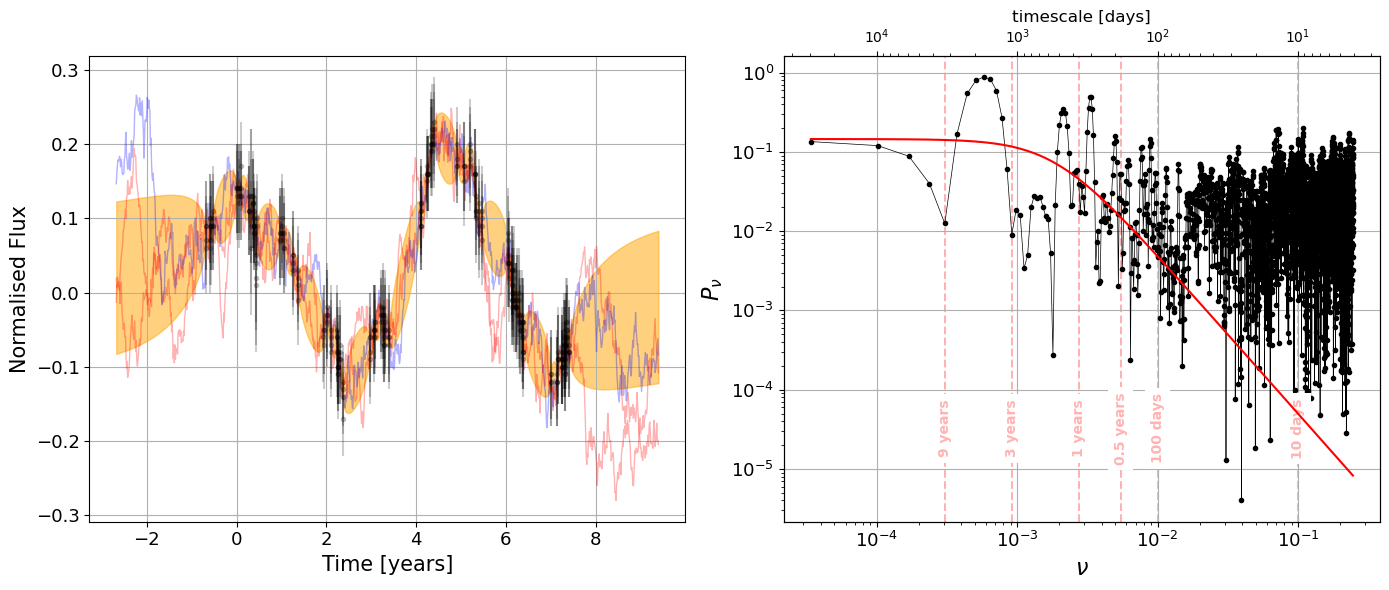

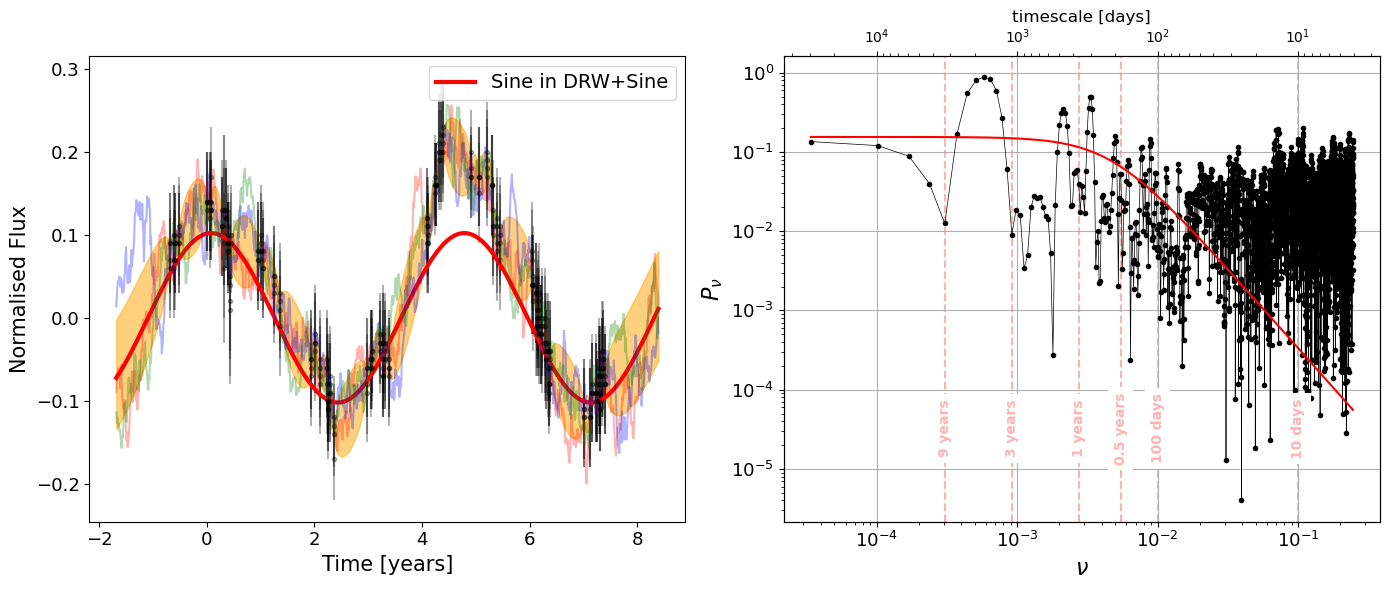

In [59]:
LC_PSD_plotter(DRW_dict, lcTIME, lcFLUX, lcFLUXerr, plot_what='DRW', plot_samples=True)
LC_PSD_plotter(DRWsine_dict, lcTIME, lcFLUX, lcFLUXerr, plot_what='DRWsine',  plot_samples=True)
#LC_PSD_plotter(CARMA21_dict, lcTIME, lcFLUX, lcFLUXerr, plot_what='CARMA21')


log_alpha1 : 1.8186991426859245
log_alpha2 : 3.3154087423582865
log_beta1  : 1.002713674608056
log_beta2  : -0.9458017620103081
log_sigma  : 0.051990643201320214
err_scale  : 0.20837240709195975


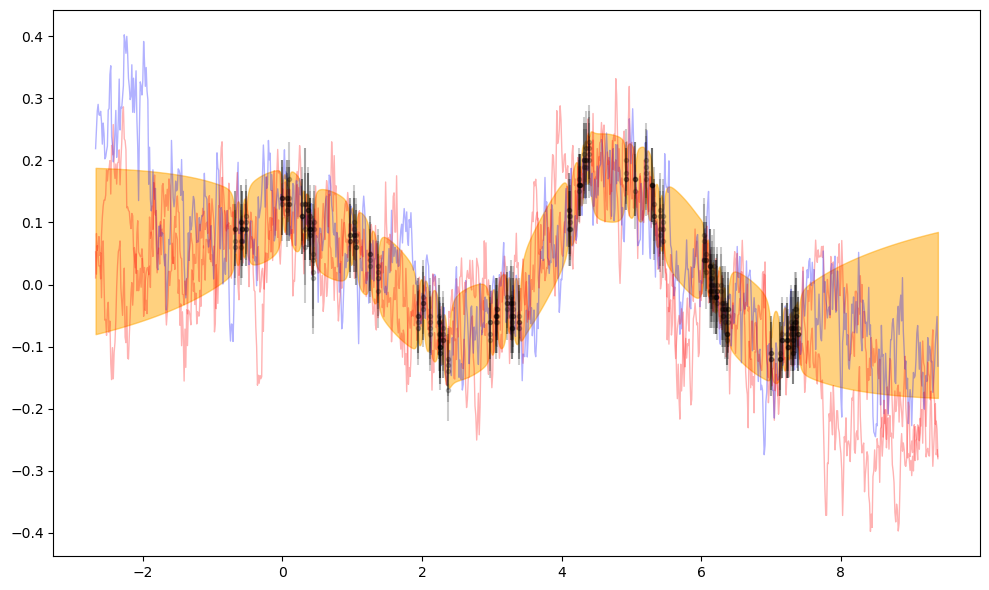

## SIM 1 : single bent power law | low freq:-1, high freq:-3.15

### Simulations

simrand, sampRand = 84763, 61535 # linear + sine

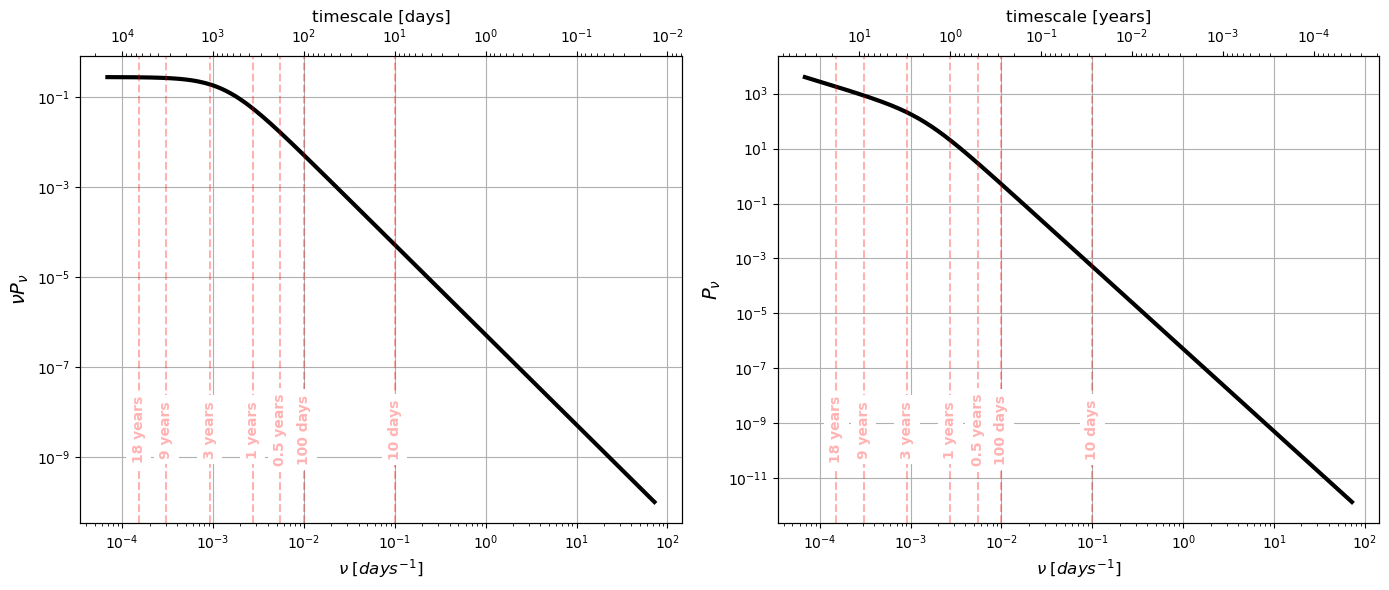

91471


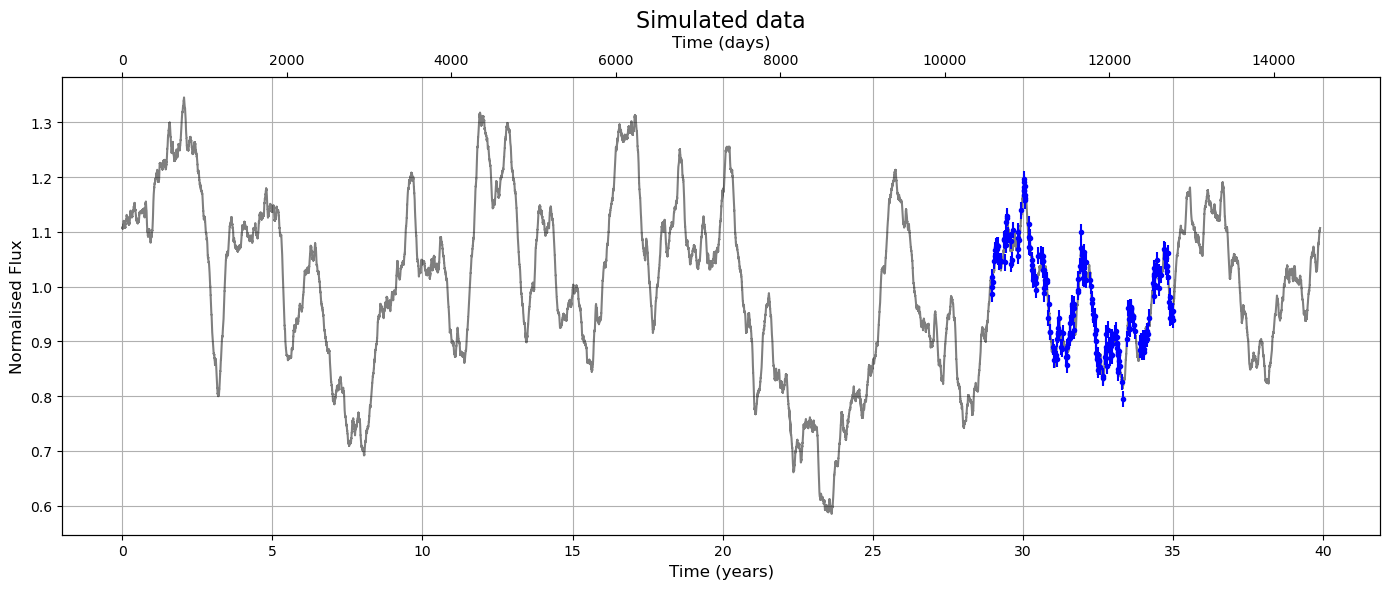

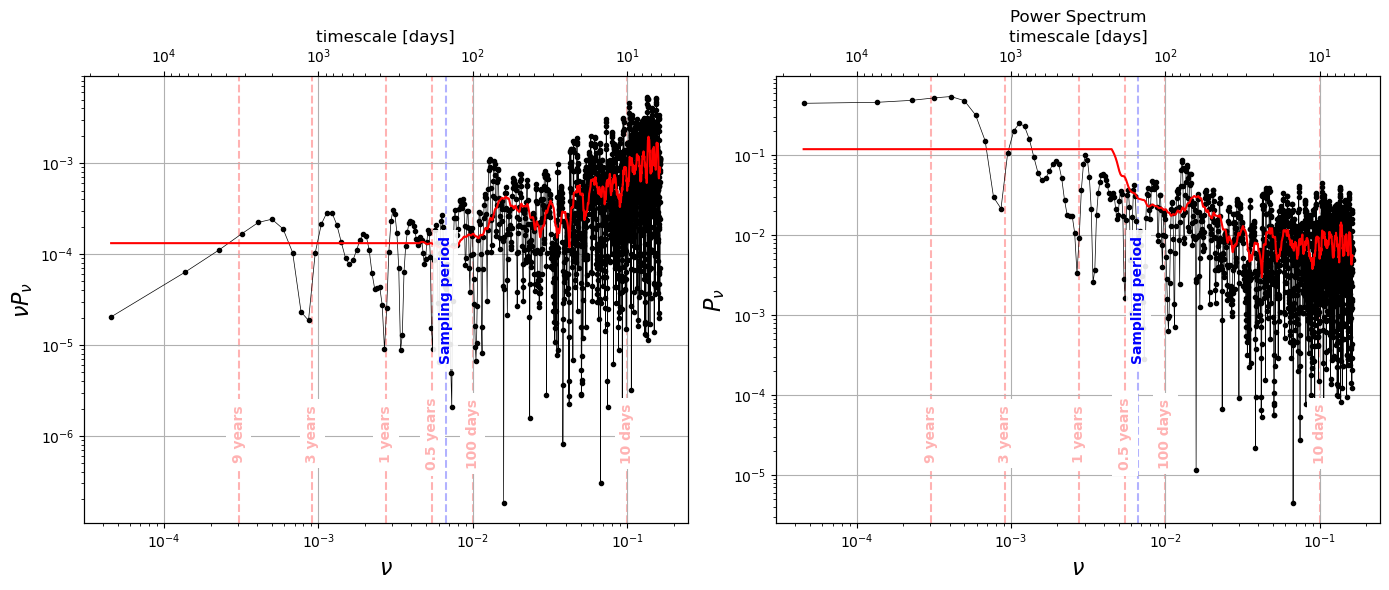

In [8]:
#simulator seed = 39468
#sampler seed = 1000
np.random.seed()
rand = np.random.randint(0, 100000)
l = LightCurveSampler(N=2**21, rms=0.15, simulatorSEED= rand , verbose=False)
l.load_powerspec(bend_pl, [200,  0.5/365,  -1,-3,1], plot=True) # turn off in 1/days
l.LCsimulator()
np.random.seed() 
rand =  np.random.randint(0, 100000)

print(rand)
simTIME, simLC, simLCerr , lc = l.sampler(NightsperWINDOW = 20, NumofWINDOW = 15 , OBSperiod = 5, WINDOWwidth = 120, samplerSEED=rand,
                                        dataLOSSfrac=0.2, noiseSIGMA=0.015, plot=True)



In [10]:
pd.DataFrame()

""


<ErrorbarContainer object of 3 artists>

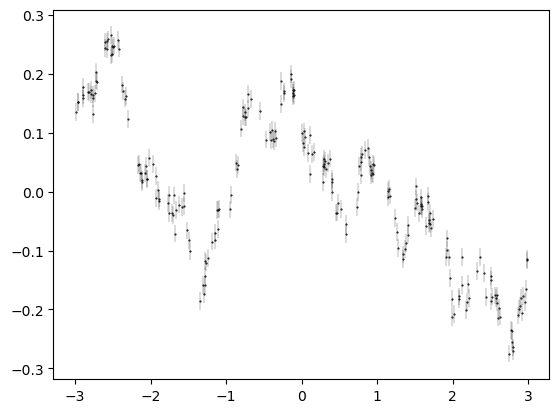

In [11]:
plt.errorbar(simTIME-np.mean(simTIME), simLC - np.median(simLC), yerr=simLCerr, fmt='.k', markersize=1,lw=0.2)

### NS models aka "Nice models"

#### DRW model

In [12]:
#DRW MODEL
def DRW_generative_prior():
    amp = yield jaxns.Prior( tfpd.LogNormal(-4, 1.15), name = 'amp')
    scale = yield jaxns.Prior( tfpd.LogNormal(-0.6, 1.15), name = 'scales')
    err_scale = yield jaxns.Prior(tfpd.Uniform(0,1.5), name='err_scale')
    #m = yield jaxns.Prior(tfpd.Uniform(0,5), name='m')
    #b = yield jaxns.Prior(tfpd.Uniform(-10, 1), name='b')
    
    return amp, scale, err_scale

def DRW_linear_generative_prior():
    amp = yield jaxns.Prior( tfpd.LogNormal(-4, 1.15), name = 'amp')
    scale = yield jaxns.Prior( tfpd.LogNormal(-0.6, 1.15), name = 'scales')
    err_scale = yield jaxns.Prior(tfpd.Uniform(0,1.5), name='err_scale')
    m = yield jaxns.Prior(tfpd.Uniform(0,5), name='m')
    b = yield jaxns.Prior(tfpd.Uniform(-2, 2), name='b')
    
    return amp, scale, err_scale, m , b

def linear_model(params, time):
    
    return params['m']*time + params['b']
    

def DRW_log_likelihood_model(amp, scales, err_scale, time = None, y = None, y_errs = None ):
    
    kernel = amp * kernels.Exp(scale = scales)
    #mean_params = {'m': m, 'b':b}
    
    gp = GaussianProcess(kernel, time, diag=(err_scale*y_errs)**2, mean=0)
    
    return gp.log_probability(y)

def DRW_linear_log_likelihood_model(amp, scales, err_scale, m, b, time = None, y = None, y_errs = None ):
    
    kernel = amp * kernels.Exp(scale = scales)
    mean_params = {'m': m, 'b':b}
    
    gp = GaussianProcess(kernel, time, diag=(err_scale*y_errs)**2, mean=partial(linear_model, mean_params))
    
    return gp.log_probability(y)


#### CARMA model

In [13]:
def CARMA_gen_prior_dynamic_code(p, q):
    indent = "    "
    dynamic_code_str = "def CARMA"+str(p)+str(q)+"_generative_prior():" + "\n"
    
    # log_alpha codes
    for i in range(p):
        dynamic_code_str = dynamic_code_str + indent + "log_alpha"+str(i) + " = yield jaxns.Prior( tfpd.Uniform(-7, 7), name = 'log_alpha"+str(i) + "')" + "\n"
    # log_beta codes
    for i in range(q):
        dynamic_code_str = dynamic_code_str + indent + "log_beta"+str(i+1) + " = yield jaxns.Prior( tfpd.Uniform(-7, 2.5), name = 'log_beta"+str(i+1) + "')" + "\n"
        
    dynamic_code_str =  dynamic_code_str + indent + "log_sigma = yield jaxns.Prior( tfpd.Uniform(-7, 7), name = 'log_sigma')" + "\n"
    dynamic_code_str =  dynamic_code_str + indent + "err_scale = yield jaxns.Prior(tfpd.Uniform(0,1.5), name='err_scale')" + "\n\n"
    
    dynamic_code_str =  dynamic_code_str + indent +  "return "
    
    for i in range(p):
        dynamic_code_str = dynamic_code_str + "log_alpha"+str(i) + ", " 
    for i in range(q):
        dynamic_code_str = dynamic_code_str + "log_beta"+str(i+1) + ", "
        
    dynamic_code_str = dynamic_code_str + "log_sigma, err_scale" 
    
    return dynamic_code_str
    
def CARMA__log_likelihood_dynamic_code(p, q):
    indent = "    "
    dynamic_code_str = "def CARMA"+str(p)+str(q)+"_log_likelihood_model("
    for i in range(p):
        dynamic_code_str = dynamic_code_str + "log_alpha"+str(i) + ", " 
    for i in range(q):
        dynamic_code_str = dynamic_code_str + "log_beta"+str(i+1) + ", "
        
    dynamic_code_str = dynamic_code_str + "log_sigma, err_scale, time = None, y = None, y_errs = None):" + "\n\n" 
    dynamic_code_str = dynamic_code_str + indent + "kernel = kernels.quasisep.CARMA.init("
    
    dynamic_code_str = dynamic_code_str + "alpha=["
    for i in range(p):
        dynamic_code_str = dynamic_code_str + "jnp.exp(log_alpha"+str(i) + "), " 
    
    dynamic_code_str = dynamic_code_str + "], \n" + indent*8 +  " beta=[jnp.exp(log_sigma) * 1, " 
    for i in range(q):
        dynamic_code_str = dynamic_code_str + "jnp.exp(log_sigma) * jnp.exp(log_beta"+str(i+1) + "), "
    
    dynamic_code_str = dynamic_code_str + "])" +  "\n\n"
    
    dynamic_code_str = dynamic_code_str + indent + "gp = GaussianProcess(kernel, time, diag=(err_scale*y_errs)**2, mean=0)" + "\n\n"
    
    dynamic_code_str = dynamic_code_str + indent + "return gp.log_probability(y)"
    
    return dynamic_code_str


def create_CARMA_JAXNS_model_funcs(p, q, functype):
    # Compile the dynamic code string into a code object
    
    if functype == "prior":
        dynamic_code = CARMA_gen_prior_dynamic_code(p, q)
        func_name = "CARMA"+str(p)+str(q)+"_generative_prior"
    elif functype == "likelihood":
        dynamic_code = CARMA__log_likelihood_dynamic_code(p,q)
        func_name = "CARMA"+str(p)+str(q)+"_log_likelihood_model"
    else:
        print("wrong functype!!")
    
    code_obj = compile(dynamic_code, '<string>', 'exec')

    # Create a namespace to hold the function
    namespace = {}
    
    # Execute the compiled code within the namespace
    exec(code_obj, globals(), namespace)

    # Extract the dynamically created function from the namespace
    dynamic_function = namespace[func_name]

    dynamic_function.__source__ = dynamic_code
    
    return dynamic_function


##### single CARMA models

In [291]:
def CARMA21_generative_prior():
    log_alpha0 = yield jaxns.Prior( tfpd.Uniform(-7, 2.5), name = 'log_alpha0')
    log_alpha1 = yield jaxns.Prior( tfpd.Uniform(-7, 2.5), name = 'log_alpha1')
    log_beta1 = yield jaxns.Prior( tfpd.Uniform(-7, 2.5), name = 'log_beta1')
    log_sigma = yield jaxns.Prior( tfpd.Uniform(-3, 5.3), name = 'log_sigma')
    err_scale = yield jaxns.Prior(tfpd.Uniform(0,1.5), name='err_scale')
    
    return log_alpha0, log_alpha1, log_beta1, log_sigma, err_scale

def CARMA21_log_likelihood_model(log_alpha0, log_alpha1, log_beta1, log_sigma, err_scale, time = None, y = None, y_errs = None ):
    
    kernel = kernels.quasisep.CARMA.init(alpha=[jnp.exp(log_alpha0), jnp.exp(log_alpha1)], 
                                    beta=[jnp.exp(log_sigma)*1, jnp.exp(log_sigma)*jnp.exp(log_beta1)])
    
    
    gp = GaussianProcess(kernel, time, diag=(err_scale*y_errs)**2, mean=0)
    
    return gp.log_probability(y)

def CARMA10_generative_prior():
    log_alpha0 = yield jaxns.Prior( tfpd.Uniform(-3, 2.5), name = 'log_alpha0')
    #log_alpha1 = yield jaxns.Prior( tfpd.Uniform(-7, 2.5), name = 'log_alpha1')
    #log_beta1 = yield jaxns.Prior( tfpd.Uniform(-7, 2.5), name = 'log_beta1')
    log_sigma = yield jaxns.Prior( tfpd.Uniform(-3, 5.3), name = 'log_sigma')
    err_scale = yield jaxns.Prior(tfpd.Uniform(0,1.5), name='err_scale')
    
    return log_alpha0, log_sigma, err_scale

def CARMA10_log_likelihood_model(log_alpha0, log_sigma, err_scale, time = None, y = None, y_errs = None ):
    
    kernel = kernels.quasisep.CARMA.init(alpha=[jnp.exp(log_alpha0)], 
                                    beta=[jnp.exp(log_sigma)*1])
    
    
    gp = GaussianProcess(kernel, time, diag=(err_scale*y_errs)**2, mean=0)
    
    return gp.log_probability(y)
def CARMA64_generative_prior():
    log_alpha0 = yield jaxns.Prior( tfpd.Uniform(-3, 2.5), name = 'log_alpha0')
    log_alpha1 = yield jaxns.Prior( tfpd.Uniform(-7, 2.5), name = 'log_alpha1')
    log_alpha2 = yield jaxns.Prior( tfpd.Uniform(-7, 2.5), name = 'log_alpha2')
    log_alpha3 = yield jaxns.Prior( tfpd.Uniform(-7, 2.5), name = 'log_alpha3')
    log_alpha4 = yield jaxns.Prior( tfpd.Uniform(-7, 2.5), name = 'log_alpha4')
    log_alpha5 = yield jaxns.Prior( tfpd.Uniform(-7, 2.5), name = 'log_alpha5')
    log_beta1 = yield jaxns.Prior( tfpd.Uniform(-7, 2.5), name = 'log_beta1')
    log_beta2 = yield jaxns.Prior( tfpd.Uniform(-7, 2.5), name = 'log_beta2')
    log_beta3 = yield jaxns.Prior( tfpd.Uniform(-7, 2.5), name = 'log_beta3')
    log_beta4 = yield jaxns.Prior( tfpd.Uniform(-7, 2.5), name = 'log_beta4')
    
    log_sigma = yield jaxns.Prior( tfpd.Uniform(-3, 5.3), name = 'log_sigma')
    err_scale = yield jaxns.Prior(tfpd.Uniform(0,1.5), name='err_scale')
    
    return log_alpha0, log_alpha1, log_alpha2, log_alpha3, log_alpha4, log_alpha5, log_beta1, log_beta2, log_beta3, log_beta4 ,log_sigma, err_scale

def CARMA64_log_likelihood_model(log_alpha0,log_alpha1,log_alpha2,log_alpha3,log_alpha4,log_alpha5, log_beta1, log_beta2, log_beta3, log_beta4,log_sigma, err_scale, time = None, y = None, y_errs = None ):
    
    kernel = kernels.quasisep.CARMA.init(alpha=[jnp.exp(log_alpha0), jnp.exp(log_alpha1), jnp.exp(log_alpha2), jnp.exp(log_alpha3), jnp.exp(log_alpha4), jnp.exp(log_alpha5)], 
                                    beta=[jnp.exp(log_sigma)*1, jnp.exp(log_sigma)*jnp.exp(log_beta1), jnp.exp(log_sigma)*jnp.exp(log_beta2), jnp.exp(log_sigma)*jnp.exp(log_beta3), jnp.exp(log_sigma)*jnp.exp(log_beta4)])
    
    
    gp = GaussianProcess(kernel, time, diag=(err_scale*y_errs)**2, mean=0)
    
    return gp.log_probability(y)

#### Sine model

In [14]:
# Sine model
def sine_model(A1, A2, t0, time = None ):
    
    return A1* jnp.cos(2*jnp.pi*time/t0) + A2* jnp.sin(2*jnp.pi*time/t0) 

def sin_linear_model(A1, A2, t0, m, b, time=None):
    
    return sine_model(A1, A2, t0, time ) + m*time + b

def sine_log_likelihood_model(A1, A2, t0, nu, time = None, y = None, y_errs = None):
    
    loglikeli = - (y - sine_model(A1, A2, t0, time))**2/(2*(nu*y_errs)**2) - jnp.log(jnp.sqrt(2*jnp.pi)*y_errs*nu)
    return jnp.sum(loglikeli)

def sine_linear_log_likelihood_model(A1, A2, t0, m, b, nu, time = None, y = None, y_errs = None):
    
    loglikeli = - (y - sin_linear_model(A1, A2, t0, m, b, time))**2/(2*(nu*y_errs)**2) - jnp.log(jnp.sqrt(2*jnp.pi)*y_errs*nu)
    return jnp.sum(loglikeli)

def sine_generative_prior():
    A1 = yield jaxns.Prior( tfpd.Normal(0,0.3), name = 'A1')
    A2 = yield jaxns.Prior( tfpd.Normal(0,0.3), name = 'A2')
    t0 = yield jaxns.Prior( tfpd.Uniform(0, 1.67), name ='t0')
    nu = yield jaxns.Prior( tfpd.Uniform(0.0, 1.), name = 'nu')
    
    return A1, A2, t0, nu

def sine_linear_generative_prior():
    A1 = yield jaxns.Prior( tfpd.Normal(0,0.3), name = 'A1')
    A2 = yield jaxns.Prior( tfpd.Normal(0,0.3), name = 'A2')
    t0 = yield jaxns.Prior( tfpd.Uniform(0, 1.67), name ='t0')
    nu = yield jaxns.Prior( tfpd.Uniform(0.0, 1.), name = 'nu')
    m = yield jaxns.Prior(tfpd.Uniform(0,5), name='m')
    b = yield jaxns.Prior(tfpd.Uniform(-2, 2), name='b')
    
    
    return A1, A2, t0, nu,  m, b,


#### DRW + sine model

In [15]:

def DRW_sine_generative_prior():
    amp = yield jaxns.Prior( tfpd.LogNormal(-4, 1.15), name = 'amp')
    scale = yield jaxns.Prior( tfpd.LogNormal(-0.6, 1.15), name = 'scales')
    err_scale = yield jaxns.Prior(tfpd.Uniform(0,1.5), name='err_scale')
    A1 = yield jaxns.Prior( tfpd.Normal(0,0.3), name = 'A1')
    A2 = yield jaxns.Prior( tfpd.Normal(0,0.3), name = 'A2')
    t0 = yield jaxns.Prior( tfpd.Uniform(0, 1.67), name ='t0')
    #nu = yield jaxns.Prior( tfpd.Uniform(0.0, 1.), name = 'nu')
    
    return amp, scale, err_scale, A1, A2, t0 #nu

def DRW_sine_linear_generative_prior():
    amp = yield jaxns.Prior( tfpd.LogNormal(-4, 1.15), name = 'amp')
    scale = yield jaxns.Prior( tfpd.LogNormal(-0.6, 1.15), name = 'scales')
    err_scale = yield jaxns.Prior(tfpd.Uniform(0,1.5), name='err_scale')
    A1 = yield jaxns.Prior( tfpd.Normal(0,0.3), name = 'A1')
    A2 = yield jaxns.Prior( tfpd.Normal(0,0.3), name = 'A2')
    t0 = yield jaxns.Prior( tfpd.Uniform(0, 1.67), name ='t0')
    m = yield jaxns.Prior(tfpd.Uniform(0,5), name='m')
    b = yield jaxns.Prior(tfpd.Uniform(-2, 2), name='b')
    #nu = yield jaxns.Prior( tfpd.Uniform(0.0, 1.), name = 'nu')
    
    return amp, scale, err_scale, A1, A2, t0, m, b #nu



def sine_curve_model(params, time):
    
    return params['A1']* jnp.cos(2*jnp.pi*time/params['t0']) + params['A2']* jnp.sin(2*jnp.pi*time/params['t0']) 

def sine_linear_model(params, time):
    
    return sine_curve_model(params, time) + params['m']*time + params['b']


def DRW_sine_linear_log_likelihood_model(amp, scales, err_scale, A1, A2, t0, m, b, time = None, y = None, y_errs = None):
    
    kernel = amp * kernels.Exp(scale = scales)
    
    mean_params = {'A1': A1, 'A2':A2, 't0':t0, 'm':m, 'b':b}
    
    gp = GaussianProcess(kernel, time, diag=(err_scale*y_errs)**2, mean= partial(sine_linear_model, mean_params) )
    
    return gp.log_probability(y)


def DRW_sine_log_likelihood_model(amp, scales, err_scale, A1, A2, t0, time = None, y = None, y_errs = None):
    
    kernel = amp * kernels.Exp(scale = scales)
    
    mean_params = {'A1': A1, 'A2':A2, 't0':t0}
    
    gp = GaussianProcess(kernel, time, diag=(err_scale*y_errs)**2, mean= partial(sine_curve_model, mean_params) )
    
    return gp.log_probability(y)


In [9]:
from NSmodels import *

### Sampling

In [10]:

lcTIME = simTIME - np.mean(simTIME)
lcFLUX = simLC - np.median(simLC)
lcFLUXerr = simLCerr

modelCreater = JAXNSmodelCreator(lcTIME, lcFLUX, lcFLUXerr)

DRW_NSmodel = modelCreater.create_model(DRW_generative_prior, DRW_log_likelihood_model)
DRW_linear_NSmodel = modelCreater.create_model(DRW_linear_generative_prior, DRW_linear_log_likelihood_model)

sine_NSmodel = modelCreater.create_model(sine_generative_prior, sine_log_likelihood_model)
sine_linear_NSmodel = modelCreater.create_model(sine_linear_generative_prior, sine_linear_log_likelihood_model)

DRW_sine_NSmodel = modelCreater.create_model(DRW_sine_generative_prior, DRW_sine_log_likelihood_model)
DRW_sine_linear_NSmodel = modelCreater.create_model(DRW_sine_linear_generative_prior, DRW_sine_linear_log_likelihood_model)

CARMA21_NSmodel = modelCreater.create_model(create_CARMA_JAXNS_model_funcs(2,1, functype="prior"), 
                                                    create_CARMA_JAXNS_model_funcs(2,1, functype="likelihood"))

#CARMA31_NSmodel = modelCreater.create_model(create_CARMA_JAXNS_model_funcs(3,1, functype="prior"), 
#                                                    create_CARMA_JAXNS_model_funcs(3,1, functype="likelihood"))

#CARMA10_NSmodel = modelCreater.create_model(create_CARMA_JAXNS_model_funcs(1,0, functype="prior"), 
#                                                    create_CARMA_JAXNS_model_funcs(1,0, functype="likelihood"))

# CARMA64_NSmodel = modelCreater.create_model(create_CARMA_JAXNS_model_funcs(6,4, functype="prior"), 
#                                                     create_CARMA_JAXNS_model_funcs(6,4, functype="likelihood"))

CARMA31_NSmodel = modelCreater.create_model(create_CARMA_JAXNS_model_funcs(3,1, functype="prior"), 
                                                    create_CARMA_JAXNS_model_funcs(3,1, functype="likelihood"))

# CARMA10_NSmodel = modelCreater.create_model(CARMA10_generative_prior, CARMA10_log_likelihood_model)
# CARMA64_NSmodel = modelCreater.create_model(CARMA64_generative_prior, CARMA64_log_likelihood_model)


ModelCOMP = ModelComparison(lcTIME, lcFLUX,lcFLUXerr, verbose=True)


ModelCOMP.add_NestedModel(CARMA21_NSmodel, 'CARMA21')
#ModelCOMP.add_NestedModel(CARMA31_NSmodel, 'CARMA31')
ModelCOMP.add_NestedModel(DRW_NSmodel, 'DRW')
#ModelCOMP.add_NestedModel(DRW_linear_NSmodel, 'DRW_linear')
#ModelCOMP.add_NestedModel(sine_NSmodel, 'sine')
#ModelCOMP.add_NestedModel(sine_linear_NSmodel, 'sine_linear')
#ModelCOMP.add_NestedModel(CARMA10_NSmodel, 'CARMA10')
#ModelCOMP.add_NestedModel(CARMA64_NSmodel, 'CARMA64')
ModelCOMP.add_NestedModel(CARMA31_NSmodel, 'CARMA31')

ModelCOMP.add_NestedModel(DRW_sine_NSmodel, 'DRWsine')

#ModelCOMP.add_NestedModel(DRW_sine_linear_NSmodel, 'DRWsine_linear')
#

Model Comparion object created.
JAXNS model added.
JAXNS model added.
JAXNS model added.
JAXNS model added.


In [11]:
ModelCOMP.models()

['CARMA21', 'DRW', 'CARMA64', 'DRWsine']

In [12]:
ModelCOMP.run_NSsampler()

Total number of models being sampled :  4
--------------------------------------------------------------------------
Model being sampled :  CARMA21
-------------------------------------------------------------------------
ExactNestedSampler Created. 
Sampling inititated.
Sampling finished.
TerminationCondition :  Small remaining evidence


Model being sampled :  DRW
-------------------------------------------------------------------------
ExactNestedSampler Created. 
Sampling inititated.
Sampling finished.
TerminationCondition :  Small remaining evidence


Model being sampled :  CARMA64
-------------------------------------------------------------------------
ExactNestedSampler Created. 
Sampling inititated.
Sampling finished.
TerminationCondition :  Small remaining evidence


Model being sampled :  DRWsine
-------------------------------------------------------------------------
ExactNestedSampler Created. 
Sampling inititated.
Sampling finished.
TerminationCondition :  Small remainin

### Comparison

In [13]:
ModelCOMP.pretty_print()

+-----------------------+------------------------------+------------------------------+------------------------------+------------------------------+
|                       |           CARMA21            |             DRW              |           CARMA64            |           DRWsine            |
+-----------------------+------------------------------+------------------------------+------------------------------+------------------------------+
|  Number of Parameters |              5               |              3               |              6               |              6               |
| Termination condition | ['Small remaining evidence'] | ['Small remaining evidence'] | ['Small remaining evidence'] | ['Small remaining evidence'] |
|          logZ         |      560.9588932958171       |      554.1589526174084       |      561.5938888804633       |      549.0524000188091       |
|           H           |    1.978146879997542e+247    |    8.143597975838351e+243    |    2.2515503

In [14]:
DRW_dict = ModelCOMP.return_samples_logZ_dict('DRW')
#sine_dict = ModelCOMP.return_samples_logZ_dict('sine')
DRWsine_dict = ModelCOMP.return_samples_logZ_dict('DRWsine')
CARMA21_dict = ModelCOMP.return_samples_logZ_dict('CARMA21')
CARMA31_dict = ModelCOMP.return_samples_logZ_dict('CARMA64')
#CARMA10_dict = ModelCOMP.return_samples_logZ_dict('CARMA10')
#CARMA64_dict = ModelCOMP.return_samples_logZ_dict('CARMA64')

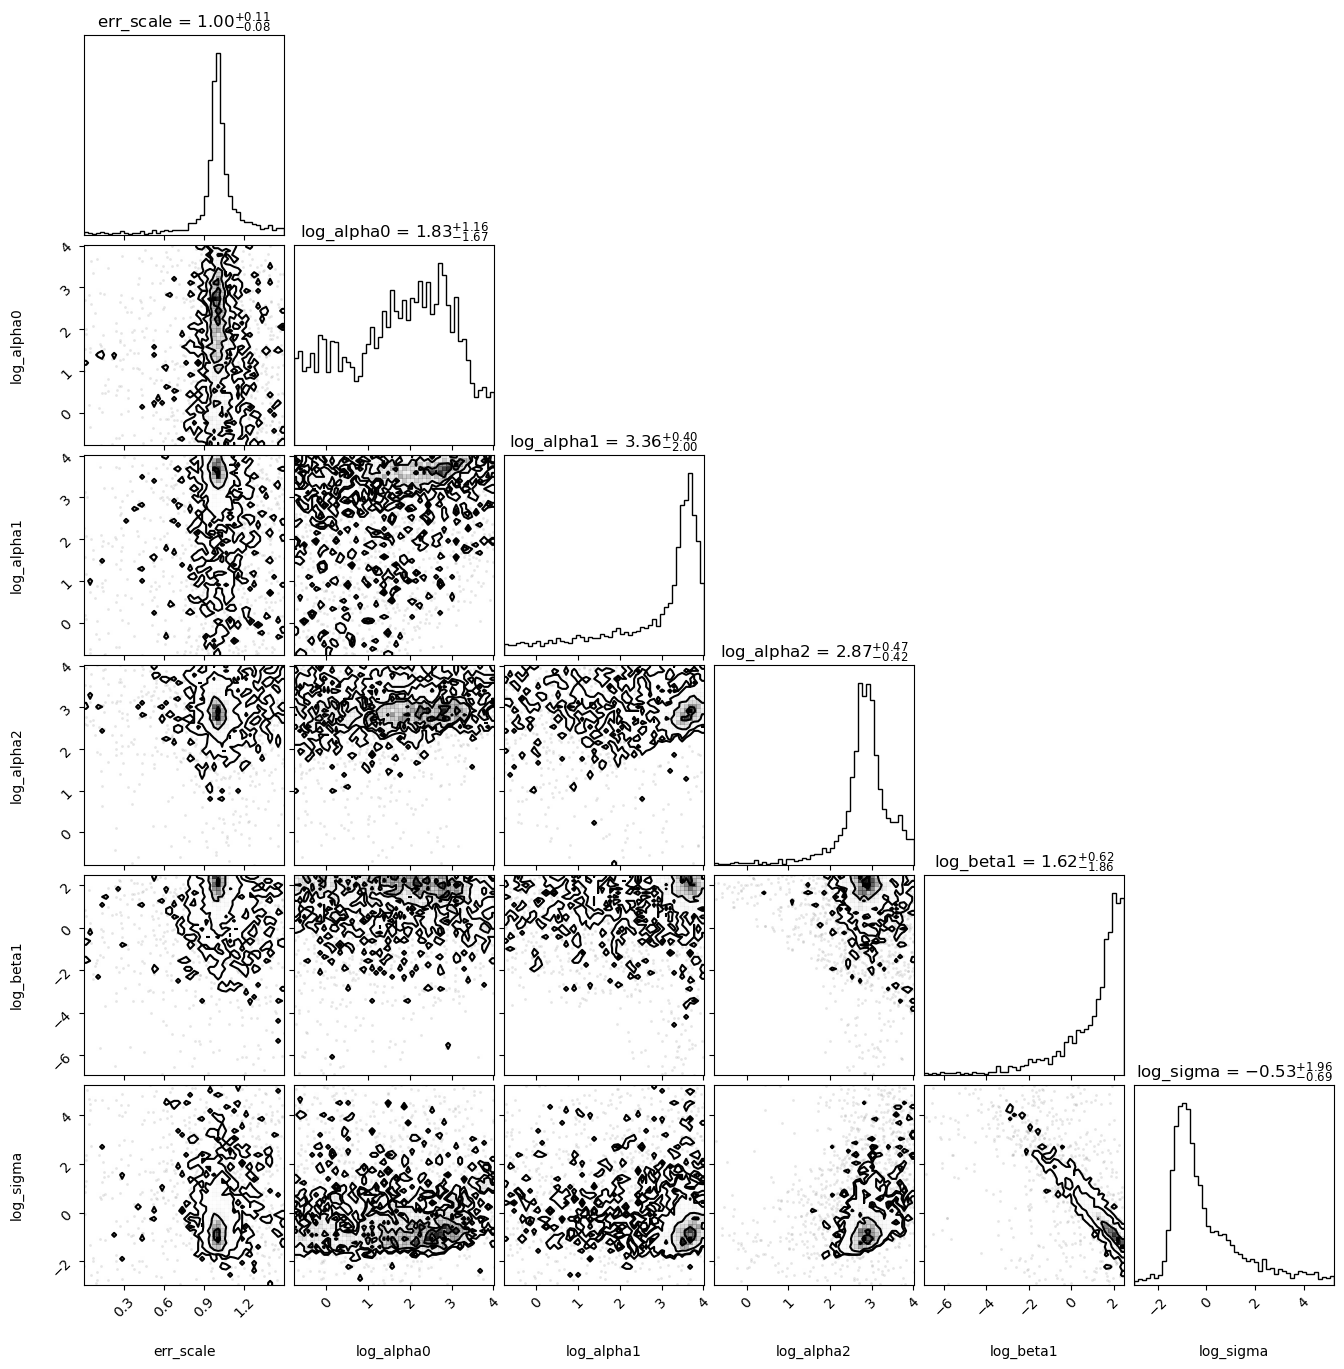

In [15]:
plot_corner(CARMA31_dict)

In [16]:
list(DRW_dict.keys())[2:]

['err_scale', 'log_amp', 'log_bend_freq']

In [17]:
LC_PSD_plotter(DRW_dict, lcTIME, lcFLUX, lcFLUXerr, plot_what='DRW')
LC_PSD_plotter(DRWsine_dict, lcTIME, lcFLUX, lcFLUXerr, plot_what='DRWsine')
LC_PSD_plotter(CARMA21_dict, lcTIME, lcFLUX, lcFLUXerr, plot_what='CARMA21')
#LC_PSD_plotter(CARMA21_dict, lcTIME, lcFLUX, lcFLUXerr, plot_what='CARMA10')
#LC_PSD_plotter(CARMA64_dict, lcTIME, lcFLUX, lcFLUXerr, plot_what='CARMA64')


{'log_Z_mean': 554.1589526174084, 'log_Z_uncert': 0.18819892927779192, 'err_scale': 0.8764985127168744, 'log_amp': -4.156097817505898, 'log_bend_freq': 0.2585102535178063}


KeyError: 'amp'

## sim params : Single bend power law

### NS models aka "Nice models"

#### DRW model

In [5]:
#DRW MODEL
def DRW_generative_prior():
    amp = yield jaxns.Prior( tfpd.LogNormal(-4, 1.15), name = 'amp')
    scale = yield jaxns.Prior( tfpd.LogNormal(-0.6, 1.15), name = 'scales')
    err_scale = yield jaxns.Prior(tfpd.Uniform(0,1.5), name='err_scale')
    #m = yield jaxns.Prior(tfpd.Uniform(0,5), name='m')
    #b = yield jaxns.Prior(tfpd.Uniform(-10, 1), name='b')
    
    return amp, scale, err_scale

def DRW_linear_generative_prior():
    amp = yield jaxns.Prior( tfpd.LogNormal(-4, 1.15), name = 'amp')
    scale = yield jaxns.Prior( tfpd.LogNormal(-0.6, 1.15), name = 'scales')
    err_scale = yield jaxns.Prior(tfpd.Uniform(0,1.5), name='err_scale')
    m = yield jaxns.Prior(tfpd.Uniform(0,5), name='m')
    b = yield jaxns.Prior(tfpd.Uniform(-2, 2), name='b')
    
    return amp, scale, err_scale, m , b

def linear_model(params, time):
    
    return params['m']*time + params['b']
    

def DRW_log_likelihood_model(amp, scales, err_scale, time = None, y = None, y_errs = None ):
    
    kernel = amp * kernels.Exp(scale = scales)
    #mean_params = {'m': m, 'b':b}
    
    gp = GaussianProcess(kernel, time, diag=(err_scale*y_errs)**2, mean=0)
    
    return gp.log_probability(y)

def DRW_linear_log_likelihood_model(amp, scales, err_scale, m, b, time = None, y = None, y_errs = None ):
    
    kernel = amp * kernels.Exp(scale = scales)
    mean_params = {'m': m, 'b':b}
    
    gp = GaussianProcess(kernel, time, diag=(err_scale*y_errs)**2, mean=partial(linear_model, mean_params))
    
    return gp.log_probability(y)


#### Sine model

In [6]:
# Sine model
def sine_model(A1, A2, t0, time = None ):
    
    return A1* jnp.cos(2*jnp.pi*time/t0) + A2* jnp.sin(2*jnp.pi*time/t0) 

def sin_linear_model(A1, A2, t0, m, b, time=None):
    
    return sine_model(A1, A2, t0, time ) + m*time + b

def sine_log_likelihood_model(A1, A2, t0, nu, time = None, y = None, y_errs = None):
    
    loglikeli = - (y - sine_model(A1, A2, t0, time))**2/(2*(nu*y_errs)**2) - jnp.log(jnp.sqrt(2*jnp.pi)*y_errs*nu)
    return jnp.sum(loglikeli)

def sine_linear_log_likelihood_model(A1, A2, t0, m, b, nu, time = None, y = None, y_errs = None):
    
    loglikeli = - (y - sin_linear_model(A1, A2, t0, m, b, time))**2/(2*(nu*y_errs)**2) - jnp.log(jnp.sqrt(2*jnp.pi)*y_errs*nu)
    return jnp.sum(loglikeli)

def sine_generative_prior():
    A1 = yield jaxns.Prior( tfpd.Normal(0,0.3), name = 'A1')
    A2 = yield jaxns.Prior( tfpd.Normal(0,0.3), name = 'A2')
    t0 = yield jaxns.Prior( tfpd.Uniform(0, 1.67), name ='t0')
    nu = yield jaxns.Prior( tfpd.Uniform(0.0, 1.), name = 'nu')
    
    return A1, A2, t0, nu

def sine_linear_generative_prior():
    A1 = yield jaxns.Prior( tfpd.Normal(0,0.3), name = 'A1')
    A2 = yield jaxns.Prior( tfpd.Normal(0,0.3), name = 'A2')
    t0 = yield jaxns.Prior( tfpd.Uniform(0, 1.67), name ='t0')
    nu = yield jaxns.Prior( tfpd.Uniform(0.0, 1.), name = 'nu')
    m = yield jaxns.Prior(tfpd.Uniform(0,5), name='m')
    b = yield jaxns.Prior(tfpd.Uniform(-2, 2), name='b')
    
    
    return A1, A2, t0, nu,  m, b,


#### DRW + sine model

In [7]:

def DRW_sine_generative_prior():
    amp = yield jaxns.Prior( tfpd.LogNormal(-4, 1.15), name = 'amp')
    scale = yield jaxns.Prior( tfpd.LogNormal(-0.6, 1.15), name = 'scales')
    err_scale = yield jaxns.Prior(tfpd.Uniform(0,1.5), name='err_scale')
    A1 = yield jaxns.Prior( tfpd.Normal(0,0.3), name = 'A1')
    A2 = yield jaxns.Prior( tfpd.Normal(0,0.3), name = 'A2')
    t0 = yield jaxns.Prior( tfpd.Uniform(0, 1.67), name ='t0')
    #nu = yield jaxns.Prior( tfpd.Uniform(0.0, 1.), name = 'nu')
    
    return amp, scale, err_scale, A1, A2, t0 #nu

def DRW_sine_linear_generative_prior():
    amp = yield jaxns.Prior( tfpd.LogNormal(-4, 1.15), name = 'amp')
    scale = yield jaxns.Prior( tfpd.LogNormal(-0.6, 1.15), name = 'scales')
    err_scale = yield jaxns.Prior(tfpd.Uniform(0,1.5), name='err_scale')
    A1 = yield jaxns.Prior( tfpd.Normal(0,0.3), name = 'A1')
    A2 = yield jaxns.Prior( tfpd.Normal(0,0.3), name = 'A2')
    t0 = yield jaxns.Prior( tfpd.Uniform(0, 1.67), name ='t0')
    m = yield jaxns.Prior(tfpd.Uniform(0,5), name='m')
    b = yield jaxns.Prior(tfpd.Uniform(-2, 2), name='b')
    #nu = yield jaxns.Prior( tfpd.Uniform(0.0, 1.), name = 'nu')
    
    return amp, scale, err_scale, A1, A2, t0, m, b #nu



def sine_curve_model(params, time):
    
    return params['A1']* jnp.cos(2*jnp.pi*time/params['t0']) + params['A2']* jnp.sin(2*jnp.pi*time/params['t0']) 

def sine_linear_model(params, time):
    
    return sine_curve_model(params, time) + params['m']*time + params['b']


def DRW_sine_linear_log_likelihood_model(amp, scales, err_scale, A1, A2, t0, m, b, time = None, y = None, y_errs = None):
    
    kernel = amp * kernels.Exp(scale = scales)
    
    mean_params = {'A1': A1, 'A2':A2, 't0':t0, 'm':m, 'b':b}
    
    gp = GaussianProcess(kernel, time, diag=(err_scale*y_errs)**2, mean= partial(sine_linear_model, mean_params) )
    
    return gp.log_probability(y)


def DRW_sine_log_likelihood_model(amp, scales, err_scale, A1, A2, t0, time = None, y = None, y_errs = None):
    
    kernel = amp * kernels.Exp(scale = scales)
    
    mean_params = {'A1': A1, 'A2':A2, 't0':t0}
    
    gp = GaussianProcess(kernel, time, diag=(err_scale*y_errs)**2, mean= partial(sine_curve_model, mean_params) )
    
    return gp.log_probability(y)


### simdata creation

In [70]:
simDATA = pd.DataFrame()
simDATA[['ID','simSEED','sampleSEED', 'rms', 'noiseSIGMA', 'bendfreq', 'lowalpha', 'highalpha', 'sharpness' ]] = -1, -1, -1, -1, -1, -1, -1, -1, -1
simDATA

,ID,simSEED,sampleSEED,rms,noiseSIGMA,bendfreq,lowalpha,highalpha,sharpness


In [1]:
grid = []
for i in range(3, 40 + 1):
        for j in range(1, i):
            grid.append([i, j])
            
grid =  np.array(grid)

NameError: name 'np' is not defined

In [72]:
len(grid)

779

In [74]:
for i in range(len(grid)):
    np.random.seed() 
    rand1 =  np.random.randint(0, 100000)
    np.random.seed() 
    rand2 =  np.random.randint(0, 100000)
    row = [1000+i, rand1, rand2, 0.15, 0.015, 1/365, -1, -2.5, 10]
    simDATA.loc[len(simDATA)] = row
    #print(rand2, rand1)

In [77]:
simDATA[['NightsperWINDOW', 'NumofWINDOW', 'dataLOSSfrac']] = 20, 8, 0.2
simDATA['OBSperiod'] = grid[:,0] /4
simDATA['WINDOWwidth'] = grid[:,1]*7

simDATA


,ID,simSEED,sampleSEED,rms,noiseSIGMA,bendfreq,lowalpha,highalpha,sharpness,NightsperWINDOW,NumofWINDOW,dataLOSSfrac,OBSperiod,WINDOWwidth
0,1000.0,17116.0,98941.0,0.15,0.015,0.00274,-1.0,-2.5,10.0,20,8,0.2,0.75,7
1,1001.0,27309.0,59699.0,0.15,0.015,0.00274,-1.0,-2.5,10.0,20,8,0.2,0.75,14
2,1002.0,26240.0,62372.0,0.15,0.015,0.00274,-1.0,-2.5,10.0,20,8,0.2,1.00,7
3,1003.0,44044.0,45699.0,0.15,0.015,0.00274,-1.0,-2.5,10.0,20,8,0.2,1.00,14
4,1004.0,37433.0,18831.0,0.15,0.015,0.00274,-1.0,-2.5,10.0,20,8,0.2,1.00,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774,1774.0,58923.0,46915.0,0.15,0.015,0.00274,-1.0,-2.5,10.0,20,8,0.2,10.00,245
775,1775.0,50081.0,28962.0,0.15,0.015,0.00274,-1.0,-2.5,10.0,20,8,0.2,10.00,252
776,1776.0,41373.0,62890.0,0.15,0.015,0.00274,-1.0,-2.5,10.0,20,8,0.2,10.00,259
777,1777.0,55452.0,97821.0,0.15,0.015,0.00274,-1.0,-2.5,10.0,20,8,0.2,10.00,266


In [78]:
1/0.00274

364.9635036496351

In [79]:
simDATA.to_csv('simDATAcsvs/simDATA3.csv', index=False)

### Simulation and fitting

In [49]:
simDATA = pd.read_csv('simDATAcsvs/simDATA3.csv')
import gc

In [50]:
simDATA

,ID,simSEED,sampleSEED,rms,noiseSIGMA,bendfreq,lowalpha,highalpha,sharpness,NightsperWINDOW,NumofWINDOW,dataLOSSfrac,OBSperiod,WINDOWwidth
0,1000.0,24520.0,34562.0,0.15,0.015,0.00274,-1.0,-2.5,10.0,20,8,0.2,0.69,7.0
1,1001.0,64926.0,73269.0,0.15,0.015,0.00274,-1.0,-2.5,10.0,20,8,0.2,0.69,14.0
2,1002.0,52611.0,11190.0,0.15,0.015,0.00274,-1.0,-2.5,10.0,20,8,0.2,0.69,21.0
3,1003.0,29594.0,48112.0,0.15,0.015,0.00274,-1.0,-2.5,10.0,20,8,0.2,0.69,28.0
4,1004.0,96536.0,25638.0,0.15,0.015,0.00274,-1.0,-2.5,10.0,20,8,0.2,0.69,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,2515.0,54197.0,81333.0,0.15,0.015,0.00274,-1.0,-2.5,10.0,20,8,0.2,9.20,252.0
1516,2516.0,48976.0,56605.0,0.15,0.015,0.00274,-1.0,-2.5,10.0,20,8,0.2,9.20,259.0
1517,2517.0,39672.0,87377.0,0.15,0.015,0.00274,-1.0,-2.5,10.0,20,8,0.2,9.20,266.0
1518,2518.0,90185.0,40814.0,0.15,0.015,0.00274,-1.0,-2.5,10.0,20,8,0.2,9.20,273.0


In [80]:
import psutil
from psutil._common import bytes2human
import os
import tracemalloc


In [81]:
psutil.virtual_memory().used/(1024**3)

6.369884490966797

In [82]:
pid = os.getpid()
python_process = psutil.Process(pid)


### testing

In [43]:
def likelihood_ASSIGNER(input_function,  flux , time, flux_err):
        def generated_function(*args, **kwargs):

            updated_kwargs = {**kwargs, 'y': flux, 'y_errs': flux_err, 'time': time}

            return input_function(*args, **updated_kwargs)

        return generated_function


def create_model(prior_mod, log_likeli_fun, flux, time, flux_err):
    log_likeli_fun_updated = likelihood_ASSIGNER(log_likeli_fun, flux, time, flux_err )

    return jaxns.Model(prior_model=prior_mod, log_likelihood=log_likeli_fun_updated)
    

def NSsampler(time, flux, flux_err, prior_generator, loglikelihood_func):
    
    # Create JAXNS model
    JAXNSmodel = create_model(prior_generator, loglikelihood_func, flux, time, flux_err)
    
    # Create sampler
    sampler = ExactNestedSampler(model=JAXNSmodel, num_live_points=200, max_samples=1e4)
    
    # Run Sampler
    termination_reason, state =sampler(jax.random.PRNGKey(42),
                                        term_cond=TerminationCondition(live_evidence_frac=1e-4))
    
    NSresults = sampler.to_results(state, termination_reason)
    
    return NSresults

In [13]:
failed_indices = []
# ram_py = []
# ram_py.append(python_process.memory_info()[0]/(1025**3))
# ram_py_single_run = []
# ram_py_single_run.append(python_process.memory_info()[0]/(1025**3))
#tracemalloc.start(25)
for r, row in simDATA[0:3].iterrows():

        l = LightCurveSampler(N=2**21, rms=simDATA.rms.to_numpy()[0], simulatorSEED= int(simDATA.simSEED.to_numpy()[0]), verbose=False)
        l.load_powerspec(bend_pl, [200,  simDATA.bendfreq.to_numpy()[0], 
                                    simDATA.lowalpha.to_numpy()[0],
                                    simDATA.highalpha.to_numpy()[0],
                                    simDATA.sharpness.to_numpy()[0]], 
                                    plot=False)
        l.LCsimulator()
        simTIME, simLC, simLCerr , lc = l.sampler(NightsperWINDOW = int(row.NightsperWINDOW), 
                                                    NumofWINDOW = int(row.NumofWINDOW),
                                                    OBSperiod = row.OBSperiod,
                                                    WINDOWwidth = row.WINDOWwidth,
                                                    samplerSEED = int(row.sampleSEED),
                                                    dataLOSSfrac = row.dataLOSSfrac, 
                                                    noiseSIGMA = row.noiseSIGMA, plot=False)
        
        
        
        lcTIME = simTIME - np.mean(simTIME)
        lcFLUX = simLC - np.median(simLC)
        lcFLUXerr = simLCerr
        
        
        ram_py_single_run.append(python_process.memory_info()[0]/(1025**3))
        
        DRW_NSresult = NSsampler(lcTIME, lcFLUX, lcFLUXerr, DRW_generative_prior, DRW_log_likelihood_model)
        DRW_linear_NSresult = NSsampler(lcTIME, lcFLUX, lcFLUXerr, DRW_linear_generative_prior, DRW_linear_log_likelihood_model)
        sine_NSresult = NSsampler(lcTIME, lcFLUX, lcFLUXerr, sine_generative_prior, sine_log_likelihood_model)
        sine_linear_NSresult = NSsampler(lcTIME, lcFLUX, lcFLUXerr, sine_linear_generative_prior, sine_linear_log_likelihood_model)
        DRW_sine_NSresult = NSsampler(lcTIME, lcFLUX, lcFLUXerr, DRW_sine_generative_prior, DRW_sine_log_likelihood_model)
        DRW_sine_linear_NSresult = NSsampler(lcTIME, lcFLUX, lcFLUXerr, DRW_sine_linear_generative_prior, DRW_sine_linear_log_likelihood_model)
        

        
        ram_py_single_run.append(python_process.memory_info()[0]/(1025**3))
        
        # with open('modelCOMP_objects/modelCOMP_'+str(int(row.ID))+'.pkl', 'wb') as file:
        #     dill.dump(ModelCOMP, file)
        
        del l, lcTIME, simTIME, simLC, simLCerr, lcFLUX, lcFLUXerr
        del DRW_NSresult, DRW_linear_NSresult, sine_NSresult, sine_linear_NSresult, DRW_sine_NSresult, DRW_sine_linear_NSresult
        gc.collect()
        print(python_process.memory_info()[0]/(1025**3), end='-->')
        
    # except:
    #     failed_indices.append(r)
    
#snapshot = tracemalloc.take_snapshot()
#top_stats = snapshot.statistics('traceback')

# pick the biggest memory block
#stat = top_stats[0]
#print("%s memory blocks: %.1f KiB" % (stat.count, stat.size / 1024))
#for line in stat.traceback.format():
#    print(line)

0-->1-->2-->

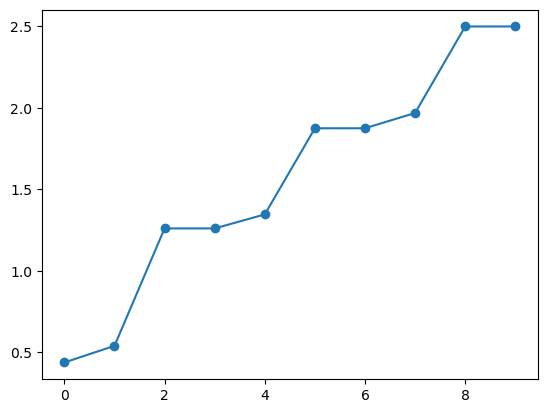

In [14]:
plt.plot(ram_py_single_run, 'o-') # single_run

In [ ]:
plt.plot(ram_py) 

### loops

In [55]:
failed_indices = []
# ram_py = []
# ram_py.append(python_process.memory_info()[0]/(1025**3))
# ram_py_single_run = []
# ram_py_single_run.append(python_process.memory_info()[0]/(1025**3))
#tracemalloc.start(25)
for r, row in simDATA[1:3].iterrows():

        l = LightCurveSampler(N=2**21, rms=row.rms, simulatorSEED= int(row.simSEED), verbose=False)
        l.load_powerspec(bend_pl, [200,  row.bendfreq, 
                                    row.lowalpha,
                                    row.highalpha,
                                    row.sharpness], 
                                    plot=False)
        l.LCsimulator()
        simTIME, simLC, simLCerr , lc = l.sampler(NightsperWINDOW = int(row.NightsperWINDOW), 
                                                    NumofWINDOW = int(row.NumofWINDOW),
                                                    OBSperiod = row.OBSperiod,
                                                    WINDOWwidth = row.WINDOWwidth,
                                                    samplerSEED = int(row.sampleSEED),
                                                    dataLOSSfrac = row.dataLOSSfrac, 
                                                    noiseSIGMA = row.noiseSIGMA, plot=False)
        #ram_py_single_run.append(python_process.memory_info()[0]/(1025**3))
        
        
        lcTIME = simTIME - np.mean(simTIME)
        lcFLUX = simLC - np.median(simLC)
        lcFLUXerr = simLCerr
        #print(r, end='-->')
        modelCreater = JAXNSmodelCreator(lcTIME, lcFLUX, lcFLUXerr)

        DRW_NSmodel = modelCreater.create_model(DRW_generative_prior, DRW_log_likelihood_model)
        # DRW_linear_NSmodel = modelCreater.create_model(DRW_linear_generative_prior, DRW_linear_log_likelihood_model)

        # sine_NSmodel = modelCreater.create_model(sine_generative_prior, sine_log_likelihood_model)
        # sine_linear_NSmodel = modelCreater.create_model(sine_linear_generative_prior, sine_linear_log_likelihood_model)

        DRW_sine_NSmodel = modelCreater.create_model(DRW_sine_generative_prior, DRW_sine_log_likelihood_model)
        # DRW_sine_linear_NSmodel = modelCreater.create_model(DRW_sine_linear_generative_prior, DRW_sine_linear_log_likelihood_model)
        #ram_py_single_run.append(python_process.memory_info()[0]/(1025**3))
        
        
        ModelCOMP = ModelComparison(lcTIME, lcFLUX,lcFLUXerr, verbose=False)
        ModelCOMP.add_NestedModel(DRW_NSmodel, 'DRW')
        # ModelCOMP.add_NestedModel(DRW_linear_NSmodel, 'DRW_linear')
        # ModelCOMP.add_NestedModel(sine_NSmodel, 'sine')
        # ModelCOMP.add_NestedModel(sine_linear_NSmodel, 'sine_linear')
        ModelCOMP.add_NestedModel(DRW_sine_NSmodel, 'DRWsine')
        # ModelCOMP.add_NestedModel(DRW_sine_linear_NSmodel, 'DRWsine_linear')
        #ram_py_single_run.append(python_process.memory_info()[0]/(1025**3))
        
        ModelCOMP.run_NSsampler()
        
        print(psutil.virtual_memory().used/(1024**3), end='-->')
        #ram_py_single_run.append()
        
        with open('modelCOMP_objects/sampling_test/modelCOMP_'+str(int(row.ID))+'.pkl', 'wb') as file:
            dill.dump(ModelCOMP, file)
        
        del l, lcTIME, lcFLUX, lcFLUXerr, lc , modelCreater, DRW_NSmodel, DRW_sine_NSmodel, ModelCOMP#, sine_NSmodel,
        del  simTIME, simLC, simLCerr  #, DRW_linear_NSmodel, sine_linear_NSmodel, DRW_sine_linear_NSmodel,
        gc.collect()
        
        if psutil.virtual_memory().used/(1024**3)>7:
            break
        #ram_py_single_run.append(python_process.memory_info()[0]/(1025**3))
        #ram_py.append(python_process.memory_info()[0]/(1025**3))
    # except:
    #     failed_indices.append(r)
    
#snapshot = tracemalloc.take_snapshot()
#top_stats = snapshot.statistics('traceback')

# pick the biggest memory block
#stat = top_stats[0]
#print("%s memory blocks: %.1f KiB" % (stat.count, stat.size / 1024))
#for line in stat.traceback.format():
#    print(line)

6.136875152587891-->Windows are overlapping. Try a different combination of OBSperiod and WINDOWwidth


TypeError: cannot unpack non-iterable int object

In [56]:
grid

array([[  0.69,   7.  ],
       [  0.69,  14.  ],
       [  0.69,  21.  ],
       ...,
       [  9.2 , 266.  ],
       [  9.2 , 273.  ],
       [  9.2 , 280.  ]])

pmem(rss=1343029248, vms=4974682112, shared=217808896, text=2306048, lib=0, data=1496883200, dirty=0)

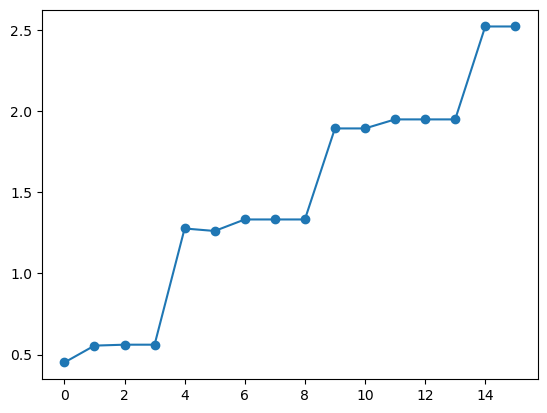

In [12]:
plt.plot(ram_py_single_run, 'o-') # single_run

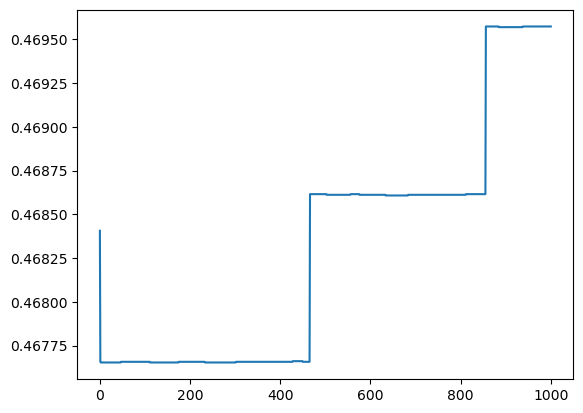

In [13]:
plt.plot(ram_py) # without modelCOMP and JAXNSmodelcreator

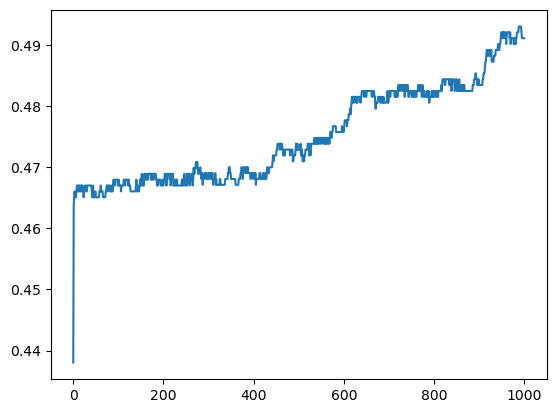

In [11]:
plt.plot(ram_py) # without modelCOMP

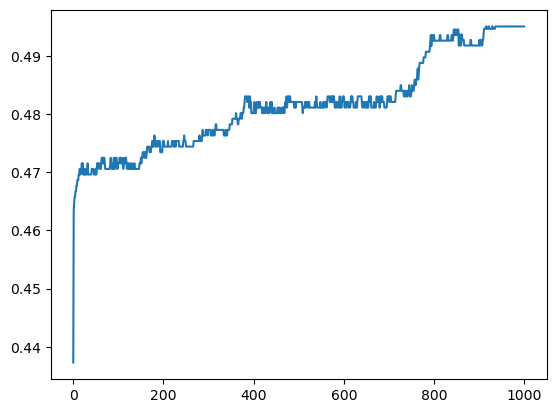

In [12]:
plt.plot(ram_py) # with ModelCOMP loading models no sampler

## Sim results

In [34]:
simDATA = pd.read_csv('simDATAcsvs/simDATA_highALPHA_2_4.csv')

In [35]:
simDATA

,ID,simSEED,sampleSEED,rms,noiseSIGMA,bendfreq,lowalpha,highalpha,sharpness,NightsperWINDOW,NumofWINDOW,OBSperiod,WINDOWwidth,dataLOSSfrac,DRW_log_Z_mean,DRWsine_log_Z_mean,CARMA21_log_Z_mean
0,1000.0,85077.0,21789.0,0.15,0.015,0.00274,-1.0,-2.0,10.0,20,8,6,60,0.2,265.046750,261.890975,252.030646
1,1001.0,56812.0,96275.0,0.15,0.015,0.00274,-1.0,-2.0,10.0,20,8,6,60,0.2,246.142154,246.269348,236.585116
2,1002.0,3151.0,18152.0,0.15,0.015,0.00274,-1.0,-2.0,10.0,20,8,6,60,0.2,245.073218,241.133433,236.239642
3,1003.0,66037.0,92149.0,0.15,0.015,0.00274,-1.0,-2.0,10.0,20,8,6,60,0.2,234.983904,232.202708,226.239527
4,1004.0,88231.0,48429.0,0.15,0.015,0.00274,-1.0,-2.0,10.0,20,8,6,60,0.2,241.973272,238.771251,230.567598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1995.0,98451.0,96926.0,0.15,0.015,0.00274,-1.0,-4.0,10.0,20,8,6,60,0.2,310.304722,305.266565,259.421915
996,1996.0,78895.0,14885.0,0.15,0.015,0.00274,-1.0,-4.0,10.0,20,8,6,60,0.2,319.247525,319.066786,267.046023
997,1997.0,29297.0,84053.0,0.15,0.015,0.00274,-1.0,-4.0,10.0,20,8,6,60,0.2,310.460404,309.283892,269.175288
998,1998.0,42328.0,23455.0,0.15,0.015,0.00274,-1.0,-4.0,10.0,20,8,6,60,0.2,301.480146,299.797354,262.051046


In [36]:
# simDATA[['DRW_bf','DRW_linear_bf', 'DRWsine_bf','DRWsine_linear_bf', 'sine_freq', 'sine_linear_freq' ]] = -99, -99, -99, -99, -99, -99
# simDATA[['DRW_logZ','DRW_linear_logZ', 'DRWsine_logZ','DRWsine_linear_logZ', 'sine_logZ', 'sine_linear_logZ' ]] = -99, -99, -99, -99, -99, -99
# simDATA[['model1', 'model2', 'model3', 'model4', 'model5', 'model6']] = 'nan', 'nan', 'nan', 'nan', 'nan', 'nan'

simDATA[['DRW_bf','DRWsine_bf' ]] = -99, -99
#simDATA[['DRW_logZ', 'DRWsine_logZ' ]] = -99, -99
simDATA[['model1', 'model2']] = 'nan', 'nan'
simDATA

,ID,simSEED,sampleSEED,rms,noiseSIGMA,bendfreq,lowalpha,highalpha,sharpness,NightsperWINDOW,...,OBSperiod,WINDOWwidth,dataLOSSfrac,DRW_log_Z_mean,DRWsine_log_Z_mean,CARMA21_log_Z_mean,DRW_bf,DRWsine_bf,model1,model2
0,1000.0,85077.0,21789.0,0.15,0.015,0.00274,-1.0,-2.0,10.0,20,...,6,60,0.2,265.046750,261.890975,252.030646,-99,-99,nan,nan
1,1001.0,56812.0,96275.0,0.15,0.015,0.00274,-1.0,-2.0,10.0,20,...,6,60,0.2,246.142154,246.269348,236.585116,-99,-99,nan,nan
2,1002.0,3151.0,18152.0,0.15,0.015,0.00274,-1.0,-2.0,10.0,20,...,6,60,0.2,245.073218,241.133433,236.239642,-99,-99,nan,nan
3,1003.0,66037.0,92149.0,0.15,0.015,0.00274,-1.0,-2.0,10.0,20,...,6,60,0.2,234.983904,232.202708,226.239527,-99,-99,nan,nan
4,1004.0,88231.0,48429.0,0.15,0.015,0.00274,-1.0,-2.0,10.0,20,...,6,60,0.2,241.973272,238.771251,230.567598,-99,-99,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1995.0,98451.0,96926.0,0.15,0.015,0.00274,-1.0,-4.0,10.0,20,...,6,60,0.2,310.304722,305.266565,259.421915,-99,-99,nan,nan
996,1996.0,78895.0,14885.0,0.15,0.015,0.00274,-1.0,-4.0,10.0,20,...,6,60,0.2,319.247525,319.066786,267.046023,-99,-99,nan,nan
997,1997.0,29297.0,84053.0,0.15,0.015,0.00274,-1.0,-4.0,10.0,20,...,6,60,0.2,310.460404,309.283892,269.175288,-99,-99,nan,nan
998,1998.0,42328.0,23455.0,0.15,0.015,0.00274,-1.0,-4.0,10.0,20,...,6,60,0.2,301.480146,299.797354,262.051046,-99,-99,nan,nan


In [44]:
for index in range(0, 1000):
    #if index==50:
    #    continue
    with open('modelCOMP_objects/DRW_DRWsine/modelCOMP_'+str(index+1000)+'.pkl', 'rb') as file:
        ModelLoaded = dill.load(file)
        file.close()
    
    
    DRW_results = ModelLoaded.return_results('DRW')
    #DRW_linear_results = ModelLoaded.return_results('DRW_linear')
    #sine_results = ModelLoaded.return_results('sine')
    #sine_linear_results = ModelLoaded.return_results('sine_linear')
    DRWsine_results = ModelLoaded.return_results('DRWsine')
    #DRWsine_linear_results = ModelLoaded.return_results('DRWsine_linear')

    simDATA.loc[simDATA.ID==(index+1000),'DRW_bf'] =   1/np.median(DRW_results.samples['scales'])/365
    #simDATA.loc[simDATA.ID==(index+1000),'DRW_linear_bf'] =   1/np.median(DRW_linear_results.samples['scales'])/365
    simDATA.loc[simDATA.ID==(index+1000),'DRWsine_bf'] =   1/np.median(DRWsine_results.samples['scales'])/365
    #simDATA.loc[simDATA.ID==(index+1000),'DRWsine_linear_bf'] =   1/np.median(DRWsine_linear_results.samples['scales'])/365
    #simDATA.loc[simDATA.ID==(index+1000),'sine_freq'] =   1/np.median(sine_results.samples['t0'])/365
    #simDATA.loc[simDATA.ID==(index+1000),'sine_linear_freq'] =   1/np.median(sine_linear_results.samples['t0'])/365
    
    logZ_dict = {'DRW' : DRW_results.log_Z_mean,
                #'DRW_linear':  DRW_linear_results.log_Z_mean,
                'DRWsine' :   DRWsine_results.log_Z_mean}
                #'DRWsine_linear' :   DRWsine_linear_results.log_Z_mean,
                #'sine' :   sine_results.log_Z_mean,
                #'sine_linear' :   sine_linear_results.log_Z_mean}
    
    sorted_logZ_dict = dict(sorted(logZ_dict.items(), key=lambda item: item[1], reverse=True))

    
    simDATA.loc[simDATA.ID==(index+1000),'DRW_logZ'] =   DRW_results.log_Z_mean
    #simDATA.loc[simDATA.ID==(index+1000),'DRW_linear_logZ'] =   DRW_linear_results.log_Z_mean
    simDATA.loc[simDATA.ID==(index+1000),'DRWsine_logZ'] =   DRWsine_results.log_Z_mean
    #simDATA.loc[simDATA.ID==(index+1000),'DRWsine_linear_logZ'] =   DRWsine_linear_results.log_Z_mean
    #simDATA.loc[simDATA.ID==(index+1000),'sine_logZ']=   sine_results.log_Z_mean
    #simDATA.loc[simDATA.ID==(index+1000),'sine_linear_logZ'] =   sine_linear_results.log_Z_mean
    
    
    simDATA.loc[simDATA.ID==(index+1000),'model1'] = list(sorted_logZ_dict.keys())[0]
    simDATA.loc[simDATA.ID==(index+1000),'model2'] = list(sorted_logZ_dict.keys())[1]
    #simDATA.loc[simDATA.ID==(index+1000),'model3'] = list(sorted_logZ_dict.keys())[2]
    #simDATA.loc[simDATA.ID==(index+1000),'model4'] = list(sorted_logZ_dict.keys())[3]
    #simDATA.loc[simDATA.ID==(index+1000),'model5'] = list(sorted_logZ_dict.keys())[4]
    #simDATA.loc[simDATA.ID==(index+1000),'model6'] = list(sorted_logZ_dict.keys())[5]


    # l = LightCurveSampler(N=2**21, rms=simDATA.rms.to_numpy()[index], simulatorSEED= int(simDATA.simSEED.to_numpy()[index]), verbose=False)
    # l.load_powerspec(bend_pl, [200,  simDATA.bendfreq.to_numpy()[index], 
    #                             simDATA.lowalpha.to_numpy()[index],
    #                             simDATA.highalpha.to_numpy()[index],
    #                             simDATA.sharpness.to_numpy()[index]], 
    #                             plot=False)
    # l.LCsimulator()
    # row = simDATA.loc[simDATA.ID==(index+1000)]
    # simTIME, simLC, simLCerr , lc = l.sampler(NightsperWINDOW = int(row.NightsperWINDOW.to_numpy()[0]), 
    #                                                     NumofWINDOW = int(row.NumofWINDOW.to_numpy()[0]),
    #                                                     OBSperiod = row.OBSperiod.to_numpy()[0],
    #                                                     WINDOWwidth = row.WINDOWwidth.to_numpy()[0],
    #                                                     samplerSEED = int(row.sampleSEED.to_numpy()[0]),
    #                                                     dataLOSSfrac = row.dataLOSSfrac.to_numpy()[0], 
    #                                                     noiseSIGMA = row.noiseSIGMA.to_numpy()[0], plot=False)
            
    # lcTIME = simTIME - np.mean(simTIME)
    # lcFLUX = simLC - np.median(simLC)
    # lcFLUXerr = simLCerr

In [45]:
simDATA[0:1000].model1.value_counts()

model1
DRW        875
DRWsine    125
Name: count, dtype: int64

In [46]:
def plot_vertical_line(ax, x_position, text, c='red', ypos = 0.2, boxalpha = 1, textalpha=0.3):
        ax.axvline(x=x_position, color=c, linestyle='--', alpha=0.3, zorder=1)
        
        trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
        
        ax.text(x_position, ypos, text, color=c, fontsize=9, bbox = dict(facecolor = 'white',edgecolor = 'none', alpha =boxalpha),
                ha='center', va='center', transform=trans, rotation = 90, alpha=textalpha, zorder=7)

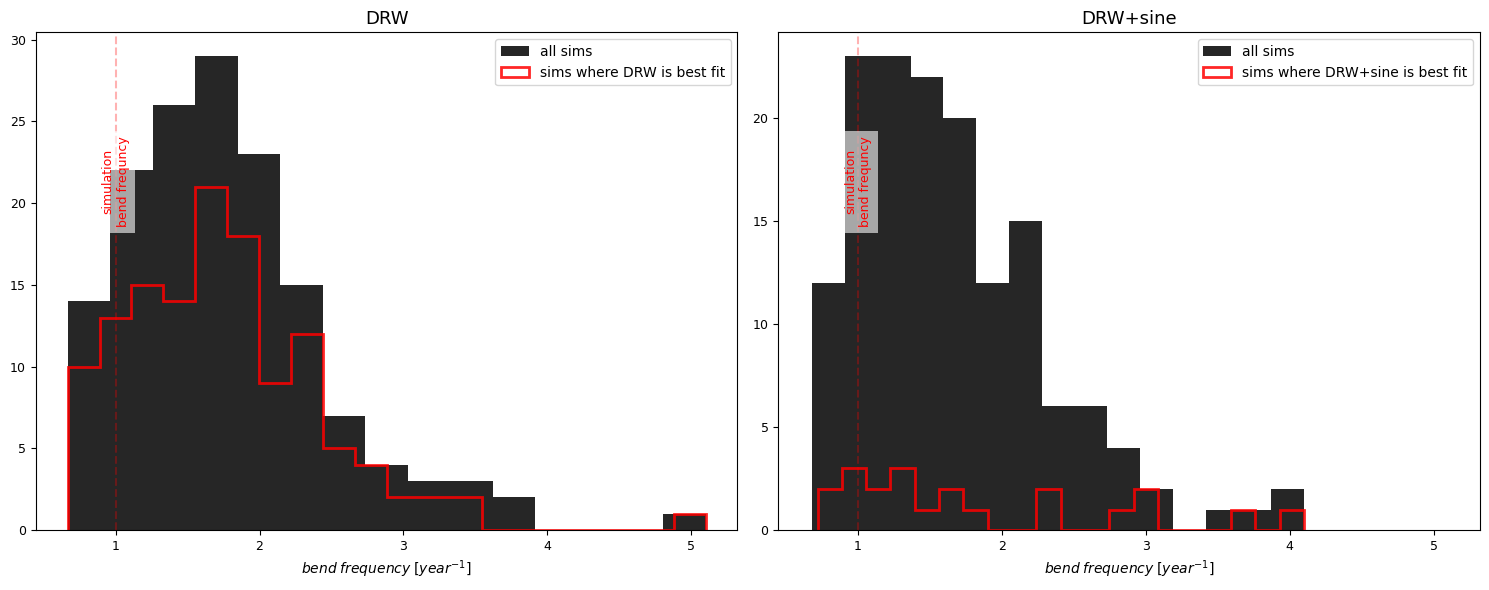

In [47]:

fig, ax = plt.subplots(1,2, figsize=[15, 6], sharex=True)
#plt.plot( simDATA[0:101].DRW_bf*365 , np.ones(len(simDATA[0:101].DRW_bf)), 'k.', label='')
ax[0].hist( simDATA[1:150].DRW_bf*365, bins=15, histtype='bar', label='all sims',  alpha=0.85, color='k')
ax[0].hist( simDATA[1:150].loc[simDATA.model1=='DRW'].DRW_bf*365, bins=20, histtype='step', lw=2, label='sims where DRW is best fit',  alpha=0.85, color='r')
ax[0].legend()

ax[1].hist( simDATA[1:150].DRWsine_bf*365, bins=15, histtype='bar', label='all sims', alpha=0.85, color='k')
ax[1].hist( simDATA[1:150].loc[simDATA.model1=='DRWsine'].DRWsine_bf*365, bins=20, histtype='step', lw=2, label='sims where DRW+sine is best fit', alpha=0.85, color='r')
ax[1].legend()


titles = ['DRW','DRW+sine']

for i in range(2):
    plot_vertical_line(ax[i], 1, 'simulation\nbend frequncy', ypos=0.7, textalpha=1, boxalpha=0.6)
    #ax[i][j].axvline(1, color='r')
    if i!=2:
        ax[i].set_xlabel(r'$bend\;frequency\;[year^{-1}]$', fontsize=10)
    else:
        ax[i].set_xlabel(r'$frequency\;[year^{-1}]$', fontsize=10)
    ax[i].tick_params(labelsize=9)
    ax[i].set_title(titles[i],fontsize=13)
    #ax[i][j].legend()
    
plt.tight_layout()
#plt.suptitle('Bend frequency reproduction', fontsize=19, )
#plt.savefig('plots/bendFreq_diffSAMP.png')
plt.show()


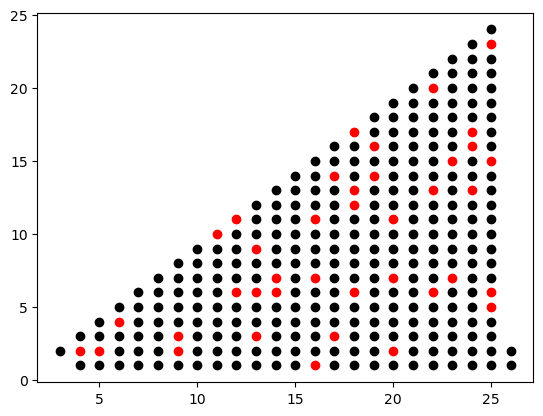

In [38]:
plt.plot(simDATA[0:301].loc[simDATA.model1=='DRW'].OBSperiod*4, simDATA[0:301].loc[simDATA.model1=='DRW'].WINDOWwidth/7,'ko', label = 'DRW')
plt.plot(simDATA[0:301].loc[simDATA.model1=='DRWsine'].OBSperiod*4, simDATA[0:301].loc[simDATA.model1=='DRWsine'].WINDOWwidth/7,'ro', label = 'DRWsine')

In [27]:
simDATA

,ID,simSEED,sampleSEED,rms,noiseSIGMA,bendfreq,lowalpha,highalpha,sharpness,NightsperWINDOW,NumofWINDOW,dataLOSSfrac,OBSperiod,WINDOWwidth,DRW_bf,DRWsine_bf,DRW_logZ,DRWsine_logZ,model1,model2
0,1000.0,17116.0,98941.0,0.15,0.015,0.00274,-1.0,-2.5,10.0,20,8,0.2,0.75,7,-99.000000,-99.000000,-99,-99,nan,nan
1,1001.0,27309.0,59699.0,0.15,0.015,0.00274,-1.0,-2.5,10.0,20,8,0.2,0.75,14,0.006570,0.005148,318.366443,316.519008,DRW,DRWsine
2,1002.0,26240.0,62372.0,0.15,0.015,0.00274,-1.0,-2.5,10.0,20,8,0.2,1.00,7,0.005216,0.004192,322.409615,319.27386,DRW,DRWsine
3,1003.0,44044.0,45699.0,0.15,0.015,0.00274,-1.0,-2.5,10.0,20,8,0.2,1.00,14,0.005668,0.006621,316.12623,316.327437,DRWsine,DRW
4,1004.0,37433.0,18831.0,0.15,0.015,0.00274,-1.0,-2.5,10.0,20,8,0.2,1.00,21,0.004414,0.003700,320.758105,317.987398,DRW,DRWsine
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774,1774.0,58923.0,46915.0,0.15,0.015,0.00274,-1.0,-2.5,10.0,20,8,0.2,10.00,245,-99.000000,-99.000000,-99,-99,nan,nan
775,1775.0,50081.0,28962.0,0.15,0.015,0.00274,-1.0,-2.5,10.0,20,8,0.2,10.00,252,-99.000000,-99.000000,-99,-99,nan,nan
776,1776.0,41373.0,62890.0,0.15,0.015,0.00274,-1.0,-2.5,10.0,20,8,0.2,10.00,259,-99.000000,-99.000000,-99,-99,nan,nan
777,1777.0,55452.0,97821.0,0.15,0.015,0.00274,-1.0,-2.5,10.0,20,8,0.2,10.00,266,-99.000000,-99.000000,-99,-99,nan,nan


In [23]:
def sine_model(A1, A2, t0, time = None ):
    
    return A1* jnp.cos(2*jnp.pi*time/t0) + A2* jnp.sin(2*jnp.pi*time/t0) 

def sine_model_JAX(params, time):
    
    return params['A1']* jnp.cos(2*jnp.pi*time/params['t0']) + params['A2']* jnp.sin(2*jnp.pi*time/params['t0']) 

def build_gp(theta, X, diag, mean_val = 0):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    amp = theta["amps"]
    scale = theta["scales"]
    err_scale = theta['err_scale']

    kernel = amp * kernels.Exp(scale = scale)
    

    return GaussianProcess(kernel, X, diag=(err_scale*diag)**2, mean= mean_val)




def plotter(ModelCOMP_OBJ, plot_samples=True, plot_what='all', savename = 'nan'):
    
    time = ModelCOMP_OBJ.time
    flux = ModelCOMP_OBJ.flux
    fluxerr = ModelCOMP_OBJ.flux_err
    fig, ax = plt.subplots(1,2,figsize=[15,6])
    if plot_what in ['all', 'DRW', 'DRWsine']:
        if ('DRW' in ModelCOMP_OBJ.models()) & ((plot_what=='all') | (plot_what=='DRW')):
            DRW_results = ModelCOMP_OBJ.return_results(name = 'DRW')
            x = np.linspace(min(time)-1, max(time)+1, 1000)
            params = {'amps'  :np.median(DRW_results.samples['amp']),
                    'scales':np.median(DRW_results.samples['scales']),
                    'err_scale':np.median(DRW_results.samples['err_scale'])}
            
            gp = build_gp(params, time, fluxerr, mean_val=0)
            cond_gp = gp.condition(flux, x).gp
            mu, var = cond_gp.loc, cond_gp.variance

            
            if plot_samples:
                ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "r-", lw=1, alpha=0.3)
                ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1042)), "b-", lw=1, alpha=0.3)
                ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1043)), "r-", lw=1, alpha=0.3)
            ax[0].errorbar(time, flux,yerr=fluxerr,fmt='.', color='k' , alpha=0.2)
            ax[0].fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5)

            #print_custom_formatted_dict(params)
            #plt.tight_layout()
            #plt.show()
            
        
        
        if ('DRWsine' in ModelCOMP_OBJ.models()) & ((plot_what=='all') | (plot_what=='DRWsine')):
            DRW_sine_results = ModelCOMP_OBJ.return_results(name='DRWsine')
            
            params = {'A1'  :np.median(DRW_sine_results.samples['A1']),
                    'A2':np.median(DRW_sine_results.samples['A2']),
                    't0':np.median(DRW_sine_results.samples['t0']),
                    'amps'  :np.median(DRW_sine_results.samples['amp']),
                    'scales':np.median(DRW_sine_results.samples['scales']),
                    'err_scale':np.median(DRW_sine_results.samples['err_scale'])}

            t_new = np.linspace(min(time)-1, max(time)+1, 1000)
            gp = build_gp(params, time, fluxerr, mean_val=partial(sine_model_JAX, params))
            cond_gp = gp.condition(flux, t_new).gp
            mu, var = cond_gp.loc, cond_gp.variance

            
            ax[1].errorbar(time,flux,yerr=fluxerr,fmt='.', color='k',alpha = 0.3 )

            #gp_model = cond_gp.sample(jax.random.PRNGKey(1044))

            ax[1].plot(x, jax.vmap(partial(sine_model_JAX, params))(x)  , color="r", lw=3, alpha=1, label = 'Sine in DRW+Sine')
            if plot_samples:
                ax[1].plot(t_new, cond_gp.sample(jax.random.PRNGKey(1043)), 'r-', alpha=0.3)
                ax[1].plot(t_new, cond_gp.sample(jax.random.PRNGKey(1042)), 'b-', alpha=0.3)
                ax[1].plot(t_new, cond_gp.sample(jax.random.PRNGKey(1044)), 'g-', alpha=0.3)
            ax[1].fill_between(t_new, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5)
            #plt.legend(fontsize=14)
            #print_custom_formatted_dict(params)
    plt.tight_layout()
    plt.savefig(savename)
    #plt.show()
    plt.close()
    del time, flux, fluxerr, DRW_results, DRW_sine_results, gp, cond_gp, params

In [19]:
simDATA.loc[simDATA.model1 == "DRWsine"]

,ID,simSEED,sampleSEED,rms,noiseSIGMA,bendfreq,lowalpha,highalpha,sharpness,NightsperWINDOW,NumofWINDOW,OBSperiod,WINDOWwidth,dataLOSSfrac,DRW_bf,DRWsine_bf,DRW_logZ,DRWsine_logZ,model1,model2
2,1002.0,25307.0,18234.0,0.15,0.015,0.00274,-1.0,-2.5,10.0,20,8,6,60,0.2,0.003673,0.004603,277.620483,277.830434,DRWsine,DRW
5,1005.0,65695.0,50726.0,0.15,0.015,0.00274,-1.0,-2.5,10.0,20,8,6,60,0.2,0.003087,0.003077,278.79823,279.049167,DRWsine,DRW
16,1016.0,12494.0,74991.0,0.15,0.015,0.00274,-1.0,-2.5,10.0,20,8,6,60,0.2,0.007382,0.006532,290.48315,290.643786,DRWsine,DRW
20,1020.0,4802.0,87927.0,0.15,0.015,0.00274,-1.0,-2.5,10.0,20,8,6,60,0.2,0.004612,0.004706,288.585079,288.6884,DRWsine,DRW
26,1026.0,41901.0,15614.0,0.15,0.015,0.00274,-1.0,-2.5,10.0,20,8,6,60,0.2,0.003993,0.003615,277.749421,277.919698,DRWsine,DRW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,1975.0,66422.0,64073.0,0.15,0.015,0.00274,-1.0,-2.5,10.0,20,8,6,60,0.2,0.005515,0.005609,270.445776,271.924191,DRWsine,DRW
976,1976.0,87700.0,51709.0,0.15,0.015,0.00274,-1.0,-2.5,10.0,20,8,6,60,0.2,0.001880,0.001943,272.259569,272.477386,DRWsine,DRW
981,1981.0,12290.0,74748.0,0.15,0.015,0.00274,-1.0,-2.5,10.0,20,8,6,60,0.2,0.002921,0.002451,271.303454,274.64875,DRWsine,DRW
982,1982.0,49737.0,55162.0,0.15,0.015,0.00274,-1.0,-2.5,10.0,20,8,6,60,0.2,0.002489,0.003638,268.86604,271.403167,DRWsine,DRW


KeyboardInterrupt: 

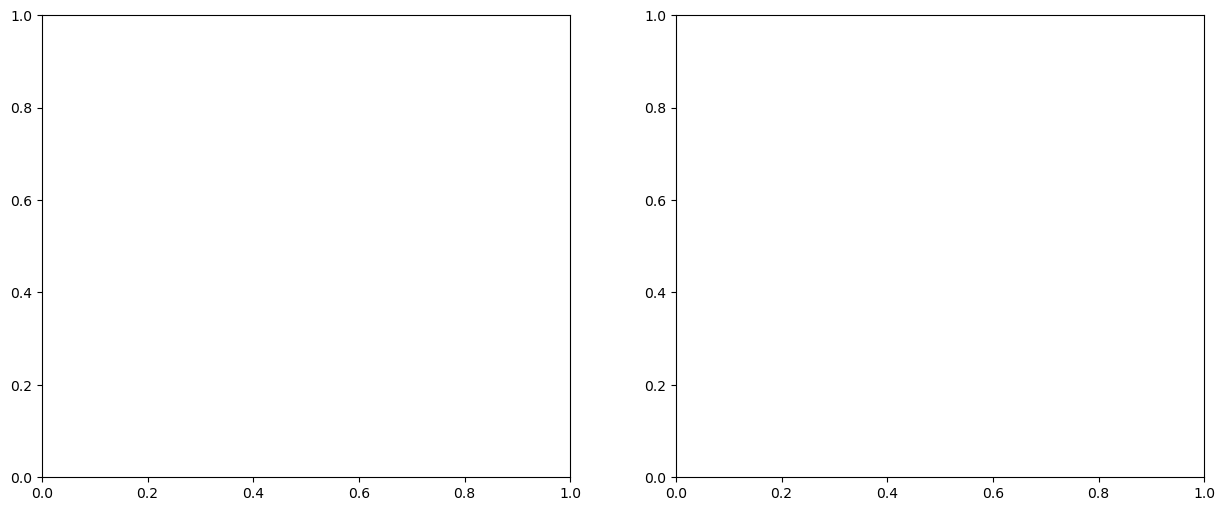

In [24]:
for r, row  in simDATA.loc[simDATA.model1 == "DRWsine"].iterrows():
    
    with open('modelCOMP_objects/DRW_DRWsine/modelCOMP_'+str(int(row.ID))+'.pkl', 'rb') as file:
        ModelLoaded = dill.load(file)
        file.close()
    
    plotter(ModelCOMP_OBJ=ModelLoaded, savename='plots/DRWsineplots/model'+str(int(row.ID))+'png')
    del ModelLoaded
    

AttributeError: 'DataFrame' object has no attribute 'DRW_linear_bf'

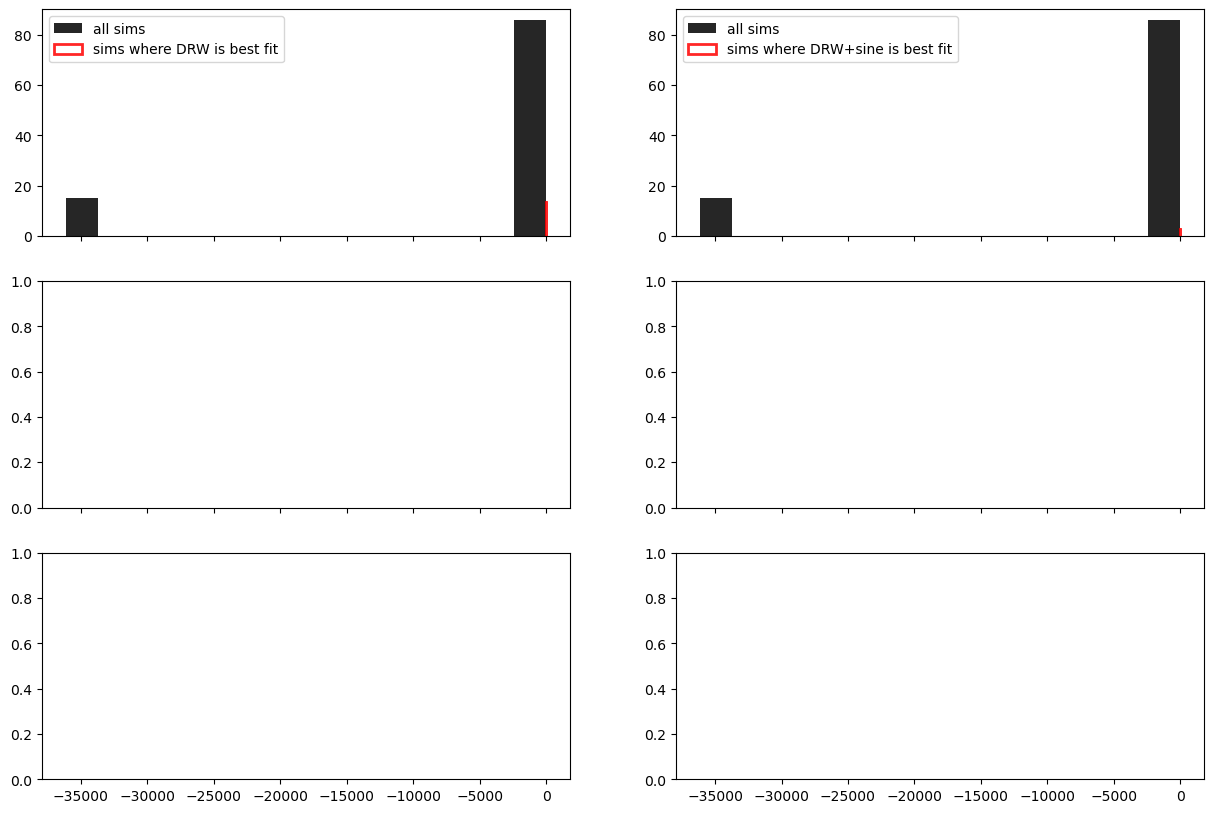

In [27]:

fig, ax = plt.subplots(3,2, figsize=[15, 10], sharex=True)
#plt.plot( simDATA[0:101].DRW_bf*365 , np.ones(len(simDATA[0:101].DRW_bf)), 'k.', label='')
ax[0][0].hist( simDATA[0:101].DRW_bf*365, bins=15, histtype='bar', label='all sims',  alpha=0.85, color='k')
ax[0][0].hist( simDATA[0:101].loc[simDATA.model1=='DRW'].DRW_bf*365, bins=15, histtype='step', lw=2, label='sims where DRW is best fit',  alpha=0.85, color='r')
ax[0][0].legend()

ax[0][1].hist( simDATA[0:101].DRWsine_bf*365, bins=15, histtype='bar', label='all sims', alpha=0.85, color='k')
ax[0][1].hist( simDATA[0:101].loc[simDATA.model1=='DRWsine'].DRWsine_bf*365, bins=15, histtype='step', lw=2, label='sims where DRW+sine is best fit', alpha=0.85, color='r')
ax[0][1].legend()

ax[1][0].hist( simDATA[0:101].DRW_linear_bf*365, bins=15, histtype='bar', label='DRW+linear',  alpha=0.85, color='k')

ax[1][1].hist( simDATA[0:101].DRWsine_linear_bf*365, bins=15, histtype='bar', label='DRWsine+linear', alpha=0.85, color='k')

ax[2][0].hist( simDATA[0:101].sine_freq*365, bins=15, histtype='bar', label='sine',  alpha=0.85, color='k')

ax[2][1].hist( simDATA[0:101].sine_linear_freq*365, bins=15, histtype='bar', label='sine+linear',  alpha=0.85, color='k')

titles = [['DRW','DRW+sine'], ['DRW+linear','DRW+sine+linear'], ['sine', 'sine+linear']]
for i in range(3):
    for j in range(2):
        plot_vertical_line(ax[i][j], 1, 'simulation\nbend frequncy', ypos=0.7, textalpha=1, boxalpha=0.6)
        #ax[i][j].axvline(1, color='r')
        if i!=2:
            ax[i][j].set_xlabel(r'$bend\;frequency\;[year^{-1}]$', fontsize=10)
        else:
            ax[i][j].set_xlabel(r'$frequency\;[year^{-1}]$', fontsize=10)
        ax[i][j].tick_params(labelsize=9)
        ax[i][j].set_title(titles[i][j],fontsize=13)
        #ax[i][j].legend()
        
plt.tight_layout()
#plt.suptitle('Bend frequency reproduction', fontsize=19, )
plt.savefig('plots/bendFreq_dist.png')
plt.show()


In [264]:
print(list(simDATA[0:101].model1.value_counts().values),list(simDATA[0:101].model1.value_counts().index))
print(list(simDATA[0:101].model2.value_counts().values),list(simDATA[0:101].model2.value_counts().index))
print(list(simDATA[0:101].model3.value_counts().values),list(simDATA[0:101].model3.value_counts().index))
print(list(simDATA[0:101].model4.value_counts().values),list(simDATA[0:101].model4.value_counts().index))
print(list(simDATA[0:101].model5.value_counts().values),list(simDATA[0:101].model5.value_counts().index))
print(list(simDATA[0:101].model6.value_counts().values),list(simDATA[0:101].model6.value_counts().index))




[85, 16] ['DRW', 'DRWsine']
[85, 16] ['DRWsine', 'DRW']
[87, 14] ['DRW_linear', 'DRWsine_linear']
[87, 14] ['DRWsine_linear', 'DRW_linear']
[101] ['sine_linear']
[101] ['sine']


INFO[2023-11-30 14:02:39,133]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO[2023-11-30 14:02:39,135]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO[2023-11-30 14:02:39,145]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO[2023-11-30 14:02:39,153]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO[2023-11-30 14:02:39,160]: Using categorical units to plot a list of strings that are all parsable as floats or 

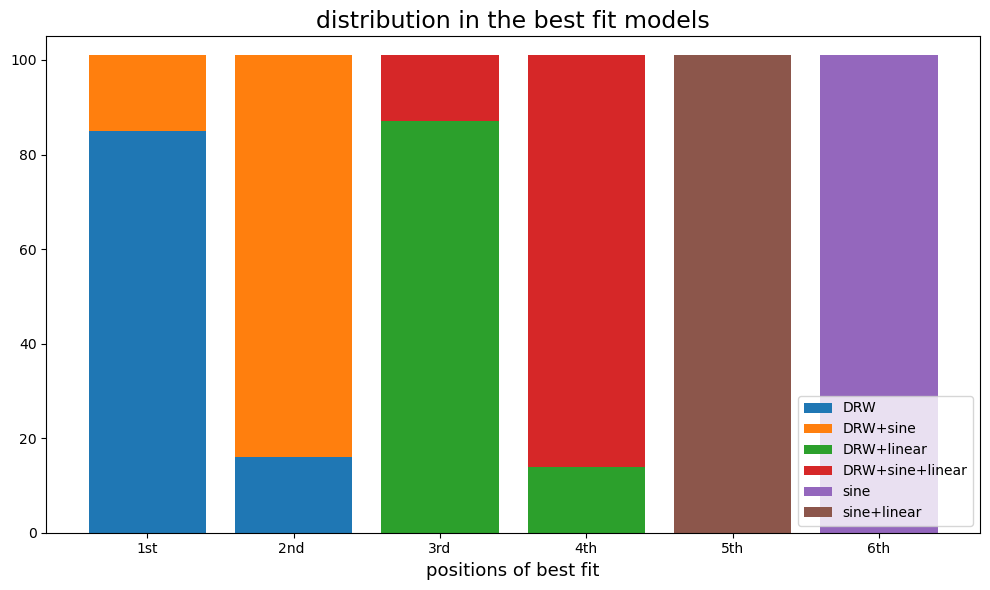

In [276]:
titles = ['1st','2nd ','3rd','4th', '5th', '6th']
DRW = [85, 16, 0, 0, 0, 0]
DRWsine = [16, 85, 0, 0, 0, 0]
DRW_linear = [0, 0, 87, 14, 0, 0]
DRWsine_linear = [0, 0, 14, 87, 0, 0]
sine = [0, 0, 0, 0, 0, 101]
sine_linear = [0, 0, 0, 0, 101, 0]

plt.figure(figsize=[10,6])
plt.bar(titles, DRW, label = 'DRW' ,  )
plt.bar(titles, DRWsine,  bottom=DRW , label = 'DRW+sine'   )
plt.bar(titles, DRW_linear,  bottom=DRWsine,label = 'DRW+linear'   )
plt.bar(titles, DRWsine_linear,  bottom=DRW_linear, label = 'DRW+sine+linear'   )
plt.bar(titles, sine,bottom= DRWsine_linear, label = 'sine'   )
plt.bar(titles, sine_linear, bottom=sine, label = 'sine+linear'   )
plt.legend()
#plt.grid(axis='y')
plt.xlabel('positions of best fit', fontsize=13)
plt.title('distribution in the best fit models', fontsize=17)
plt.legend()
plt.ylim(0, 105)
plt.tight_layout()
plt.savefig('plots/bestFitdistribution.png')
plt.show()

In [24]:
ModelLoaded.pretty_print()

+-----------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+
|                       |             DRW              |          DRW_linear          |             sine             |         sine_linear          |           DRWsine            |        DRWsine_linear        |
+-----------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+
|  Number of Parameters |              3               |              5               |              4               |              6               |              6               |              8               |
| Termination condition | ['Small remaining evidence'] | ['Small remaining evidence'] | ['Small remaining evidence'] | ['Small remaining evidence'] | ['

amps      : 0.013475337453018061
scales    : 0.7587720585779723
err_scale : 1.155336436926985


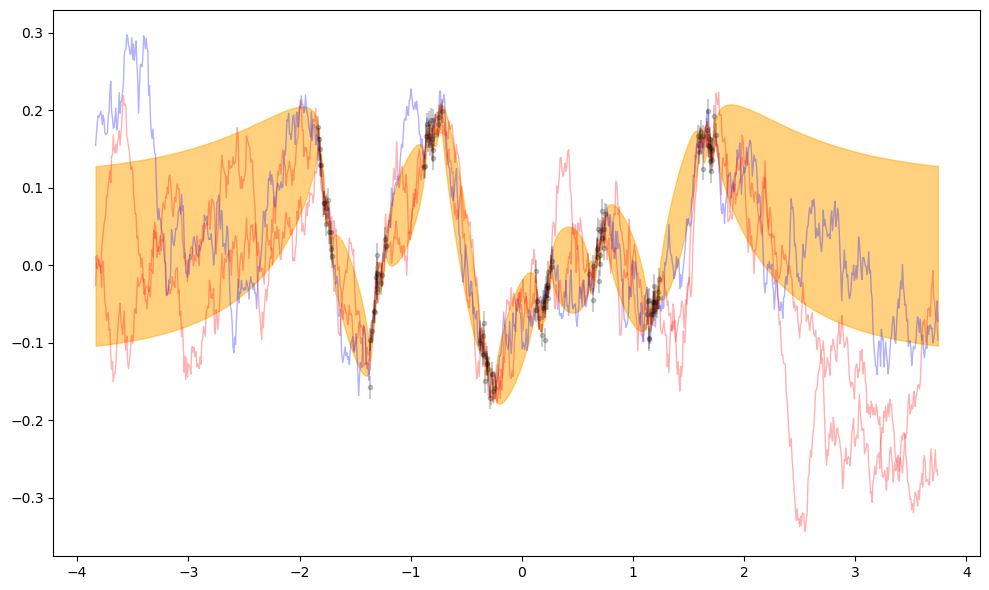

A1        : -0.08183973598542235
A2        : 0.09026210588425805
t0        : 1.2129606491511449
err_scale : 0.9926951313825342


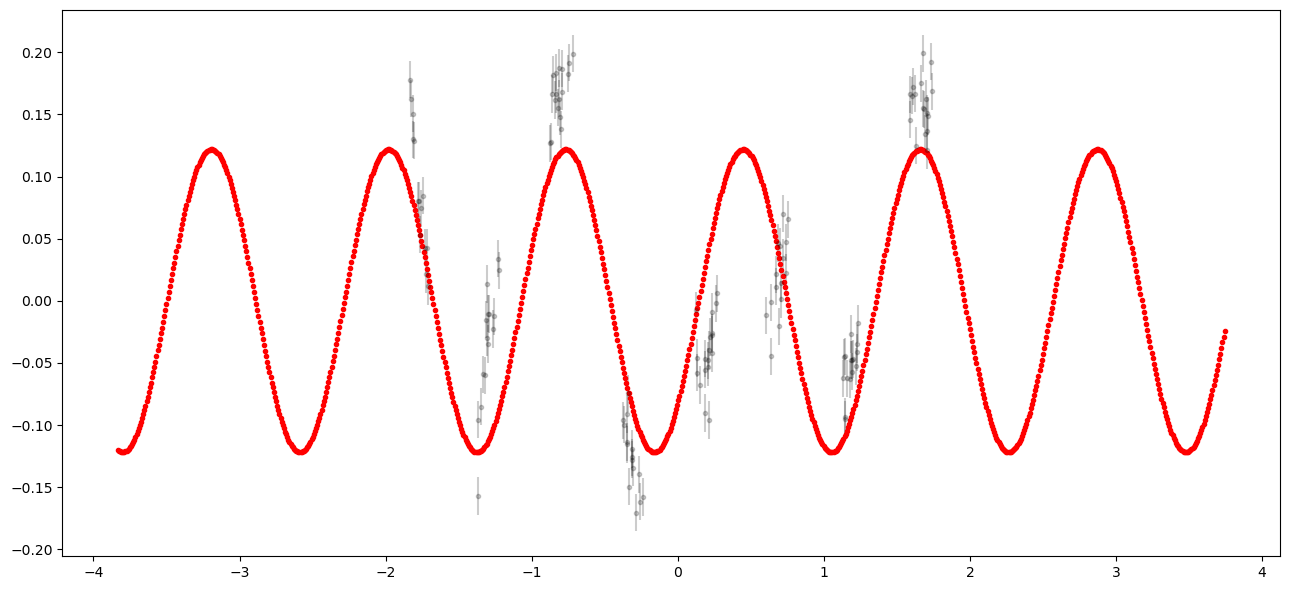

A1        : -0.07634054573431427
A2        : 0.0877374571308479
t0        : 1.2546837635551533
amps      : 0.009166150014754891
scales    : 0.6562797785537708
err_scale : 1.1897315776703208


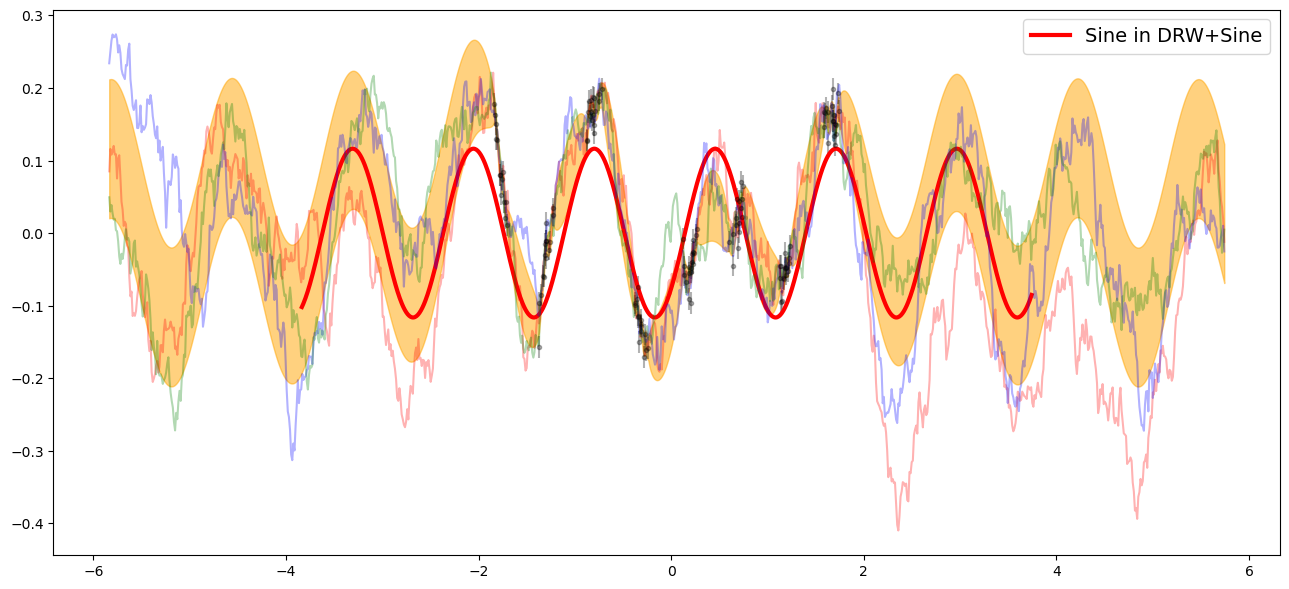

In [35]:
plotter(ModelLoaded, lcTIME, lcFLUX, lcFLUXerr)

## SIM 2 : single bent power law + lorentzian

6
0.006944444444444445


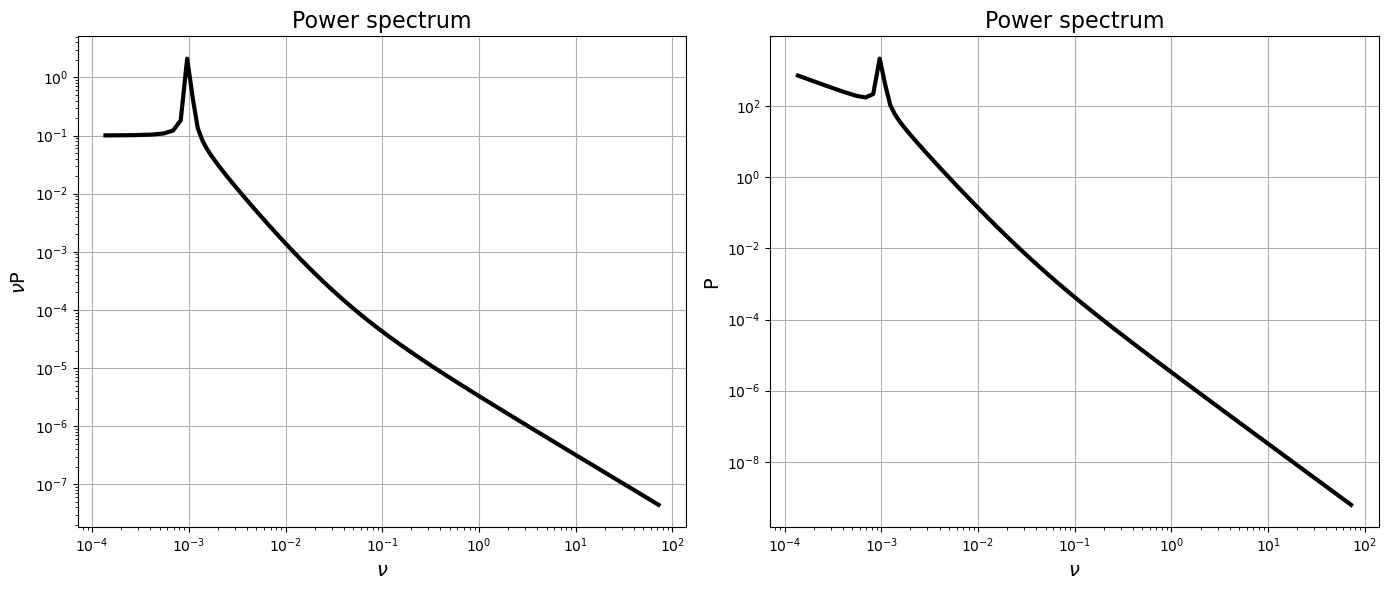

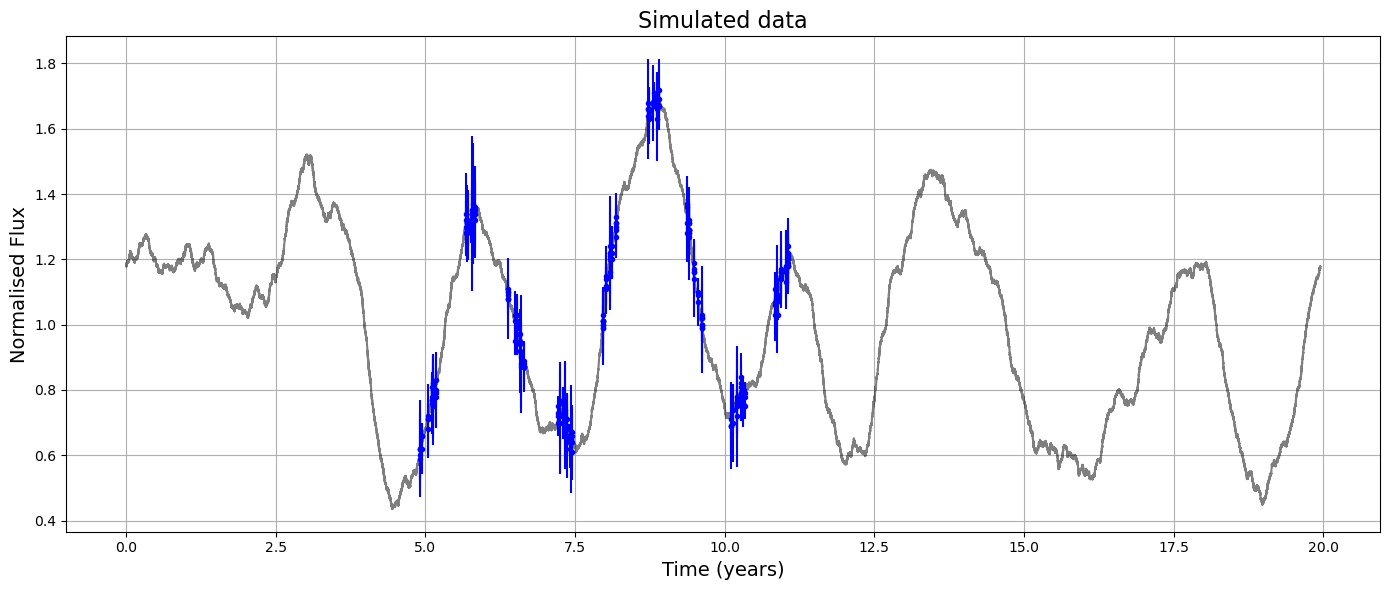

In [163]:

simulator_seed = 6
print(simulator_seed)
#sampler seed = 10000
l = LightCurveSampler(N=2**20, mean=1 ,rms=0.3, simulatorSEED= simulator_seed, verbose=False)
l.load_powerspec(bend_pl_lorentz, [100.0, 1e-3, -1,-3,  5, 2, 1e-3, 100], plot=True)
simTIME, simLC, simLCerr ,lc = l.monsterr(WindowNum=9, gaplength=5, windowLength=4, samplerSEED=10000, dataLOSSfrac=0.3, noiseSIGMA=0.02)


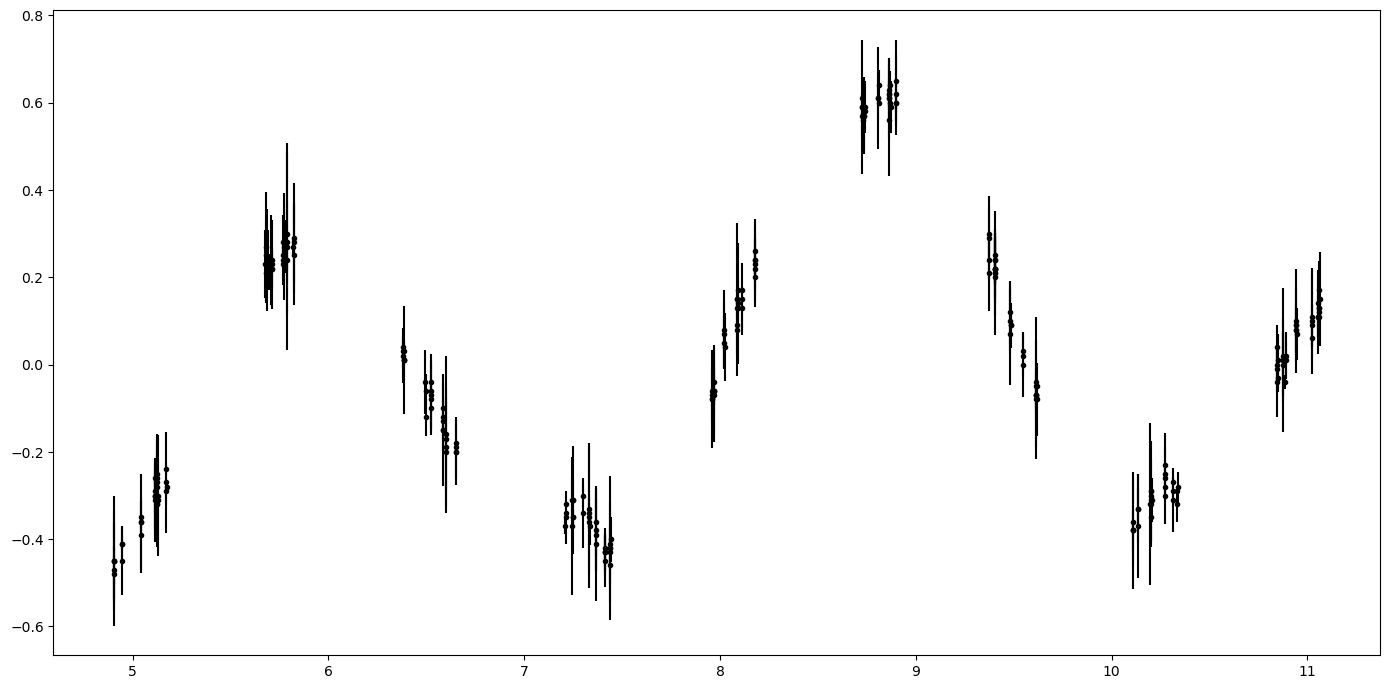

In [172]:
plt.figure(figsize=[14, 7])
plt.errorbar(simTIME, simLC-np.median(simLC), yerr=simLCerr, fmt='.k')
plt.tight_layout()
plt.show()

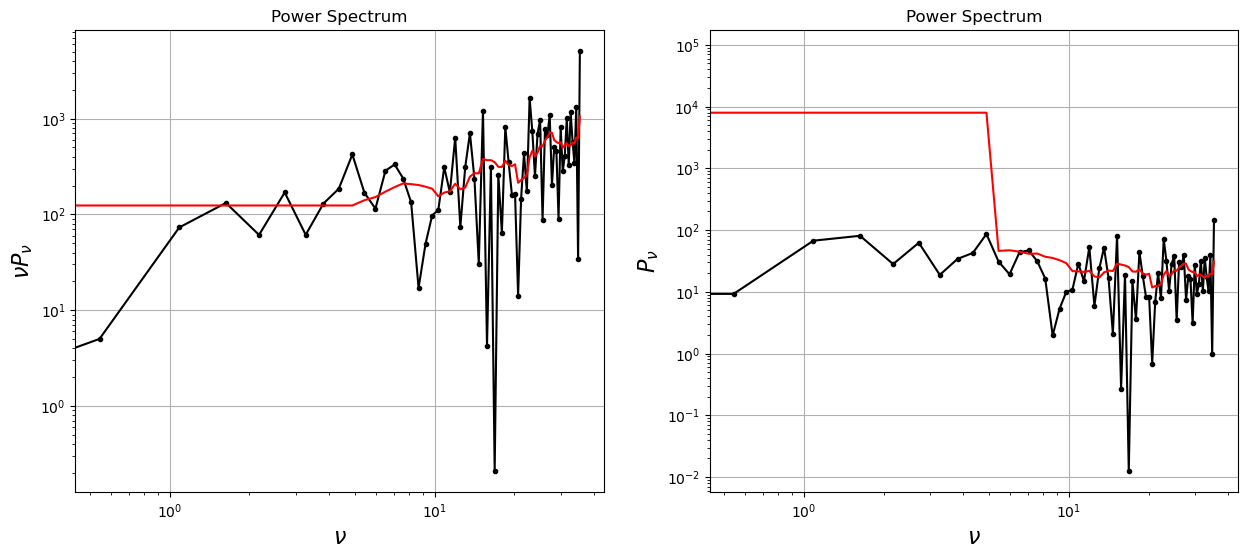

In [167]:
recon_powSPEC(simLC, simTIME, dt = lc.time[1]-lc.time[0])

### NS models aka "Nice models"

#### DRW model

In [21]:
#DRW MODEL
def DRW_generative_prior():
    amp = yield jaxns.Prior( tfpd.LogNormal(-4, 0.9), name = 'amp')
    scale = yield jaxns.Prior( tfpd.LogNormal(-0.6, 0.9), name = 'scales')
    err_scale = yield jaxns.Prior(tfpd.Uniform(0,1.5), name='err_scale')
    
    return amp, scale, err_scale

def DRW_log_likelihood_model(amp, scales, err_scale, time = None, y = None, y_errs = None ):
    
    kernel = amp * kernels.Exp(scale = scales)
    
    gp = GaussianProcess(kernel, time, diag=(err_scale*y_errs)**2, mean=0)
    
    return gp.log_probability(y)


#### Sine model

In [22]:
# Sine model
def sine_model(A1, A2, t0, time = None ):
    
    return A1* jnp.cos(2*jnp.pi*time/t0) + A2* jnp.sin(2*jnp.pi*time/t0) 

def sine_log_likelihood_model(A1, A2, t0, nu, time = None, y = None, y_errs = None):
    
    loglikeli = - (y - sine_model(A1, A2, t0, time ))**2/(2*(nu*y_errs)**2) - jnp.log(jnp.sqrt(2*jnp.pi)*y_errs*nu)
    return jnp.sum(loglikeli)

def sine_generative_prior():
    
    A1 = yield jaxns.Prior( tfpd.Normal(0,0.3), name = 'A1')
    A2 = yield jaxns.Prior( tfpd.Normal(0,0.3), name = 'A2')
    t0 = yield jaxns.Prior( tfpd.Uniform(0, 12), name ='t0')
    nu = yield jaxns.Prior( tfpd.Uniform(0.0, 1.), name = 'nu')
    
    return A1, A2, t0, nu


#### DRW + sine model

In [23]:

def DRW_sine_generative_prior():
    amp = yield jaxns.Prior( tfpd.LogNormal(-4, 0.9), name = 'amp')
    scale = yield jaxns.Prior( tfpd.LogNormal(-0.6, 0.9), name = 'scales')
    err_scale = yield jaxns.Prior(tfpd.Uniform(0,1.5), name='err_scale')
    A1 = yield jaxns.Prior( tfpd.Normal(0,0.3), name = 'A1')
    A2 = yield jaxns.Prior( tfpd.Normal(0,0.3), name = 'A2')
    t0 = yield jaxns.Prior( tfpd.Uniform(0, 12), name ='t0')
    #nu = yield jaxns.Prior( tfpd.Uniform(0.0, 1.), name = 'nu')
    
    return amp, scale, err_scale, A1, A2, t0 #nu


def sine_curve_model(params, time):
    
    return params['A1']* jnp.cos(2*jnp.pi*time/params['t0']) + params['A2']* jnp.sin(2*jnp.pi*time/params['t0']) 


def DRW_sine_log_likelihood_model(amp, scales, err_scale, A1, A2, t0 , time = None, y = None, y_errs = None):
    
    kernel = amp * kernels.Exp(scale = scales)
    
    mean_params = {'A1': A1, 'A2':A2, 't0':t0}
    
    gp = GaussianProcess(kernel, time, diag=(err_scale*y_errs)**2, mean= partial(sine_curve_model, mean_params) )
    
    return gp.log_probability(y)


### Sampling

In [24]:

lcTIME = simTIME
lcFLUX = simLC - np.median(simLC)
lcFLUXerr = simLCerr

modelCreater = JAXNSmodelCreator(lcTIME, lcFLUX, lcFLUXerr)

DRW_NSmodel = modelCreater.create_model(DRW_generative_prior, DRW_log_likelihood_model)
sine_NSmodel = modelCreater.create_model(sine_generative_prior, sine_log_likelihood_model)
DRW_sine_NSmodel = modelCreater.create_model(DRW_sine_generative_prior, DRW_sine_log_likelihood_model)
ModelCOMP = ModelComparison(lcTIME, lcFLUX,lcFLUXerr, verbose=True)
ModelCOMP.add_NestedModel(DRW_NSmodel, 'DRW')
ModelCOMP.add_NestedModel(sine_NSmodel, 'sine')
ModelCOMP.add_NestedModel(DRW_sine_NSmodel, 'DRWsine')
ModelCOMP.run_NSsampler()

Model Comparion object created.
JAXNS model added.
JAXNS model added.
JAXNS model added.
Total number of models being sampled :  3
--------------------------------------------------------------------------
Model being sampled :  DRW
-------------------------------------------------------------------------
ExactNestedSampler Created. 
Sampling inititated.
Sampling finished.
TerminationCondition :  Small remaining evidence


Model being sampled :  sine
-------------------------------------------------------------------------
ExactNestedSampler Created. 
Sampling inititated.
Sampling finished.
TerminationCondition :  Small remaining evidence


Model being sampled :  DRWsine
-------------------------------------------------------------------------
ExactNestedSampler Created. 
Sampling inititated.
Sampling finished.
TerminationCondition :  Small remaining evidence




### Comparsion

In [25]:
ModelCOMP.pretty_print()

+-----------------------+------------------------------+------------------------------+------------------------------+
|                       |             DRW              |             sine             |           DRWsine            |
+-----------------------+------------------------------+------------------------------+------------------------------+
|  Number of Parameters |              3               |              4               |              6               |
| Termination condition | ['Small remaining evidence'] | ['Small remaining evidence'] | ['Small remaining evidence'] |
|          logZ         |      454.48784188603923      |     -12815.699810989885      |      460.19905576063303      |
|           H           |    6.387473083041189e+199    |      12815.699810989885      |    3.345004136665119e+204    |
|          ESS          |      467.7421597629315       |      552.8942771175621       |      554.8705946574021       |
+-----------------------+-----------------------

amps      : 0.06864050447072295
scales    : 0.6200056901970659
err_scale : 0.43457220691815707


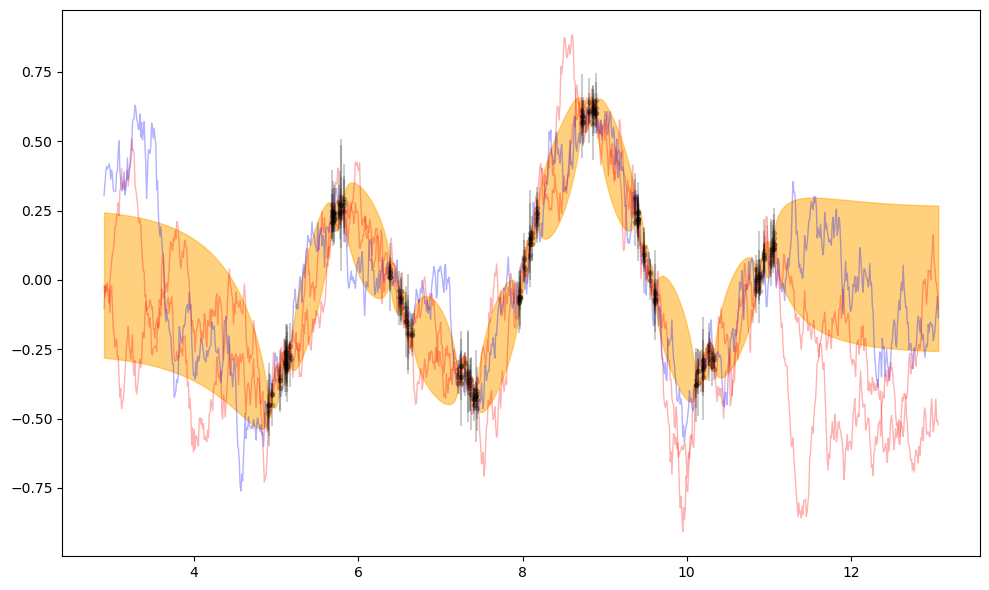

A1        : 0.2604370390006096
A2        : -0.2210283573881061
t0        : 2.9887404799447284
err_scale : 0.9970630357875515


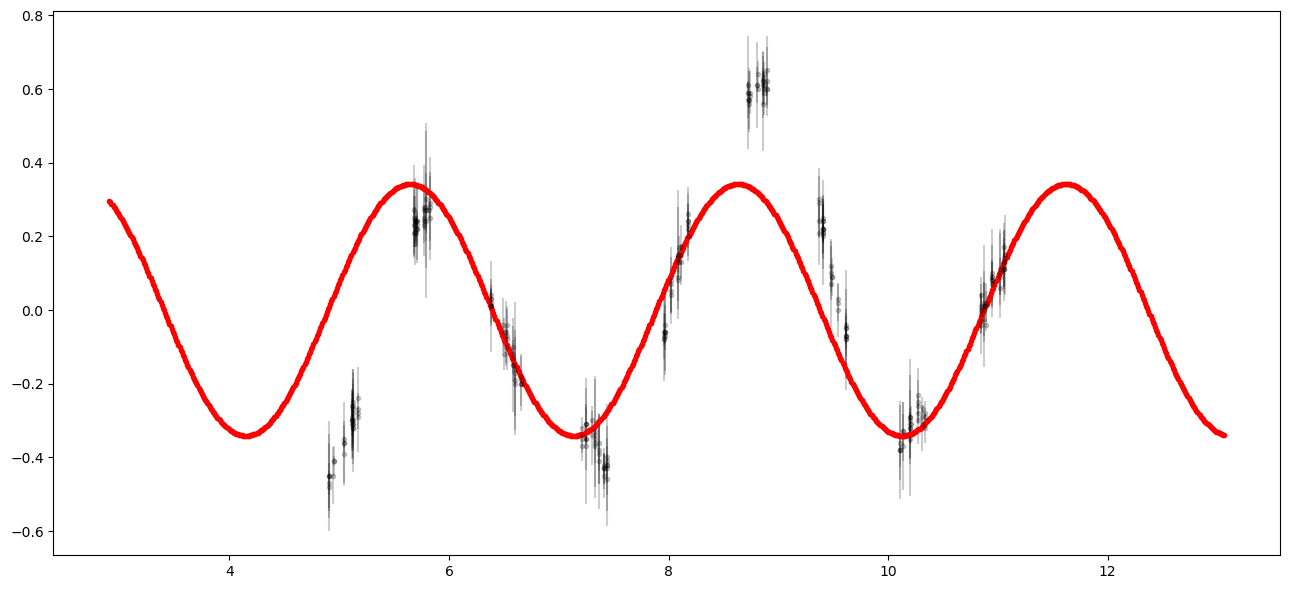

A1        : 0.13568481796780152
A2        : 0.22251232650627736
t0        : 2.835750089534856
amps      : 0.0359018265692365
scales    : 0.5058836310929317
err_scale : 0.4798506146882472


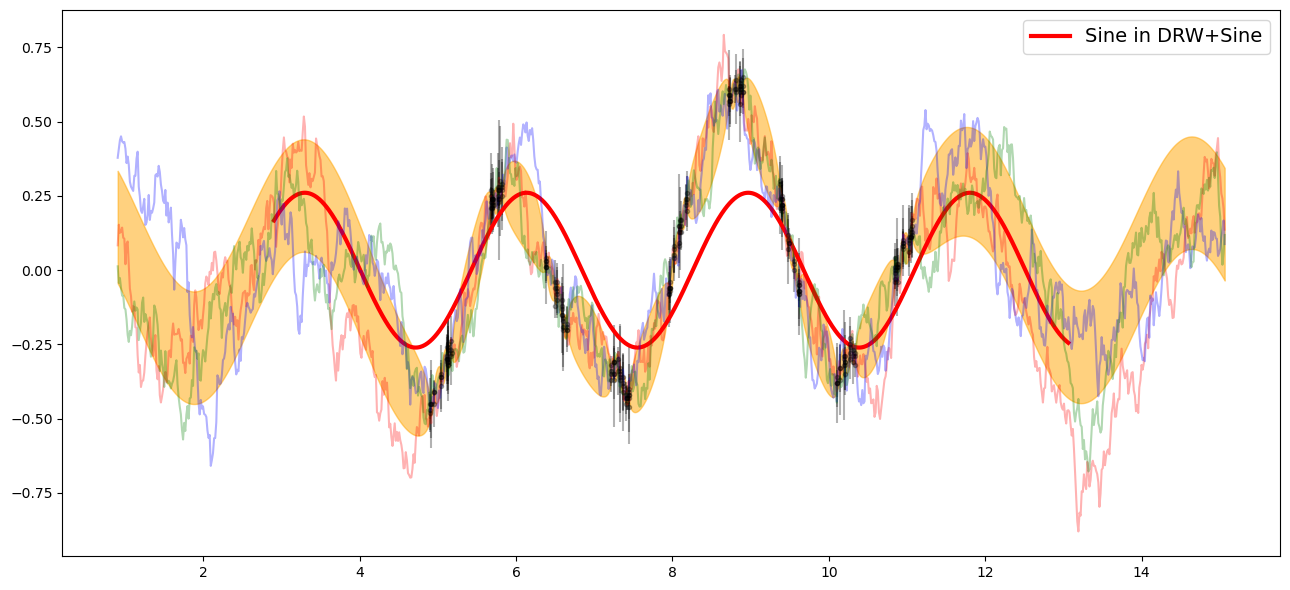

In [27]:
plotter(ModelCOMP, lcTIME, lcFLUX, lcFLUXerr)

In [1]:
import jax

## Time cals

In [38]:
import json
import pandas as pd
import numpy as np

In [36]:
with open('time_dict1000.json') as json_file:
    time_dict = json.load(json_file)
    
    time_values = np.array(list(time_dict.values()))
    
pd.DataFrame({'checkpoints':list(time_dict.keys())[1:], 'Time taken':list(time_values[1:] -time_values[0:-1])} )

,checkpoints,Time taken
0,after_load_powerspec,0.000110
1,after_LCsim,0.437328
2,after_sampling,0.000334
3,after_modelcreation,0.000139
4,after_modelAddition,0.000010
5,after_DRWsampling,16.637948
6,after_DRWsineSampling,39.416395
7,after_CARMA21sampling,11.998440
8,after_NSsampling,0.000001


In [37]:
with open('time_dict1001.json') as json_file:
    time_dict = json.load(json_file)
    
    time_values = np.array(list(time_dict.values()))
    
pd.DataFrame({'checkpoints':list(time_dict.keys())[1:], 'Time taken':list(time_values[1:] -time_values[0:-1])} )

,checkpoints,Time taken
0,after_load_powerspec,0.000068
1,after_LCsim,0.444273
2,after_sampling,0.000346
3,after_modelcreation,0.000181
4,after_modelAddition,0.000010
5,after_DRWsampling,15.960436
6,after_DRWsineSampling,38.135016
7,after_CARMA21sampling,11.214264
8,after_NSsampling,0.000001


In [41]:
with open('time_dict_jupy1001.json') as json_file:
    time_dict = json.load(json_file)
    
    time_values = np.array(list(time_dict.values()))
    
pd.DataFrame({'checkpoints':list(time_dict.keys())[1:], 'Time taken':list(time_values[1:] -time_values[0:-1])} )

,checkpoints,Time taken
0,after_load_powerspec,0.000071
1,after_LCsim,0.477180
2,after_sampling,0.000309
3,after_modelcreation,0.000178
4,after_modelAddition,0.000011
5,after_DRWsampling,17.945794
6,after_DRWsineSampling,41.285320
7,after_CARMA21sampling,14.033844
8,after_NSsampling,0.000001


In [40]:
with open('time_dict_jupy1000.json') as json_file:
    time_dict = json.load(json_file)
    
    time_values = np.array(list(time_dict.values()))
    
pd.DataFrame({'checkpoints':list(time_dict.keys())[1:], 'Time taken':list(time_values[1:] -time_values[0:-1])} )

,checkpoints,Time taken
0,after_load_powerspec,0.000150
1,after_LCsim,0.534293
2,after_sampling,0.000346
3,after_modelcreation,0.000150
4,after_modelAddition,0.000008
5,after_DRWsampling,18.723319
6,after_DRWsineSampling,41.428511
7,after_CARMA21sampling,13.114486
8,after_NSsampling,0.000002


## CARMA explore

In [10]:
def CARMA_PSD_pq(params, freq):
    key_list = np.array(list(params.keys()))

    alpha_keys = search_elements_with_pattern(key_list, 'alpha')
    beta_keys = search_elements_with_pattern(key_list, 'beta')
    sigma = jnp.exp(params[search_elements_with_pattern(key_list, 'sigma')[0]])

    alpha_vals = []
    for key in alpha_keys:
        alpha_vals.append(params[key])
    alpha_vals =list(jnp.exp(np.array(alpha_vals)))
    
    alpha_vals.append(1)
    
    beta_vals = [1]
    for key in beta_keys:
        beta_vals.append(params[key])
        
    beta_vals = list(jnp.exp(np.array(beta_vals)))
    p = len(alpha_keys)
    q = len(beta_keys)
    #print(p,q)
    num = 0 
    denom = 0

    for i in range(q+1):
        num = num + (beta_vals[i]*(2*np.pi*1j* freq)**i )
    for u in range(p+1):
        denom = denom + (alpha_vals[u]*(2*np.pi*1j* freq)**u )

    PSD = sigma**2 *  (np.abs(num)**2)/(np.abs(denom)**2)
    
    return PSD

In [11]:
from NSmodels import *

In [12]:
print(create_CARMA_JAXNS_model_funcs(2,1, 'prior').__source__)
print("\n")
print(create_CARMA_JAXNS_model_funcs(2,1, 'likelihood').__source__)

def CARMA21_generative_prior(time=None):
    log_alpha0 = yield jaxns.Prior( tfpd.Uniform(np.log10(1/(time[-1]-time[0])),np.log10( 1/np.min(np.diff(time)))), name = 'log_alpha0')
    log_alpha1 = yield jaxns.Prior( tfpd.Uniform(np.log10(1/(time[-1]-time[0])),np.log10( 1/np.min(np.diff(time)))), name = 'log_alpha1')
    log_beta1 = yield jaxns.Prior( tfpd.Uniform(-7, 2.5), name = 'log_beta1')
    log_sigma = yield jaxns.Prior( tfpd.Uniform(-3, 5.3), name = 'log_sigma')
    err_scale = yield jaxns.Prior(tfpd.Uniform(0,1.5), name='err_scale')

    return log_alpha0, log_alpha1, log_beta1, log_sigma, err_scale


def CARMA21_log_likelihood_model(log_alpha0, log_alpha1, log_beta1, log_sigma, err_scale, time = None, y = None, y_errs = None):

    kernel = kernels.quasisep.CARMA.init(alpha=[jnp.exp(log_alpha0), jnp.exp(log_alpha1), ], 
                                 beta=[jnp.exp(log_sigma) * 1, jnp.exp(log_sigma) * jnp.exp(log_beta1), ])

    gp = GaussianProcess(kernel, time, diag=(err_sca

In [13]:
from scipy.stats import loguniform, uniform
from scipy.optimize import curve_fit, least_squares


In [14]:
def param_gen(p, q, alpha_range = [-7, 2.5], beta_range = [-7, 2.5], sigma_range = [-3, 5.3]):
    
    param_dict = {}
    for i in range(p):
        param_dict['log_alpha'+str(i)] = uniform.rvs(alpha_range[0], alpha_range[1] - alpha_range[0])
    
    for i in range(q):
        param_dict['log_beta'+str(i+1)] = uniform.rvs(beta_range[0], beta_range[1] - beta_range[0])    
        
    param_dict['log_sigma'] = uniform.rvs(sigma_range[0], sigma_range[1] -sigma_range[0])
    
    return param_dict

In [15]:
def bend_pl(f, norm, f_bend, alph_lo, alph_hi, sharpness):
    '''
    Function for bend power_law creation
    '''
    powmod = (norm*(f/f_bend)**alph_lo)/(1.+(f/f_bend)**(sharpness*(alph_lo-alph_hi)))**(1./sharpness)
    return powmod

def bend_pl_log(f, norm, f_bend, alph_lo, alph_hi):
    '''
    Function for bend power_law creation
    '''
    
    powmod = norm + alph_lo * f - alph_lo*f_bend - np.log10(1 + (f**10/f_bend**10)**(alph_lo-alph_hi))
    
    return powmod

def power_law_log(freq, alpha, amp):
    
    return amp + freq*alpha

def residual(params, f, powmod_data):
    norm, f_bend, alph_lo, alph_hi, sharpness = params
    model = bend_pl(f, norm, f_bend, alph_lo, alph_hi, sharpness)
    return model - powmod_data

def residual_log_bend(params, f, powmod_data):
    norm, f_bend, alph_lo, alph_hi = params
    model = bend_pl_log(f, norm, f_bend, alph_lo, alph_hi)
    return model - powmod_data

def residual_powerlaw(params, f, powmod_data):
    alpha, amp = params
    model = power_law_log(f, alpha, amp)
    return model - powmod_data


In [21]:
tfpd.Uniform(1,2, )

<tfp.distributions.Uniform 'Uniform' batch_shape=[] event_shape=[] dtype=float32>

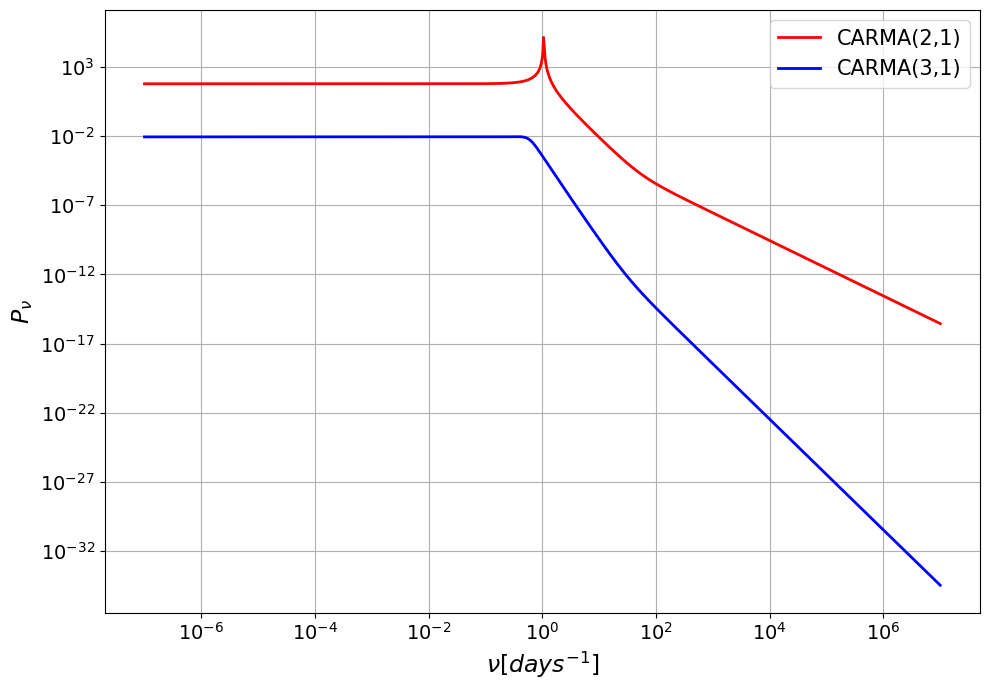

In [116]:
freq = np.logspace(-7,7,1000)

plt.figure(figsize=[10,7])


psd = []
psd_data = {'freq' : [], 'psd' : []}
for i in range(1):
    PSD = CARMA_PSD_pq(param_gen(2,1 , alpha_range=[-7,7], beta_range=[-7,7]), freq)
    psd_data['freq'] = np.concatenate([psd_data['freq'], freq])
    psd.append(PSD)
    psd_data['psd'] =np.concatenate([psd_data['psd'], PSD])
    plt.plot(freq , PSD,
                'k-', alpha=0.04)
    
psd =  np.median(psd, axis=0)
plt.plot(freq, psd, 'r-', lw=2, label = 'CARMA(2,1)')


psd = []
psd_data = {'freq' : [], 'psd' : []}
for i in range(1):
    PSD = CARMA_PSD_pq(param_gen(3,1 , alpha_range=[-7,7], beta_range=[-7,7]), freq)
    psd_data['freq'] = np.concatenate([psd_data['freq'], freq])
    psd.append(PSD)
    psd_data['psd'] =np.concatenate([psd_data['psd'], PSD])
    plt.plot(freq , PSD,
                'k-', alpha=0.04)
    
psd =  np.median(psd, axis=0)
plt.plot(freq, psd, 'b-', lw=2, label = 'CARMA(3,1)')


psd = []
psd_data = {'freq' : [], 'psd' : []}
for i in range(1):
    PSD = CARMA_PSD_pq(param_gen(3,1 , alpha_range=[-7,7], beta_range=[-7,7]), freq)
    psd_data['freq'] = np.concatenate([psd_data['freq'], freq])
    psd.append(PSD)
    psd_data['psd'] =np.concatenate([psd_data['psd'], PSD])
    plt.plot(freq , PSD,
                'k-', alpha=0.04)
    
psd =  np.median(psd, axis=0)
plt.plot(freq, psd, 'b-', lw=2, label = 'CARMA(3,1)')



#plt.plot(freq, 10**3*freq**-2, '-',lw =3,  label = '-2')
#slope = -2
#plt.plot(np.logspace(-2,7,70), 10**3*np.logspace(-2,7,70)**slope, 'b-',lw =3, label = str(slope))
#plt.plot(freq, 10**3*freq**-4, '-',lw =3, label = '-4')

# initial_guess = [100, -2, -1, -2
# result = least_squares(residual_log_bend, initial_guess,args=(np.log10(psd_data['freq']), np.log10(psd_data['psd'])))
# params = result.x
# powmod_fit_log = bend_pl_log(np.log10(freq), *params)
# plt.plot(freq, 10**(powmod_fit_log), 'b.', lw = 3, label = r'slopes : '+str(np.round(params[2], decimals=2))+ ", " +str(np.round(params[3], decimals=2),))

plt.legend(fontsize=15)


plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize=14)
plt.xlabel(r'$\nu[days^{-1}]$', fontsize=17)
plt.ylabel(r'$P_{\nu}$', fontsize=17)
plt.grid()
plt.tight_layout()
plt.show()

In [16]:
def create_complex_conjugates(real_parts, imag_parts):
    complex_pairs = []
    for real, imag in zip(real_parts, imag_parts):
        z = complex(real, imag)
        z_conjugate = z.conjugate()
        complex_pairs.append((z, z_conjugate))
    return complex_pairs

def extract_real_imaginary(complex_numbers):
    real_parts = []
    imaginary_parts = []
    for z in complex_numbers:
        real_parts.append(z.real)
        imaginary_parts.append(z.imag)
    return real_parts, imaginary_parts


def param_gen_lorentzian(p, q, center_range = [-7, 2.5], width_range = [-7, 2.5], amp_range = [-3, 5.3]):
    
    re_val = []
    im_val = []
    for i in range(int(p/2)):
        re_val.append(uniform.rvs(width_range[0], width_range[1] - width_range[0]))
        im_val.append(uniform.rvs(center_range[0], center_range[1] - center_range[0]))
    
    complex_roots = list(np.array(create_complex_conjugates(re_val, im_val)).flatten())
    if p%2 !=0:
        complex_roots.append(complex(uniform.rvs(width_range[0], width_range[1] - width_range[0]),0))
    
    width_val, center_val = extract_real_imaginary(complex_roots) 
    
    amp_val = uniform.rvs(amp_range[0],amp_range[1]-amp_range[0], size = p)
    
    return_array = []
    for center, width, amp in zip(center_val, width_val, amp_val):
        return_array.append((center, width, amp))
    
    return return_array

8486
(2.4112601236077627, 1.04251963242881, -6.281899105072752)
(-2.4112601236077627, 1.04251963242881, 2.5404053222555056)
(15.722060951636639, 0.4509635260063971, 3.743307798605196)
(-15.722060951636639, 0.4509635260063971, -4.719068668687479)
(0.04795644783393627, 3.1266016466873072, -7.153007206956985)
(-0.04795644783393627, 3.1266016466873072, 9.275071919680556)
(4.679052449402263, 4.182860045268945, -4.109098417946024)
(-4.679052449402263, 4.182860045268945, 2.0682695602989494)
(1.8910001265292227, 1.842602774865062, 6.2191620773211795)
(-1.8910001265292227, 1.842602774865062, 9.38672909546576)


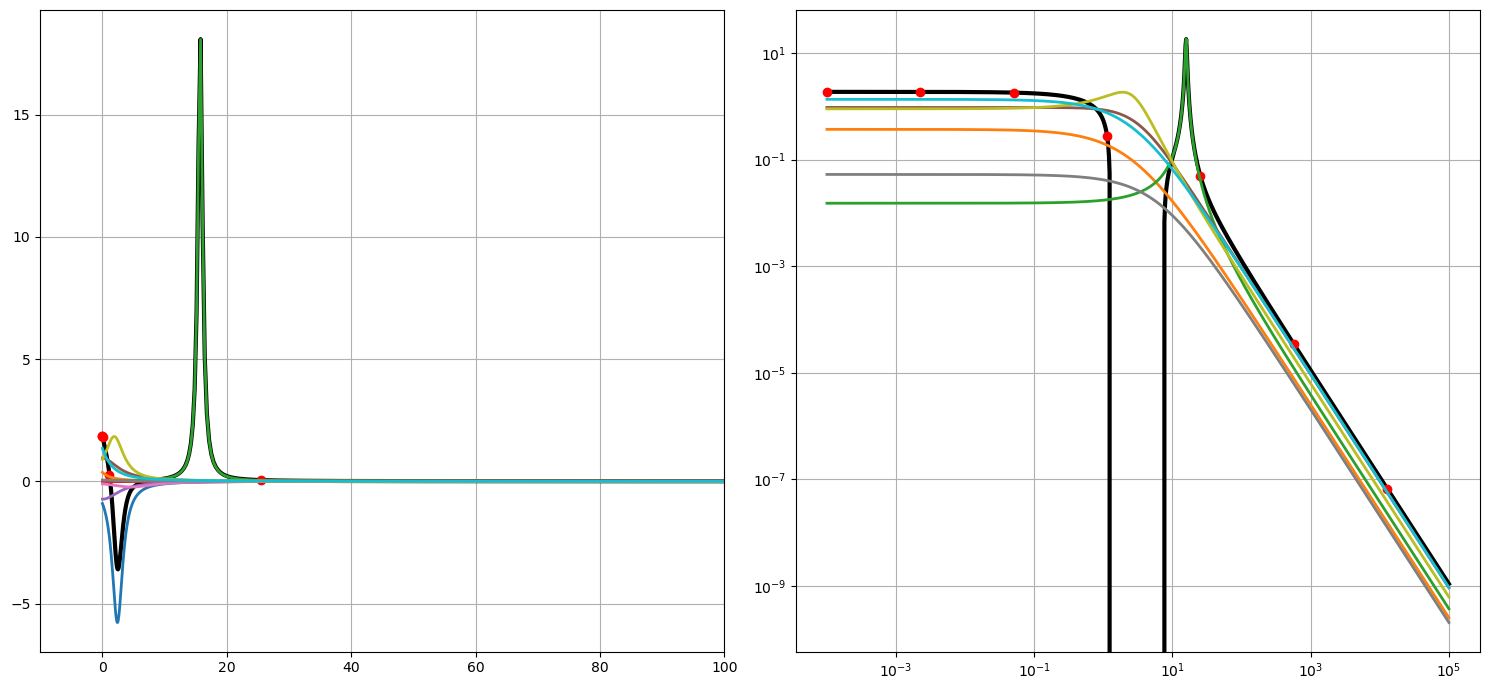

In [128]:
def lorentzian(x, params):
    """Calculate the value of a Lorentzian function at x."""
    center, width, amplitude = params
    return amplitude / (width**2 + ((x - center))**2)

def sum_of_lorentzians(x, n, params_list):
    """Calculate the sum of n Lorentzian functions."""
    result = np.zeros_like(x)
    for params in params_list[:n]:
        result += lorentzian(x, params)
    return result

# Example usage:
x_values = np.logspace(-4, 5, 1000)

rand =np.random.randint(10000)
print(rand)
np.random.seed(rand)

params_list = param_gen_lorentzian(10,1, center_range=[-10,20], width_range=[0,10], amp_range=[-10,10])

sum_of_lorentzians_values = sum_of_lorentzians(x_values, len(params_list), params_list)
for val in params_list:
    print(val)

fig, ax = plt.subplots(1,2, figsize=[15,7])
ax[0].plot(x_values, sum_of_lorentzians_values, 'k-', lw=3)
ax[0].plot(x_values[0::150], sum_of_lorentzians_values[0::150], 'ro',)
for val in params_list:
    ax[0].plot(x_values, lorentzian(x_values, val), lw=2, alpha=1)

ax[0].set_xlim(-10,100)
ax[0].grid(True)

ax[1].plot(x_values, sum_of_lorentzians_values, 'k-', lw=3)
ax[1].plot(x_values[0::150], sum_of_lorentzians_values[0::150], 'ro',)
ax[1].grid(True)
for val in params_list:
    ax[1].plot(x_values, lorentzian(x_values, val), lw=2, alpha=1)

ax[1].set_xscale('log')
ax[1].set_yscale('log')

slope=-2
#plt.plot(np.logspace(-0,4,70), 10**2*np.logspace(-0,4,70)**slope, 'b-',lw =3, label = str(slope))

plt.tight_layout()

plt.show()

In [65]:
import random

4525

In [68]:
x_values

array([1.00000000e-04, 1.01392541e-04, 1.02804473e-04, 1.04236067e-04,
       1.05687597e-04, 1.07159340e-04, 1.08651577e-04, 1.10164595e-04,
       1.11698682e-04, 1.13254132e-04, 1.14831241e-04, 1.16430313e-04,
       1.18051653e-04, 1.19695570e-04, 1.21362380e-04, 1.23052400e-04,
       1.24765955e-04, 1.26503372e-04, 1.28264983e-04, 1.30051125e-04,
       1.31862140e-04, 1.33698374e-04, 1.35560179e-04, 1.37447909e-04,
       1.39361927e-04, 1.41302599e-04, 1.43270295e-04, 1.45265393e-04,
       1.47288272e-04, 1.49339322e-04, 1.51418933e-04, 1.53527503e-04,
       1.55665436e-04, 1.57833141e-04, 1.60031031e-04, 1.62259529e-04,
       1.64519059e-04, 1.66810054e-04, 1.69132952e-04, 1.71488197e-04,
       1.73876240e-04, 1.76297538e-04, 1.78752553e-04, 1.81241755e-04,
       1.83765620e-04, 1.86324631e-04, 1.88919278e-04, 1.91550056e-04,
       1.94217468e-04, 1.96922026e-04, 1.99664245e-04, 2.02444651e-04,
       2.05263775e-04, 2.08122157e-04, 2.11020343e-04, 2.13958887e-04,
      